Didn't miss writing a notebook for statistics that much :|

First things first we need to change the extensions of the matches to txt from tcx (the export format of choice of the garmin connect app) but first some imports

In [2]:
import os
import numpy as np
import pandas as pd
import csv
import chess
import chess.pgn
import chess.engine
from stockfish import Stockfish
import matplotlib.pyplot as plt
import math
from sklearn import mixture
from sklearn.model_selection import train_test_split
from matplotlib.patches import Ellipse
import statsmodels.formula.api as smf

In [153]:
def change_ext(cartella, old_ext, new_ext):
    for root, dirs, files in os.walk(cartella):
        # print(os.getcwd())
        for f in files:
            filename = os.fsdecode(f)
            
                
            if filename.endswith(old_ext):
                name, ext = os.path.splitext(filename)
                
                new_name = name + new_ext
                jpath = os.path.join(root,new_name)
                os.rename(os.path.join(root,filename), jpath)
                print(f"renamed {os.path.join(root,filename)} to {jpath}")

change_ext("games", ".tcx", ".txt")

renamed games/partita_0817-2/w_activity_9454913342.tcx to games/partita_0817-2/w_activity_9454913342.txt
renamed games/partita_0817-2/b_activity_9420301716_tom.tcx to games/partita_0817-2/b_activity_9420301716_tom.txt
renamed games/partita_0817-3/b_activity_9454913482.tcx to games/partita_0817-3/b_activity_9454913482.txt
renamed games/partita_0817-3/w_activity_9420372947_tom.tcx to games/partita_0817-3/w_activity_9420372947_tom.txt
renamed games/partita_0817-1/w_activity_9420267252_tom.tcx to games/partita_0817-1/w_activity_9420267252_tom.txt
renamed games/partita_0817-1/b_activity_9418433194.tcx to games/partita_0817-1/b_activity_9418433194.txt


Now we have to import the data from the [Portable Game Notation or pgn](https://en.wikipedia.org/wiki/Portable_Game_Notation)
and read the heartbeats of both white and black (in the games where they are both available) in order to create a 3d dataframe for every game and then to visualize the data we are working with. To process the portable game notation we will use the following cell of code.

In [161]:
### UTILS FOR READING THE ACTIVITIES

def calctime(start,curr):
    c = [int(x) for x in curr.split(":")]
    s = [int(x) for x in start.split(":")]
    return ((c[0] - s[0]) * 60 + (c[1] - s[1])) * 60 + (c[2] - s[2])

def read_activity(game):
    with open(game) as f:
        lines = f.readlines()
        hr = []
        time = []
        for s in lines:
            if "<Value>" in s:
                hr.append(int(s.strip()[s.strip().find(">") + 1:s.strip().rfind("<")]))
            if "<Time>" in s:
                s = s.strip()[3:]
                if not time:
                    start = s.strip()[s.strip().find("T") + 1:s.strip().rfind(".")]
                    
                time.append(calctime(start, s.strip()[s.strip().find("T") + 1:s.strip().rfind(".")]))
        
        #print(f"hr is {hr}, and time is {time}")
        hr = hr[2:]
        if len(time) - 1 != time[-1]:
            diz = {time[i]: hr[i] for i in range(min(len(hr), len(time)))}
            last_battito = 0
            hr = []
            tempo = []
            keys = list(diz.keys())
            
            print(time[-1] + 1)
            prev = -1
            last_battito = 0
            for s in range(time[-1] + 1):
                if s in diz:
                    
                    hr.append(diz[s])
                    tempo.append(s)
                    last = (diz[s], s)
                    indice_s = keys.index(s)
                    if indice_s + 1 < len(keys):
                        next_s = keys[indice_s + 1]
                        next = (diz[keys[indice_s + 1]], next_s)
                    
                    
                    
                else:
                    total_gap = s - last[1] + next[1] - s
                    if total_gap <= 0:
                        
                        hr.append(last_battito)
                        tempo.append(s)
                        continue
                    
                    weight_next = (s-last[1]) * 100 / total_gap
                    weight_last = 100 - weight_next 
                    est_battito = (weight_last * float(last[0]) + weight_next * float(next[0])) / 100
                    last_battito = est_battito
                    
                    hr.append(round(est_battito))
                    tempo.append(s)
                    
            delta = sum(hr[:10]) // 10
            hrd = np.array(hr) - delta
            
            return list(zip(hrd,tempo))
                
        delta = sum(hr[:10]) // 10
        hrd = np.array(hr) - delta
        return list(zip(hrd,time))
        
#read_activity("games/partita_0814-2/white.txt")

In [93]:
lista = [(1,0),(2,0),(3,0),(4,0),(5,0),(3,0),(2,0),(1,0)]
delta = sum([lista[i][0] for i in range(3)]) // 3


In [157]:
### UTILS FOR READING THE PGN

#this method takes as input the board and the last move so to update the board and compute the evaluation
def get_evaluation(board,move):

    stockfish = Stockfish("/usr/local/Cellar/stockfish/15/bin/stockfish")     #if no parameter passed, takes as input the executable file called stockfish from the same directory, if found
    board.push_san(move)        #insert the move in the board
    stockfish.set_fen_position(board.fen())  #bpard.fen() applies a PGN to FEN conversion
    engine = chess.engine.SimpleEngine.popen_uci("stockfish")
    info = engine.analyse(board, chess.engine.Limit(time=0.1))     #gets the infos of the game
    
    #if the position on the board is not a mate the score is in centipawns, then it's divided by 100 to get the actual score
    #Gets the score from White’s point of view
    if chess.engine.PovScore.is_mate(info['score']):
        eval = chess.engine.PovScore.white(info['score'])
    else:
        eval = int(str(chess.engine.PovScore.white(info['score'])))/100

    return board, eval      #returns the board updated and the evaluation of the position

In [158]:
def get_timestamps(file):
    timestamps = []
    file = file[:-3] + "txt"
    with open(file, "r") as f:
        file_read = f.read()
        lista = file_read.split("%")
        
        
        for el in lista:
            if el[0:4] == "time":
                num = ""
                flag = False
                for i  in range(len(el)):
                    while el[i].isdigit():
                        num += el[i]
                        i += 1
                        flag = True
                    if flag:
                        timestamps.append(int(num)/10)
                        break
    return timestamps
            
get_timestamps("/Users/tommasodimario/Documents/GitHub/statistics-101/project/src/games/partita_0816-7/tommidim_vs_roccot01_2022.08.16.txt")

[0.1,
 0.1,
 3.4,
 0.9,
 13.6,
 1.9,
 2.8,
 9.8,
 3.5,
 11.4,
 13.7,
 9.5,
 13.0,
 19.4,
 12.9,
 11.3,
 2.5,
 1.7,
 17.7,
 5.5,
 10.1,
 2.7,
 0.6,
 4.8,
 21.2,
 4.4,
 0.1,
 10.4,
 2.5,
 22.1,
 10.8,
 12.1,
 23.1,
 6.5,
 1.6,
 20.3,
 7.7,
 49.1,
 27.4,
 10.1,
 3.5,
 16.7,
 6.2,
 8.7,
 37.7,
 34.0,
 49.1,
 9.7,
 26.9,
 29.2,
 11.8,
 1.4,
 12.9,
 22.8,
 17.7,
 17.7,
 12.9,
 20.9,
 54.3,
 12.6,
 6.0,
 1.6,
 0.4,
 1.0,
 0.4,
 26.9,
 3.7,
 7.1,
 25.2,
 15.9,
 42.5,
 7.4,
 15.1,
 16.0,
 10.7,
 21.5,
 7.9,
 13.1,
 21.0,
 1.7,
 2.0,
 22.3,
 1.1,
 19.5,
 6.0,
 18.0,
 19.3,
 12.7,
 0.7,
 3.9,
 2.0,
 6.2,
 3.8,
 1.3,
 3.1,
 3.2,
 7.7,
 1.5,
 0.1,
 1.1]

In [159]:
def get_moves(file):
    moves = []
    file = file[:-3] + "txt"
    with open(file, "r") as f:
        file_read = f.read()
        lista = file_read.split("{")
        return [[elem.strip()]  for el in lista for elem in el[-7:].split() if "." not in elem][:-1]
        
#get_moves("/Users/tommasodimario/Documents/GitHub/statistics-101/project/src/partite_confronto/partita_timestamp.txt")

In [136]:
#read_pgn takes as input the name of the file pgn containing the game and returns a dataframe
def read_pgn(game_name): 
    old = False
    if ("05.29" in game_name or "05.25" in game_name or "clk" in game_name) and "x" not in game_name:
        old = True
    #opens and reads the pgn file
    if not old:
        timestamps = get_timestamps(game_name)
    pgn = open(game_name) 
    
    game = chess.pgn.read_game(pgn)
    
    print(old)
                                   
    array = []      #initialize the array that will contain the data
    index_values = [] 
    i=0
    time_white = -0.1      #to keep track of the time for each player
    time_black = 0      #to keep track of the time for each player
    board = chess.Board()       #initialize the chessboard
    
    #iterate through the moves
    for node in game.mainline():        
        
        move = str(node.move)       #represents the last move
        board,evaluation = get_evaluation(board,move)       #the get_evaluation method returns the updated board and the evaluation of the current position
        
        newboard = board.copy()
        
        if i%2 == 0:        #if the white is moving we update his time
            index_values.append("white")
            if old:
                time_white = 600 - node.clock()
                array.append([str(node.move),round(600 - node.clock(),4),round(time_white+time_black,4),evaluation, str(newboard.fen())])   
            else:
                time_white += timestamps[i]
                array.append([str(node.move),round(time_white,4),round(time_white+time_black,4),evaluation, str(newboard.fen())])
            
           
        else:           #if the black is moving we update his time
            index_values.append("black") 
            if old:
                time_black = 600 - node.clock()
                array.append([str(node.move),round(600 - node.clock(),4),round(time_white+time_black,4),evaluation, newboard.fen()])   
            else:
                time_black += timestamps[i]
                array.append([str(node.move),round(time_black,4),round(time_white+time_black,4),evaluation, newboard.fen()])
        # display(newboard)
        #evaluation = get_evaluation(board,move)
        #we append an element in the array (a row in the dataframe) with move, time the player used, total time since the game started and evaluation of the position
        # if str(evaluation)[:2] == "#+":
        #     evaluation = 15
        # elif str(evaluation)[:2] == "#-":
        #     evaluation = -15
        
            
        i += 1
        
    
    
    
    
    res = []
    j = 0
    #df = pd.DataFrame(data = array, index = index_values, columns = column_values) 
    
    tub = 0
    tuw = 0
    pos = 0.0
    for i in range(int(array[-1][2]) + 2):
        mosse = []
        
        while j < len(array):
            if float(array[j][2]) > float(i):
                break
            

            pos = array[j][3]
            boardy = array[j][-1]
            # display(boardy)
            mosse.append(array[j][0])
            if j % 2 == 0:
                tuw = array[j][1]
            elif j % 2 != 0:
                tub = array[j][1]
            j += 1
            if j > len(array):
                break
        res.append([i, pos, (tuw,tub), mosse, boardy])
    
    # print("\n\n The tail of res is:\n")
    # print(res)    
    # print("\n\n The tail of array is:\n")
    # print(array)
    
         
        
    #create a dataframe

    return res,array


# res,array = read_pgn("games/partita_0529-1/roccot01_vs_tommidim_2022.05.29.pgn")

In [ ]:
# column_values = ['move','time','real time','evaluation'] #create the columns names
    
# res = []
# j = 0
#     #df = pd.DataFrame(data = array, index = index_values, columns = column_values) 
    
# tub = 0
# tuw = 0
# pos = 0.0
# for i in range(round(array[-1][2]) + 1):
#     mosse = []
    
#     while j < len(array):
        
#         if int(array[j][2]) > i:
#             break
        
#         # print(f"array[j] is {array[j]}")
#         pos = array[j][3]
#         mosse.append(array[j][0])
#         if j % 2 == 0:
#             tuw = array[j][1]
#         elif j % 2 != 0:
#             tub = array[j][1]
#         j += 1
        
#         if j >= len(array):
#             break
#     res.append([i, pos, (tuw,tub), mosse])
    
# print("\n\n The res is:\n")
# print(res)
# print("\n\n\n\n")
        
    
# #create a dataframe


In [150]:
## creaiamo un dizionario con tutte le partite, il dizionario viene inizializzato qui così poi dopo verrano fatti 
# gli accessi da sotto e poi vederemo il da farsi

diz_pgn = {} 
os.chdir("/Users/tommasodimario/Documents/GitHub/statistics-101/project/src")
os.getcwd()
listozzo = [('zSanjatosti_vs_valesepicacchi_2022.08.14 (1).pgn', 'games/partita_0814-2'), ('roccot01_vs_tommidim_2022.08.16.pgn', 'games/partita_0816-6'), ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-1'), ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-7'), ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-3'), ('gggarce_vs_valesepicacchi_2022.08.13 (2).pgn', 'games/partita_0813-3'), ('valesepicacchi_vs_gggarce_2022.08.13.pgn', 'games/partita_0813-4'), ('tommidim_vs_roccot01_2022.05.29.pgn', 'games/partita_0529-2'), ('roccot01_vs_tommidim_2022.05.29 (2).pgn', 'games/partita_0529-5'), ('tommidim_vs_roccot01_2022.05.25 (1).pgn', 'games/partita_0525-1'), ('valesepicacchi_vs_gggarce_2022.08.13 (1).pgn', 'games/partita_0813-2'), ('tommidim_vs_roccot01_2022.05.29 (1).pgn', 'games/partita_0529-4'), ('roccot01_vs_tommidim_2022.05.29 (1).pgn', 'games/partita_0529-3'), ('valesepicacchi_vs_Sanjatosti_2022.08.14.pgn', 'games/partita_0814-1'), ('roccot01_vs_tommidim_2022.08.16.pgn', 'games/partita_0816-2'), ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-5'), ('roccot01_vs_tommidim_2022.08.16.pgn', 'games/partita_0816-4'), ('roccot01_vs_tommidim_2022.05.29.pgn', 'games/partita_0529-1'), ('tommidim_vs_roccot01_2022.05.25.pgn', 'games/partita_0525-3'), ('roccot01_vs_tommidim_2022.05.25.pgn', 'games/partita_0525-2'), ('gggarce_vs_valesepicacchi_2022.08.13 (3).pgn', 'games/partita_0813-1')]
for i, el in enumerate(listozzo):
    print(f"{i}  -  {el}") 

# 0  √  ('zSanjatosti_vs_valesepicacchi_2022.08.14 (1).pgn', 'games/partita_0814-2')
# 1  √  ('roccot01_vs_tommidim_2022.08.16.pgn', 'games/partita_0816-6')
# 2  √  ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-1')
# 3  √  ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-7')
# 4  √  ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-3_pgn_occhio')
# 5  √  ('gggarce_vs_valesepicacchi_2022.08.13 (2).pgn', 'games/partita_0813-3')
# 6  √  ('valesepicacchi_vs_gggarce_2022.08.13.pgn', 'games/partita_0813-4')
# 7  √  ('tommidim_vs_roccot01_2022.05.29.pgn', 'games/partita_0529-2')
# 8  √  ('roccot01_vs_tommidim_2022.05.29 (2).pgn', 'games/partita_0529-5')
# NO9  *  ('tommidim_vs_roccot01_2022.05.25 (1).pgn', 'games/partita_0525-1')
# 10  √  ('valesepicacchi_vs_gggarce_2022.08.13 (1).pgn', 'games/partita_0813-2')
# 11  √  ('tommidim_vs_roccot01_2022.05.29 (1).pgn', 'games/partita_0529-4')
# 12  √  ('roccot01_vs_tommidim_2022.05.29 (1).pgn', 'games/partita_0529-3')
# 13  √  ('valesepicacchi_vs_Sanjatosti_2022.08.14.pgn', 'games/partita_0814-1')
# 14  √  ('roccot01_vs_tommidim_2022.08.16.pgn', 'games/partita_0816-2')
# 15  √  ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-5')
# 16  √  ('roccot01_vs_tommidim_2022.08.16.pgn', 'games/partita_0816-4')
# 17  √   ('roccot01_vs_tommidim_2022.05.29.pgn', 'games/partita_0529-1')
# NO18  *  ('tommidim_vs_roccot01_2022.05.25.pgn', 'games/partita_0525*3')
# NO19  *  ('roccot01_vs_tommidim_2022.05.25.pgn', 'games/partita_0525*2')
# 20  √  ('gggarce_vs_valesepicacchi_2022.08.13 (3).pgn', 'games/partita_0813-1')

0  -  ('zSanjatosti_vs_valesepicacchi_2022.08.14 (1).pgn', 'games/partita_0814-2')
1  -  ('roccot01_vs_tommidim_2022.08.16.pgn', 'games/partita_0816-6')
2  -  ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-1')
3  -  ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-7')
4  -  ('tommidim_vs_roccot01_2022.08.16.pgn', 'games/partita_0816-3')
5  -  ('gggarce_vs_valesepicacchi_2022.08.13 (2).pgn', 'games/partita_0813-3')
6  -  ('valesepicacchi_vs_gggarce_2022.08.13.pgn', 'games/partita_0813-4')
7  -  ('tommidim_vs_roccot01_2022.05.29.pgn', 'games/partita_0529-2')
8  -  ('roccot01_vs_tommidim_2022.05.29 (2).pgn', 'games/partita_0529-5')
9  -  ('tommidim_vs_roccot01_2022.05.25 (1).pgn', 'games/partita_0525-1')
10  -  ('valesepicacchi_vs_gggarce_2022.08.13 (1).pgn', 'games/partita_0813-2')
11  -  ('tommidim_vs_roccot01_2022.05.29 (1).pgn', 'games/partita_0529-4')
12  -  ('roccot01_vs_tommidim_2022.05.29 (1).pgn', 'games/partita_0529-3')
13  -  ('valesepicacchi_vs_Sanjatos

In [149]:
# momentaneamente commentato così da poter fare run all tranquillamente
os.chdir("/Users/tommasodimario/Documents/GitHub/statistics-101/project/src")
os.chdir("games/partita_0817-4")
filename = f"roccot01_vs_tommidim_2022.08.17.pgn"
print(filename)

pgn, _ = read_pgn(filename)


# ## Problemi con le partite numero: 9 pos referenced before assignment
# ##                                 11 list index out of range 
# ##                                 16 list index out of range
# ##                                 18 pos referenced before assignment 
# ##                                 19 pos referenced before assignment 

roccot01_vs_tommidim_2022.08.17.pgn
False


KeyboardInterrupt: 

In [143]:
file = open(f"{filename[:-4]}.csv", "w")

writer = csv.writer(file)
print(f"\n {pgn[-5:]}")
columns = ["Time", "Eval", "TimeUsed", "Moves", "Board"]
writer.writerow(columns)
for row in pgn:
    writer.writerow(row)


 [[1017, -7.48, (596.5, 419.7), ['c4e3'], '1k2r1r1/pp6/4p3/3pP3/1P1P2pR/2P1n3/1P6/1K4R1 w - - 2 42'], [1018, -7.48, (596.5, 419.7), [], '1k2r1r1/pp6/4p3/3pP3/1P1P2pR/2P1n3/1P6/1K4R1 w - - 2 42'], [1019, -7.42, (598.7, 419.7), ['g1g3'], '1k2r1r1/pp6/4p3/3pP3/1P1P2pR/2P1n1R1/1P6/1K6 b - - 3 42'], [1020, -7.42, (598.7, 419.7), [], '1k2r1r1/pp6/4p3/3pP3/1P1P2pR/2P1n1R1/1P6/1K6 b - - 3 42'], [1021, -6.83, (598.7, 421.9), ['e3f5'], '1k2r1r1/pp6/4p3/3pPn2/1P1P2pR/2P3R1/1P6/1K6 w - - 4 43']]


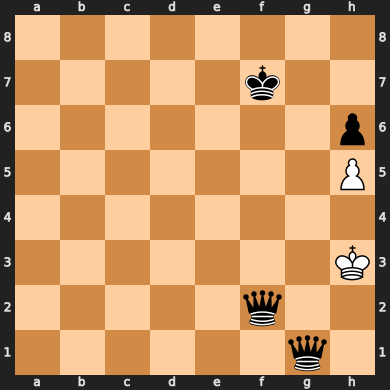

In [ ]:
display(chess.Board(pgn[-1][-1]))


In [162]:
## qua creo il dataset grosso
file = open("partite.csv", "w")

writer = csv.writer(file)

columns = ["Time", "Game", "Player", "Statistics", "Value"]
writer.writerow(columns)

#pseudo code
# to do create queste cose così da poter iterare in questa roba della morte e creare un dataset di questo tipo
# https://raw.githubusercontent.com/QuantEcon/lecture-python/master/source/_static/lecture_specific/pandas_panel/realwage.csv




lista_partite = []
gamecount = 0
count = 0   
for root,dirs, files in os.walk("games"):
    if str(root)  != "games":

        partita = f"Game{root[-6:]}"
        lista_partite.append(root[-6:])
        gamecount += 1
        
    row_written = 0
    flag = False
    row_1 = []
    row_2 = []
    row_3 = [] 
    row_4 = []
    row_5 = []
    row_6 = []
    for file in files:
        #qui siamo dentro i file di una singola partita
        filename = os.fsdecode(file)
        #print(filename)
        if filename.endswith(".txt") and (filename[0] == "w" or filename[0] == "b"): # abbiamo un carissimo file delle attività
        #leggiamo i battiti
            #print(f"processando {filename}")
            player = filename[0]
            activity = read_activity(f"{str(root)}/{filename}")
            # As explained in the markdown above on our strumentation TODO our smartwatches recorded the heartbeats at different time so we smoothed it out
            for hr, time in activity:
                row = [int(time), partita, player, "HR", int(hr)]
                
                
                if filename[0] == "w":
                    row_1.append(row)
                elif filename[0] == "b": 
                    row_2.append(row)
            print("adda")
            row_written += 1
            
        elif filename.endswith(".pgn"):
            # #print(get_moves(f"{str(root)}/{filename}",), filename, partita)
            filename = filename[:-3] + "csv"
            #print(f"processando {filename}")
            
            
            with open(f"{str(root)}/{filename}", newline='') as f:
                print("leggo")
                pgn = []
                for row in csv.reader(f):
                    if row[0] == "Time":
                        continue
                    
                    tupla = eval(row[2])
                    pos = row[1]
                    lastpos = 0
                    
                    if "#" in row[1] or "Mate" in row[1]:
                        if "MateGiven" in row[1]:
                            pos = lastpos  
                        elif "-" in pos:
                            pos = -20
                            lastpos = pos
                        else:
                            pos = +20
                            lastpos = pos
                    elif float(row[1]) >= 20:
                        pos = 20
                    elif float(row[1]) <= -20:
                        pos = 20
                        # #print(row[1], pos)
                    pgn.append([int(row[0]), float(pos), (float(tupla[0]),float(tupla[0])), eval(row[3])])
                    # #print([int(row[0]), float(pos), (float(tupla[0]),float(tupla[0])), eval(row[3]) ])
                        
                print("aooo")
                pgn = pgn[1:]
                last_second = len(pgn) - 1
                    
                for second in range(len(pgn)):
                    
                    ev = pgn[second][1]
                    
                    ev = float(pgn[second][1])
                    
                    row = [second, partita, "w", "Evaluation", ev]
                    
                    row_3.append(row)
                    row = [second, partita, "b", "Evaluation", -ev]
                    row_4.append(row)
                    
                
                for second in range(len(pgn)):
                    
                    row = [second, partita, "w", "TimeUsed", int(pgn[second][2][0])]
                    row_5.append(row)
                    row = [second, partita, "b", "TimeUsed", int(pgn[second][2][1])]
                    row_6.append(row)
                    
                print("addr")
                row_written += 1
            
    print(row_written, partita)
    if row_written == 3:
        
        list_rows = [row_1,row_2,row_3,row_4, row_5, row_6]
        length = min([len(row) for row in list_rows])
        print("siuu")
        
        
        count = 0
        for i in range(6):
            
            for r in range(length):
                
                writer.writerow([count] + list_rows[i][r])
                count += 1
                
            row_written = False

print(lista_partite)



0 Game0814-2
leggo
aooo
addr
adda
925
adda
3 Game0814-2
siuu
adda
leggo
aooo
addr
864
adda
3 Game0816-6
siuu
leggo
aooo
addr
adda
869
adda
3 Game0816-1
siuu
adda
leggo
aooo
addr
1233
adda
3 Game0816-7
siuu
leggo
aooo
addr
adda
492
adda
3 Game0813-3
siuu
1036
adda
leggo
aooo
addr
adda
3 Game0813-4
siuu
leggo
aooo
addr
453
adda
adda
3 Game0817-2
siuu
531
adda
leggo
aooo
addr
adda
3 Game0529-2
siuu
leggo
aooo
addr
1125
adda
adda
3 Game0529-5
siuu
815
adda
leggo
aooo
addr
adda
3 Game0813-2
siuu
918
adda
leggo
aooo
addr
adda
3 Game0529-4
siuu
leggo
aooo
addr
adda
721
adda
3 Game0529-3
siuu
leggo
aooo
addr
adda
991
adda
3 Game0817-3
siuu
1068
adda
leggo
aooo
addr
adda
3 Game0817-4
siuu
1136
adda
leggo
aooo
addr
adda
3 Game0814-1
siuu
adda
leggo
aooo
addr
572
adda
3 Game0816-2
siuu
1246
adda
leggo
aooo
addr
adda
3 Game0816-5
siuu
leggo
aooo
addr
591
adda
adda
3 Game0816-4
siuu
964
adda
leggo
aooo
addr
962
adda
3 Game0816-3
siuu
adda
leggo
aooo
addr
1233
adda
3 Game0817-1
siuu
adda
1117
adda
l

In [163]:
## DATASET PER LE MOSSE


vialibera = False

gamecount = 0
count = 0   
partita = ""
with open("mosse.csv", "w") as file:
    writer = csv.writer(file)
    # TR: Time Remaining
    # T: Time in seconds from the beginning of the match
    # HRDelta: difference of the heart rate at the moment of the move
    # TPR: Time per move
    
    columns = ["MoveS","MovePGN", "Player", "TimeUsed", "Time", "Evaluation","HRDelta", "TPM", "Board", "Game", "DeltaPos", "AbsHRAfter","AbsHRBefore","AbsHRAfter_altro","AbsHRBefore_altro"]
    # move ok, board ok, player ok, tr ok, t ok, hrdelta ok, manca tpr
    writer.writerow(columns)
    file.close()

for root,dirs, files in os.walk("games"):
    if str(root)  != "games":
        partita = f"Game{root[-6:]}"
        gamecount += 1
        
    df = pd.read_csv("partite.csv")

    df = df.pivot_table(values='Value',
                            index='Time',
                            columns=['Game', 'Player', 'Statistics'])
    for file in files:
        #qui siamo dentro i file di una singola partita
        filename = os.fsdecode(file)
        
        #print(filename)
        
        #leggiamo i battiti
        
        if filename.endswith(".pgn"):
            vialibera = True
            filename = filename[:-3] + "csv"
            # print(f"processando {filename}")
            
        
            moves = get_moves(f"{str(root)}/{filename}")
            currpos = 0.0
            last_pos = 0.0
            lastbb = 0
            lastbw = 0
            added = 0
            ret = []
            # print(moves)
            with open(f"{str(root)}/{filename}", newline='') as f:
                pgn = []
                time_last_move_w = 0.0
                time_last_move_b = 0.0
                
                for row in csv.reader(f):
                    if row[0] == "Time":
                        continue
                    
                    if "#" in  row[1]:
                        if "-" in row[1]:
                            currpos = -20.0
                        elif "+" in row[1]:
                            currpos = 20.0
                    
                    else:
                        currpos = float(row[1]) 
                        if currpos > 20.0:
                            currpos = 20.0
                        elif currpos < -20.0:
                            currpos = -20.0
                    
                    diffw = 1
                    diffb = 1
                    move = eval(row[3])
                    abshrdopo = 0
                    abshrprima = 0
                    abshrprima_altro=0
                    abshrdopo_altro=0
                    if move != []:
                        trem = eval(row[2])
                        # aggiungi max_delta(5 secondi da quella mossa)
                        # aggiungi differenza di posizione di mossa in mossa
                        # togli mosse che clashano
                        for _ in move:
                            if added % 2 == 0:
                            
                                delta_pos = float(currpos) - last_pos
                                last_pos = float(currpos)
                                # else:
                                #     if "-" in currpos:
                                #         delta_pos = -20 - last_pos
                                #         last_pos = -20
                                #     elif "+" in currpos:
                                #         delta_pos = 20 - last_pos
                                #         last_pos = 20
                                try:
                                    battw = df[partita]["w"]["HR"][int(row[0])]
                                    battb_altro = df[partita]["b"]["HR"][int(row[0])]
                                    if math.isnan(battw):
                                        battw = lastbw
                                        battb_altro = lastbb
                                    lastbw = battw
                                    lastb_altro = battb_altro
                                    for i in range(5):
                                        ## ABSHR per 5 secondi dopo
                                        try: 
                                            print(partita)
                                            nbw = int(df[partita]["w"]["HR"][int(row[0]) + i])
                                            nbb_altro = int(df[partita]["b"]["HR"][int(row[0]) + i])
                                            
                                        except:
                                            pass
                                        else:
                                            nb = int(df[partita]["w"]["HR"][int(row[0]) + i])
                                            ab = abs(abs(int(battw)) + abs(int(nbw)))
                                            abshrdopo = max( abshrdopo, ab)

                                            nb_altro = int(df[partita]["b"]["HR"][int(row[0]) + i])
                                            ab_altro = abs(abs(int(battw)) + abs(int(nbb_altro)))
                                            abshrdopo_altro = max( abshrdopo_altro, ab_altro)
                                        
                                        ## ABSHR per 5 secondi prima
                                        if int(row[0]) - i >= 0:
                                            nb = int(df[partita]["w"]["HR"][int(row[0]) - i])
                                            ab = abs(abs(int(battw)) + abs(int(nb)))
                                            abshrprima = max( abshrprima, ab)

                                            nb_altro = int(df[partita]["b"]["HR"][int(row[0]) - i])
                                            ab_altro = abs(abs(int(battw)) + abs(int(nb_altro)))
                                            abshrprima_altro = max( abshrprima, ab_altro)
                                        else:
                                            abshrprima = 0
                                            abshrprima_altro = 0
                                    
                                    
                                except:
                                    battw = lastbw
                                    
                                
                                ret.append(moves[added] + [move,"w",trem[0],int(row[0]), currpos, battw, trem[0] - time_last_move_w, row[-1], partita,  min(abs(delta_pos), 20),abshrdopo,abshrprima, abshrdopo_altro, abshrprima_altro]) 
                                time_last_move_w = trem[0]
                                
                            else:
                            
                                delta_pos = last_pos - float(currpos)
                                last_pos = float(currpos)
                                    
                                # else:
                                #     if "-" in currpos:
                                #         delta_pos = -20 - last_pos
                                #         last_pos = -20
                                #     elif "+" in currpos:
                                #         delta_pos = 20 - last_pos
                                try:
                                    battb = df[partita]["b"]["HR"][int(row[0])]
                                    battb_altro = df[partita]["w"]["HR"][int(row[0])]
                                    if math.isnan(battb):
                                        battb = lastbb
                                        battb_altro = lastbb
                                    lastbb = battb
                                    lastb_altro = battb_altro
                                    for i in range(5):
                                        
                                        try: 
                                            nbb = int(df[partita]["b"]["HR"][int(row[0]) + i])
                                            nbb_altro = int(df[partita]["w"]["HR"][int(row[0]) + i])
                                            
                                        except:
                                            pass
                                        else:
                                            nbb = int(df[partita]["b"]["HR"][int(row[0]) + i])
                                            ab = abs(abs(int(battb)) + abs(int(nbb)))
                                            abshrdopo = max( abshrdopo, ab)

                                            nb_altro = int(df[partita]["w"]["HR"][int(row[0]) + i])
                                            ab_altro = abs(abs(int(battw)) + abs(int(nbb_altro)))
                                            abshrdopo_altro = max( abshrdopo_altro, ab_altro)
                                            
                                            
                                        
                                        if int(row[0]) - i > 0:
                                            nb = int(df[partita]["b"]["HR"][int(row[0]) - i])
                                            ab = abs(abs(int(battb)) + abs(int(nb)))
                                            abshrprima = max( abshrprima, ab)

                                            nb_altro = int(df[partita]["w"]["HR"][int(row[0]) - i])
                                            ab_altro = abs(abs(int(battw)) + abs(int(nb_altro)))
                                            abshrprima_altro = max( abshrprima, ab_altro)
                                        else:
                                            abshrprima = 0
                                            abshrprima_altro = 0
                                        
                                except:
                                    battb = lastbb
                                    
                                
                                # min(abs(delta_pos), 20)
                                ret.append(moves[added] + [move,"b",trem[1],int(row[0]), currpos, battb, trem[1] - time_last_move_b, row[-1], partita, delta_pos, abshrdopo,abshrprima,abshrdopo_altro,abshrprima_altro])
                                time_last_move_b = trem[1]
                                
                            added += 1
                        

            if vialibera:            

                vialibera =False
                with open("mosse.csv", "a") as file:
                    writer = csv.writer(file)
                    
                    for move in ret:
                        writer.writerow(move)
                                    
                                   



Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2
Game0814-2

In [73]:
abs(-1-1)

2

In [164]:
import pandas as pd
df = pd.read_csv("mosse.csv")
df

MoveS   MovePGN Player  TimeUsed  Time  Evaluation  HRDelta  TPM  \
0       e4  ['e2e4']      w       0.0     0        0.38     -1.0  0.0   
1       e5  ['e7e5']      b       0.1     1        0.55     -1.0  0.1   
2       f3  ['f2f3']      w       5.9     6       -1.07      2.0  5.9   
3      Nf6  ['g8f6']      b       2.6     9       -0.74      2.0  2.5   
4       d3  ['d2d3']      w       7.2    10       -1.44      1.0  1.3   
...    ...       ...    ...       ...   ...         ...      ...  ...   
1885  Qce1  ['c1e1']      b     525.2   779      -20.00      8.0  1.8   
1886   Kg4  ['f5g4']      w     255.6   781      -20.00     -3.0  2.0   
1887  Qdf2  ['d2f2']      b     527.2   783      -20.00     11.0  2.0   
1888   Kh3  ['g4h3']      w     258.2   786      -20.00     -4.0  2.6   
1889  Qeg1  ['e1g1']      b     528.4   787        0.00     11.0  1.2   

                                                  Board        Game  DeltaPos  \
0     rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...  Game0814-2      0.38   
1     rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...  Game0814-2     -0.17   
2     rnbqkbnr/pppp1ppp/8/4p3/4P3/5P2/PPPP2PP/RNBQKB...  Game0814-2      1.62   
3     rnbqkb1r/pppp1ppp/5n2/4p3/4P3/5P2/PPPP2PP/RNBQ...  Game0814-2     -0.33   
4     rnbqkb1r/pppp1ppp/5n2/4p3/4P3/3P1P2/PPP3PP/RNB...  Game0814-2      0.70   
...                                                 ...         ...       ...   
1885               8/5k2/7p/5K1P/8/8/3q4/4q3 w - - 8 66  Game0813-1      0.00   
1886               8/5k2/7p/7P/6K1/8/3q4/4q3 b - - 9 66  Game0813-1      0.00   
1887              8/5k2/7p/7P/6K1/8/5q2/4q3 w - - 10 67  Game0813-1      0.00   
1888               8/5k2/7p/7P/8/7K/5q2/4q3 b - - 11 67  Game0813-1      0.00   
1889               8/5k2/7p/7P/8/7K/5q2/6q1 w - - 12 68  Game0813-1    -20.00   

      AbsHRAfter  AbsHRBefore  AbsHRAfter_altro  AbsHRBefore_altro  
0              2            0                 2                  0  
1              2            0                 2                  0  
2              4            4                 6                  4  
3              6            6                 3                  6  
4              2            3                 6                  3  
...          ...          ...               ...                ...  
1885          19           16                 5                 16  
1886           8            6                15                 10  
1887          23           22                 8                 22  
1888           8            9                16                 15  
1889           0            0                 0                  0  

[1890 rows x 15 columns]

<BarContainer object of 7 artists>

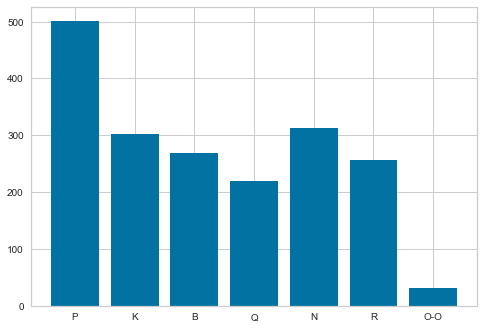

In [166]:
# Let's see what is the most played piece
mosse = df["MoveS"]
diz = {"P" : 0, "K" : 0, "B" : 0, "Q" : 0, "N" : 0, "R" : 0, "O-O": 0, "+" :0, "#": 0, "=":0 }
for mossa in mosse:
    
    if mossa[0].islower(): # è un pedone 
        diz["P"] += 1
    elif mossa[0] in list(diz.keys()):
        diz[mossa[0]] += 1
    if "+" == mossa[-1] or "#" in mossa[-1]:
        diz[mossa[-1]] += 1
    elif "=" in mossa:
        diz["="] += 1
    elif "O-" in mossa:
        diz["O-O"] += 1

plt.bar(list(diz.keys())[:7],list(diz.values())[:7])

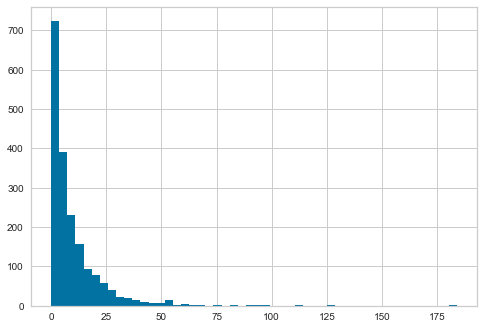

In [173]:
n, bins, patches = plt.hist(df["TPM"], bins = 50)

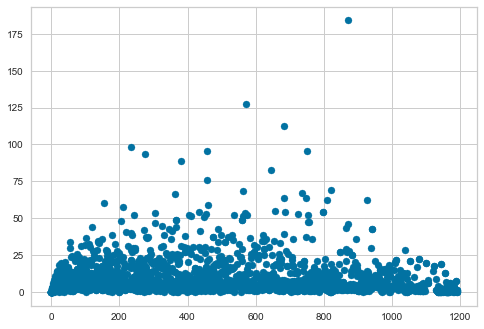

In [174]:
plt.scatter(df["Time"],df["TPM"])

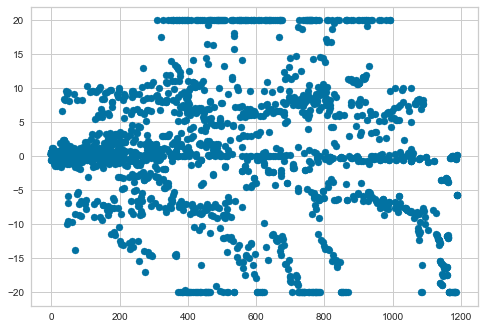

In [175]:
plt.scatter(df["Time"],df["Evaluation"])

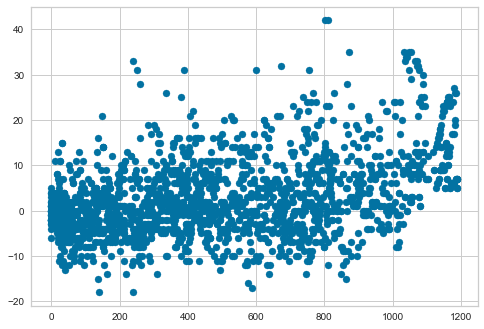

In [176]:
plt.scatter(df["Time"],df["HRDelta"])

(array([  4.,  10.,  65., 105., 222., 300., 390., 203., 210., 127.,  89.,
         57.,  28.,  26.,  27.,   5.,  10.,  10.,   0.,   2.]),
 array([-18., -15., -12.,  -9.,  -6.,  -3.,   0.,   3.,   6.,   9.,  12.,
         15.,  18.,  21.,  24.,  27.,  30.,  33.,  36.,  39.,  42.]),
 <BarContainer object of 20 artists>)

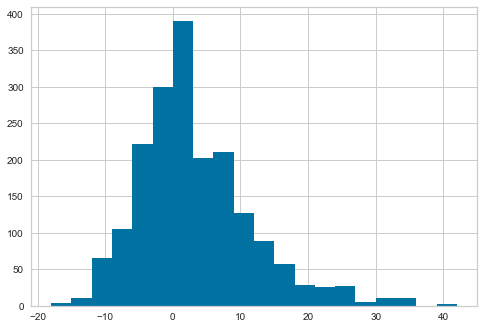

In [177]:
plt.hist(df["HRDelta"], bins = 20)

In [178]:
val = np.array(df["Evaluation"])
# n, bins, patches = plt.hist(df["Evaluation"])
# plt.xticks(bins)
for i in range(len(val)):
    if "#-" in val[i]:
        val[i] = -20
    elif "#+" in val[i]:
        val[i] = 20
    else:
        
        tmpval = float(val[i])
        if tmpval > 20:
            tmpval = 20
        elif tmpval < -20:
            tmpval = -20
        val[i] = tmpval
plt.xlim(-20,20)
n, bins, patches = plt.hist(val, density=1, bins = 50)

TypeError: argument of type 'numpy.float64' is not iterable

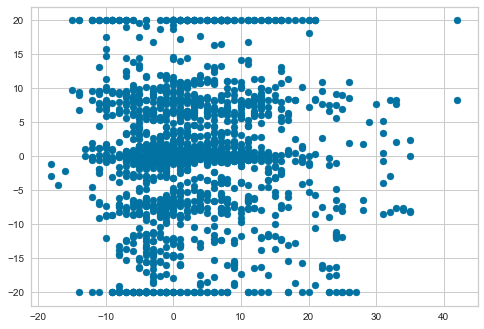

In [179]:
plt.scatter(df["HRDelta"], df["Evaluation"])

(142, MoveS                                                      Rxh7
MovePGN                                                ['g7h7']
Player                                                        w
TimeUsed                                                  444.6
Time                                                        801
Evaluation                                                 8.34
HRDelta                                                      42
TPM                                                        17.6
Board                3r1k2/1R5R/8/3p4/8/8/2n2PPP/5K2 b - - 0 28
Game                                                 Game0816-6
DeltaPos                                                   1.02
AbsHRAfter                                                   84
AbsHRBefore                                                  88
AbsHRAfter_altro                                             43
AbsHRBefore_altro                                            88
Name: 142, dtype: object)


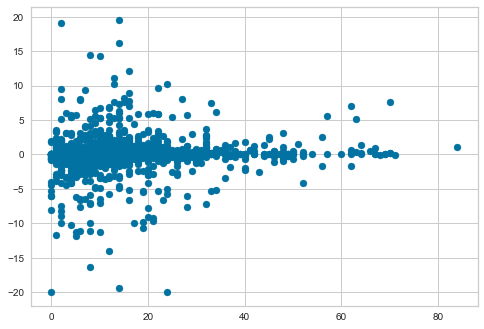

In [180]:
plt.scatter(df["AbsHRAfter"], df["DeltaPos"])
for r in df.iterrows():
    if r[1]["AbsHRAfter"] == max(df["AbsHRAfter"]):
        print(r)


Now we see that this, being really chaotic is quite a mess and actually pretty open to interpretation we remove the variables that have conflicts in the 5 seconds range

In [181]:
# Create a dataset with only the two variables 
df[["AbsHR", "DeltaPos", "HRDelta"]].head(20)

KeyError: "['AbsHR'] not in index"

clustering rispetto a posizione e battito in quel momento

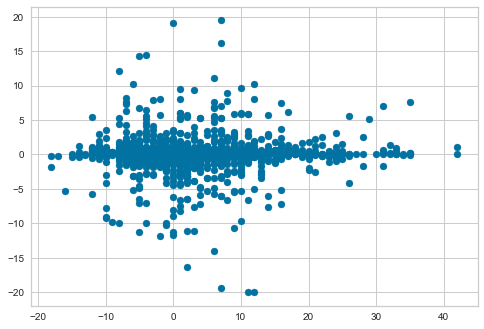

In [183]:
X = df['HRDelta']
Y = df['DeltaPos']
plt.scatter(X,Y)

In [184]:
conflict_time = 0
conflict_set = set()
for i, row in df.iterrows():
    for j, row2 in df.iloc[i+1:i+11].iterrows():
        if int(row2["Time"]) - int(row["Time"]) <= 10:
            conflict_set.add(i)
            conflict_set.add(j)

In [185]:
for el in list(conflict_set):
    try:
        df = df.drop(el)
    except:
        pass
df

MoveS   MovePGN Player  TimeUsed  Time  Evaluation  HRDelta   TPM  \
18    Nge2  ['g1e2']      w      79.1   116       -0.64     -3.0  18.2   
19      c5  ['c7c5']      b      59.8   139        1.28      3.0  23.0   
20     Nd5  ['c3d5']      w     103.7   164        1.02     -4.0  24.6   
21    Bg5+  ['f6g5']      b      87.4   192        0.99      6.0  27.6   
30     Nd5  ['f4d5']      w     186.6   293       -0.21     -6.0  13.8   
...    ...       ...    ...       ...   ...         ...      ...   ...   
1725  Rxb3  ['b8b3']      b     374.2   892        4.40      6.0  20.4   
1731   Ke7  ['f6e7']      b     401.9   949        6.18     12.0  11.5   
1732   Rc1  ['d1c1']      w     558.7   961        5.23     16.0  12.0   
1778    c4  ['c2c4']      w      61.9   205       -8.46     -7.0  23.3   
1798   Qd1  ['e2d1']      w     126.8   464      -11.24     -2.0  22.2   

                                                  Board        Game  DeltaPos  \
18    r1bn1rk1/ppp2ppp/5b2/4p3/4P3/2N2P2/PPP1N1PP/2K...  Game0814-2      0.58   
19    r1bn1rk1/pp3ppp/5b2/2p1p3/4P3/2N2P2/PPP1N1PP/2...  Game0814-2     -1.92   
20    r1bn1rk1/pp3ppp/5b2/2pNp3/4P3/5P2/PPP1N1PP/2KR...  Game0814-2      0.26   
21    r1bn1rk1/pp3ppp/8/2pNp1b1/4P3/5P2/PPP1N1PP/2KR...  Game0814-2      0.03   
30    r1br2k1/pp3ppp/2n5/2pN4/4P2P/8/PPP3P1/2KR1B1R ...  Game0814-2      0.56   
...                                                 ...         ...       ...   
1725  7r/p4ppp/Q3pk2/2bp4/P1P5/1r4PP/5P2/3R2K1 w - -...  Game0529-1     -1.35   
1731  4r3/p3kppp/1r2p3/2bP4/P7/5QPP/5P2/3R2K1 w - - ...  Game0529-1     -0.16   
1732  4r3/p3kppp/1r2p3/2bP4/P7/5QPP/5P2/2R3K1 b - - ...  Game0529-1      0.95   
1778  r1b2rk1/1pb2ppp/p1n1q3/4p3/2P5/3P1N2/PP3PPP/R1...  Game0813-1      2.04   
1798  3rr1k1/1p1q2pp/p4p2/n7/2P5/3P4/PP3PPP/3QR1K1 b...  Game0813-1      1.01   

      AbsHRAfter  AbsHRBefore  AbsHRAfter_altro  AbsHRBefore_altro  
18             7            6                18                 21  
19             7            9                 6                  9  
20             8            8                10                 13  
21            16           12                 7                 12  
30            12           14                14                 14  
...          ...          ...               ...                ...  
1725          12           14                13                 14  
1731          24           25                27                 25  
1732          32           35                23                 35  
1778          15           14                13                 14  
1798           5            4                 4                  4  

[264 rows x 15 columns]

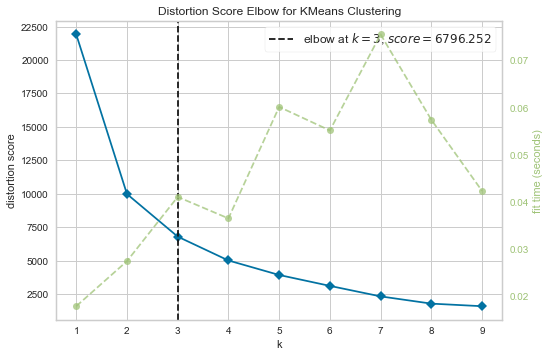

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [186]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

Delta_HR_pos = df[['HRDelta','DeltaPos']]

n_components = np.arange(1, 10)
distortions = []
#we now fit the model using kmeans, trying different numbers of cluster
for i in n_components: 
    # selecting a random_state number we allow the reproducibility of the model
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42) 
    kmeans.fit(Delta_HR_pos) 
    distortions.append(kmeans.inertia_)

visualizer = KElbowVisualizer(kmeans, k=(1,10))
visualizer.fit(Delta_HR_pos)        
visualizer.show()



/var/folders/ly/6dckx2gj5sl9kyny3x0tqstm0000gn/T/ipykernel_15064/2454781274.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ly/6dckx2gj5sl9kyny3x0tqstm0000gn/T/ipykernel_15064/2454781274.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ly/6dckx2gj5sl9kyny3x0tqstm0000gn/T/ipykernel_15064/2454781274.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

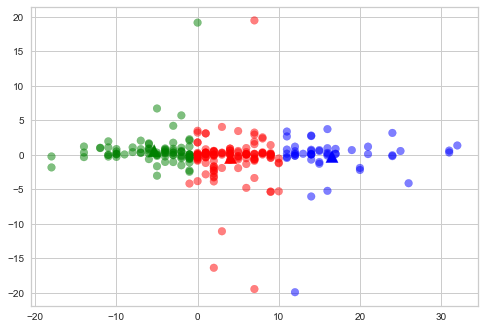

In [191]:
Delta_HR_pos = df[['HRDelta','DeltaPos']]
k_optimal = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
k_optimal.fit(Delta_HR_pos)
#fit the model using kmeans, evaluated using the optimal number of clusters
Delta_HR_pos['cluster'] = k_optimal.fit_predict(Delta_HR_pos)
#we use the cluster_centers_ to find the centroids of the clusters, repsentented as triangles in the figure
centroids = k_optimal.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

Delta_HR_pos['cen_x'] = Delta_HR_pos.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
Delta_HR_pos['cen_y'] = Delta_HR_pos.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})

colors = ['red', 'green', 'blue']
Delta_HR_pos['c'] = Delta_HR_pos.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})
plt.scatter(Delta_HR_pos.HRDelta, Delta_HR_pos.DeltaPos, c=Delta_HR_pos.c, alpha = 0.5, s=60)
plt.scatter(cen_x, cen_y, marker='^', c=colors, s=150)

In [188]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

                             
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40)
    # ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [189]:
Delta_HR_pos = df[['HRDelta','DeltaPos']]
df_tr, df_te = train_test_split(Delta_HR_pos, test_size = 0.30, random_state = 11)
n_components = np.arange(1, 10)
models2 = [mixture.GaussianMixture(n_components = n, covariance_type='full', random_state=42).fit(df_tr) 
            for n in n_components]

score_results = [-m.score(df_te) for m in models2]
aic_list2 = [m.aic(Delta_HR_pos) for m in models2]

number_cluster_aic2 = aic_list2.index(min(aic_list2))+1 #this pretty ugly stuff gives us the lowest result for both
number_cluster_cv2 = score_results.index(min(score_results))+1
print(number_cluster_aic2)
print(number_cluster_cv2)

9
3


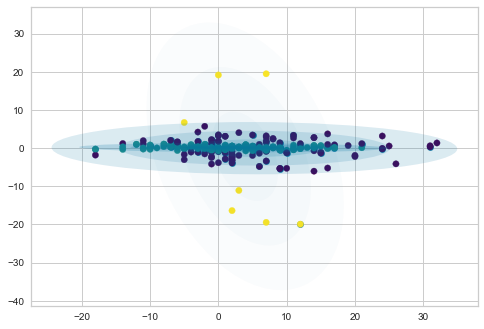

In [192]:
Delta_HR_pos = df[['HRDelta','DeltaPos']]
df_tr, df_te = train_test_split(Delta_HR_pos, test_size = 0.30, random_state = 11)
model = mixture.GaussianMixture(n_components = 3, covariance_type='full', random_state= 25).fit(df_tr)
lebll = model.fit_predict(df_te)

plt.scatter(df_te.HRDelta, df_te.DeltaPos, s=40, cmap='viridis')
plot_gmm(model, Delta_HR_pos.to_numpy())

clustering rispetto a posizione e massima variazione nei battiti nei 5 secondi dopo rispetto alla mossa

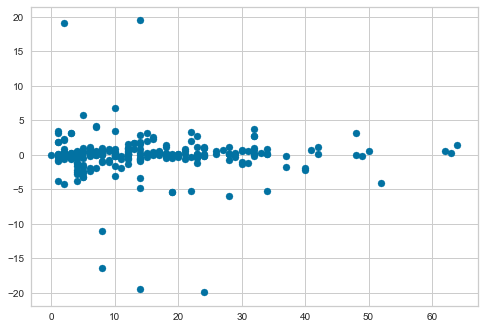

In [193]:
X = df['AbsHRAfter']
Y = df['DeltaPos']
plt.scatter(X,Y)

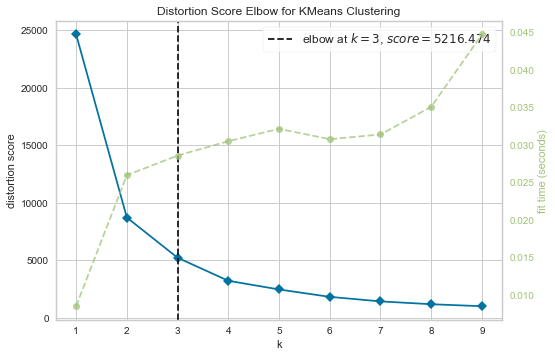

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
Delta_HR_pos = df[['AbsHRAfter','DeltaPos']]

n_components = np.arange(1, 10)
distortions = []
#we now fit the model using kmeans, trying different numbers of cluster
for i in n_components: 
    # selecting a random_state number we allow the reproducibility of the model
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42) 
    kmeans.fit(Delta_HR_pos) 
    distortions.append(kmeans.inertia_)

visualizer = KElbowVisualizer(kmeans, k=(1,10))
visualizer.fit(Delta_HR_pos)        
visualizer.show()

/var/folders/ly/6dckx2gj5sl9kyny3x0tqstm0000gn/T/ipykernel_15064/1960533299.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ly/6dckx2gj5sl9kyny3x0tqstm0000gn/T/ipykernel_15064/1960533299.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ly/6dckx2gj5sl9kyny3x0tqstm0000gn/T/ipykernel_15064/1960533299.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

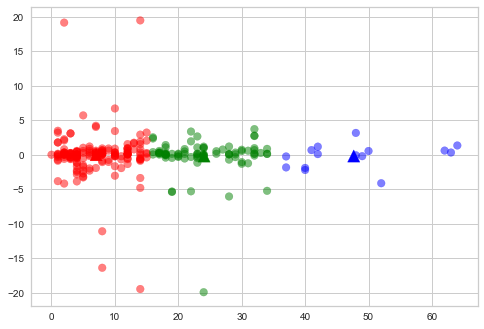

In [194]:
Delta_HR_pos = df[['AbsHRAfter','DeltaPos']]
k_optimal = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
k_optimal.fit(Delta_HR_pos)
#fit the model using kmeans, evaluated using the optimal number of clusters
Delta_HR_pos['cluster'] = k_optimal.fit_predict(Delta_HR_pos)
#we use the cluster_centers_ to find the centroids of the clusters, repsentented as triangles in the figure
centroids = k_optimal.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

Delta_HR_pos['cen_x'] = Delta_HR_pos.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
Delta_HR_pos['cen_y'] = Delta_HR_pos.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})

colors = ['red', 'green', 'blue']
Delta_HR_pos['c'] = Delta_HR_pos.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})
plt.scatter(Delta_HR_pos.AbsHRAfter, Delta_HR_pos.DeltaPos, c=Delta_HR_pos.c, alpha = 0.5, s=60)
plt.scatter(cen_x, cen_y, marker='^', c=colors, s=150)

In [195]:
Delta_HR_pos = df[['AbsHRAfter','DeltaPos']]
df_tr, df_te = train_test_split(Delta_HR_pos, test_size = 0.30, random_state = 11)
n_components = np.arange(1, 10)
models2 = [mixture.GaussianMixture(n_components = n, covariance_type='full', random_state=42).fit(df_tr) 
            for n in n_components]

score_results = [-m.score(df_te) for m in models2]
aic_list2 = [m.aic(Delta_HR_pos) for m in models2]

number_cluster_aic2 = aic_list2.index(min(aic_list2))+1 #this pretty ugly stuff gives us the lowest result for both
number_cluster_cv2 = score_results.index(min(score_results))+1
print(number_cluster_aic2)
print(number_cluster_cv2)

7
5


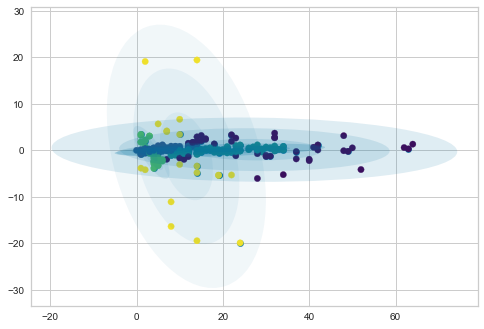

In [196]:
Delta_HR_pos = df[['AbsHRAfter','DeltaPos']]
df_tr, df_te = train_test_split(Delta_HR_pos, test_size = 0.30, random_state = 11)
model = mixture.GaussianMixture(n_components = 5, covariance_type='full', random_state= 25).fit(df_tr)
lebll = model.fit_predict(df_te)

plt.scatter(df_te.AbsHRAfter, df_te.DeltaPos, s=40, cmap='viridis')
plot_gmm(model, Delta_HR_pos.to_numpy())

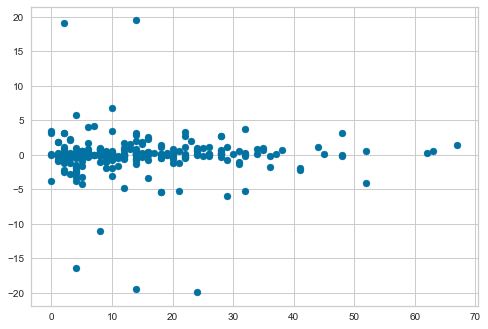

In [197]:
X = df['AbsHRBefore']
Y = df['DeltaPos']
plt.scatter(X,Y)

/var/folders/ly/6dckx2gj5sl9kyny3x0tqstm0000gn/T/ipykernel_15064/2388973137.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ly/6dckx2gj5sl9kyny3x0tqstm0000gn/T/ipykernel_15064/2388973137.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/ly/6dckx2gj5sl9kyny3x0tqstm0000gn/T/ipykernel_15064/2388973137.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

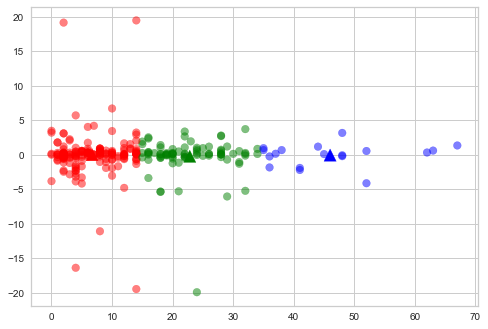

In [198]:
Delta_HR_pos = df[['AbsHRBefore','DeltaPos']]
k_optimal = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
k_optimal.fit(Delta_HR_pos)
#fit the model using kmeans, evaluated using the optimal number of clusters
Delta_HR_pos['cluster'] = k_optimal.fit_predict(Delta_HR_pos)
#we use the cluster_centers_ to find the centroids of the clusters, repsentented as triangles in the figure
centroids = k_optimal.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

Delta_HR_pos['cen_x'] = Delta_HR_pos.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
Delta_HR_pos['cen_y'] = Delta_HR_pos.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})

colors = ['red', 'green', 'blue']
Delta_HR_pos['c'] = Delta_HR_pos.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})
plt.scatter(Delta_HR_pos.AbsHRBefore, Delta_HR_pos.DeltaPos, c=Delta_HR_pos.c, alpha = 0.5, s=60)
plt.scatter(cen_x, cen_y, marker='^', c=colors, s=150)

In [199]:
Delta_HR_pos = df[['AbsHRBefore','DeltaPos']]
df_tr, df_te = train_test_split(Delta_HR_pos, test_size = 0.30, random_state = 11)
n_components = np.arange(1, 10)
models2 = [mixture.GaussianMixture(n_components = n, covariance_type='full', random_state=42).fit(df_tr) 
            for n in n_components]

score_results = [-m.score(df_te) for m in models2]
aic_list2 = [m.aic(Delta_HR_pos) for m in models2]

number_cluster_aic2 = aic_list2.index(min(aic_list2))+1 #this pretty ugly stuff gives us the lowest result for both
number_cluster_cv2 = score_results.index(min(score_results))+1
print(number_cluster_aic2)
print(number_cluster_cv2)

7
7


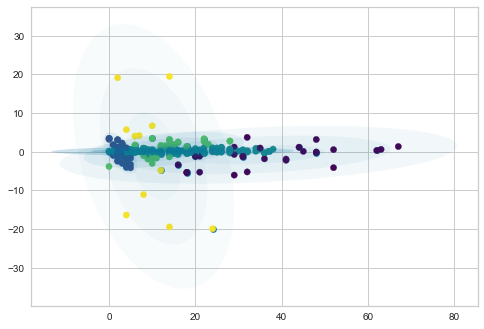

In [368]:

model = mixture.GaussianMixture(n_components = 5, covariance_type='full', random_state= 25).fit(df_tr)
lebll = model.fit_predict(df_te)

plt.scatter(df_te.AbsHRBefore, df_te.DeltaPos, s=40, cmap='viridis')
plot_gmm(model, Delta_HR_pos.to_numpy())

potrebbe essere interessante vedere se ik momento dell'errore cambia qualcosa tipo io mi sengo i blunder e li etichetto come blunder apertur amedio finale e puoi vedere se tutti gli errori in ogni grande momento hanno un cambiamento specifico nell'heartrate

In [396]:
# dff = df[["Time","AbsHRBefore", "AbsHRAfter", "DeltaPos", "HRDelta", "Game"]]
dff = df[["AbsHRBefore","AbsHRAfter", "MoveS", "MovePGN","Time", "DeltaPos", 'Game', "Board",'Evaluation','AbsHRBefore_altro','AbsHRAfter_altro','Player']]
dff

AbsHRBefore  AbsHRAfter MoveS   MovePGN  Time  DeltaPos        Game  \
18              6           7  Nge2  ['g1e2']   116      0.58  Game0814-2   
19              9           7    c5  ['c7c5']   139     -1.92  Game0814-2   
20              8           8   Nd5  ['c3d5']   164      0.26  Game0814-2   
21             12          16  Bg5+  ['f6g5']   192      0.03  Game0814-2   
30             14          12   Nd5  ['f4d5']   293      0.56  Game0814-2   
...           ...         ...   ...       ...   ...       ...         ...   
1725           14          12  Rxb3  ['b8b3']   892     -1.35  Game0529-1   
1731           25          24   Ke7  ['f6e7']   949     -0.16  Game0529-1   
1732           35          32   Rc1  ['d1c1']   961      0.95  Game0529-1   
1778           14          15    c4  ['c2c4']   205      2.04  Game0813-1   
1798            4           5   Qd1  ['e2d1']   464      1.01  Game0813-1   

                                                  Board  Evaluation  \
18    r1bn1rk1/ppp2ppp/5b2/4p3/4P3/2N2P2/PPP1N1PP/2K...       -0.64   
19    r1bn1rk1/pp3ppp/5b2/2p1p3/4P3/2N2P2/PPP1N1PP/2...        1.28   
20    r1bn1rk1/pp3ppp/5b2/2pNp3/4P3/5P2/PPP1N1PP/2KR...        1.02   
21    r1bn1rk1/pp3ppp/8/2pNp1b1/4P3/5P2/PPP1N1PP/2KR...        0.99   
30    r1br2k1/pp3ppp/2n5/2pN4/4P2P/8/PPP3P1/2KR1B1R ...       -0.21   
...                                                 ...         ...   
1725  7r/p4ppp/Q3pk2/2bp4/P1P5/1r4PP/5P2/3R2K1 w - -...        4.40   
1731  4r3/p3kppp/1r2p3/2bP4/P7/5QPP/5P2/3R2K1 w - - ...        6.18   
1732  4r3/p3kppp/1r2p3/2bP4/P7/5QPP/5P2/2R3K1 b - - ...        5.23   
1778  r1b2rk1/1pb2ppp/p1n1q3/4p3/2P5/3P1N2/PP3PPP/R1...       -8.46   
1798  3rr1k1/1p1q2pp/p4p2/n7/2P5/3P4/PP3PPP/3QR1K1 b...      -11.24   

      AbsHRBefore_altro  AbsHRAfter_altro Player  
18                   21                18      w  
19                    9                 6      b  
20                   13                10      w  
21                   12                 7      b  
30                   14                14      w  
...                 ...               ...    ...  
1725                 14                13      b  
1731                 25                27      b  
1732                 35                23      w  
1778                 14                13      w  
1798                  4                 4      w  

[264 rows x 12 columns]

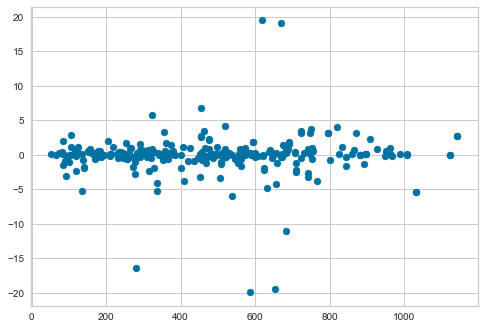

In [202]:
plt.scatter(df["Time"], df["DeltaPos"])

In [415]:
conflict_time = 0
conflict_set = set()
for i, row in dff.iterrows():
    for j, row2 in dff.iloc[i+1:i+11].iterrows():
        if int(row2["Time"]) - int(row["Time"]) <= 10:
            conflict_set.add(i)
            conflict_set.add(j)

In [416]:
for el in list(conflict_set):
    try:
        dff = dff.drop(el)
    except:
        pass
dff

AbsHRBefore  AbsHRAfter MoveS   MovePGN  Time  DeltaPos        Game  \
37             12          10  Rxe8  ['d8e8']   459     -0.18  Game0814-2   
38             22          23   Bc4  ['f1c4']   498      1.06  Game0814-2   
39              3           4  Rxe4  ['e8e4']   515     -0.46  Game0814-2   
40              6          10   Bd5  ['c4d5']   531      0.26  Game0814-2   
41              3           4   Rd4  ['e4d4']   554     -1.20  Game0814-2   
...           ...         ...   ...       ...   ...       ...         ...   
1723           15          15  Rab8  ['a8b8']   844     -0.39  Game0529-1   
1724           14          15   Qa6  ['b7a6']   872      3.21  Game0529-1   
1725           14          12  Rxb3  ['b8b3']   892     -1.35  Game0529-1   
1731           25          24   Ke7  ['f6e7']   949     -0.16  Game0529-1   
1732           35          32   Rc1  ['d1c1']   961      0.95  Game0529-1   

                                                  Board  Evaluation  \
37    4r1k1/pp3ppp/2n5/2p5/4P1bP/8/PPPR2P1/2K2B1R w ...        5.50   
38    4r1k1/pp3ppp/2n5/2p5/2B1P1bP/8/PPPR2P1/2K4R b ...        4.44   
39    6k1/pp3ppp/2n5/2p5/2B1r1bP/8/PPPR2P1/2K4R w - ...        4.90   
40    6k1/pp3ppp/2n5/2pB4/4r1bP/8/PPPR2P1/2K4R b - -...        4.64   
41    6k1/pp3ppp/2n5/2pB4/3r2bP/8/PPPR2P1/2K4R w - -...        5.84   
...                                                 ...         ...   
1723  1r5r/pQ3ppp/4pk2/2bp4/P1P5/1P4PP/5P2/3R2K1 w -...        6.26   
1724  1r5r/p4ppp/Q3pk2/2bp4/P1P5/1P4PP/5P2/3R2K1 b -...        3.05   
1725  7r/p4ppp/Q3pk2/2bp4/P1P5/1r4PP/5P2/3R2K1 w - -...        4.40   
1731  4r3/p3kppp/1r2p3/2bP4/P7/5QPP/5P2/3R2K1 w - - ...        6.18   
1732  4r3/p3kppp/1r2p3/2bP4/P7/5QPP/5P2/2R3K1 b - - ...        5.23   

      AbsHRBefore_altro  AbsHRAfter_altro Player  
37                   12                10      b  
38                   22                18      w  
39                   19                18      b  
40                    7                 6      w  
41                   12                10      b  
...                 ...               ...    ...  
1723                 21                20      b  
1724                 15                13      w  
1725                 14                13      b  
1731                 25                27      b  
1732                 35                23      w  

[171 rows x 12 columns]

In [205]:
import plotly.express as px
fig = px.scatter_3d(dff, x='Time', y='AbsHRAfter', z='DeltaPos')
fig.show()

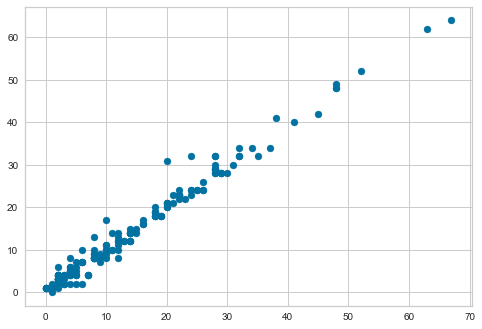

In [206]:
plt.scatter(dff['AbsHRBefore'],dff['AbsHRAfter'])

In [207]:
#The Ordinary Least Squares function from the statsmodel library
import statsmodels.formula.api as smf

fitd = smf.ols( formula = ' AbsHRAfter ~ AbsHRBefore', data = dff).fit()
print(fitd.summary())

                            OLS Regression Results                            
Dep. Variable:             AbsHRAfter   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     7407.
Date:                Thu, 08 Sep 2022   Prob (F-statistic):          1.72e-141
Time:                        11:40:42   Log-Likelihood:                -351.14
No. Observations:                 171   AIC:                             706.3
Df Residuals:                     169   BIC:                             712.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.5772      0.220      2.626      

Our regression function is $ \hat{u} =   0,99x + 0.52$, since $ \hat{\beta}_0 = 0.52 $ and $ \hat{\beta}_1 = 0,99$. We also understood, from the summary, that   $\widehat{se}(\widehat{\beta}_0) = 0.218 $ and $\widehat{se}(\widehat{\beta}_1) = 0.013$.

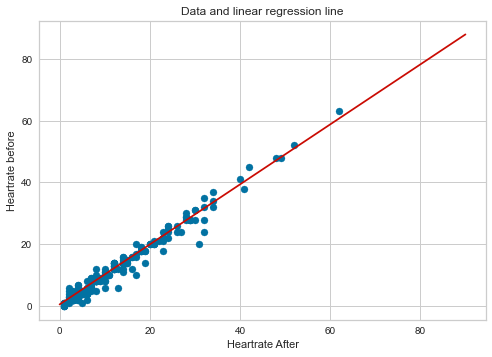

In [ ]:
plt.title('Data and linear regression line')
plt.ylabel('Heartrate before')
plt.xlabel('Heartrate After')

x = dff['AbsHRAfter']
y = dff['AbsHRBefore']
xx = np.linspace(0,90,1000)
#we write y as a function of x, having computed the regression function 
yy = 0.58 + 0.97*xx
#first we plot the simple linear regression, then with the scatter method we plot the points
plt.plot(xx,yy, 'r')
plt.scatter(x,y)
plt.show()

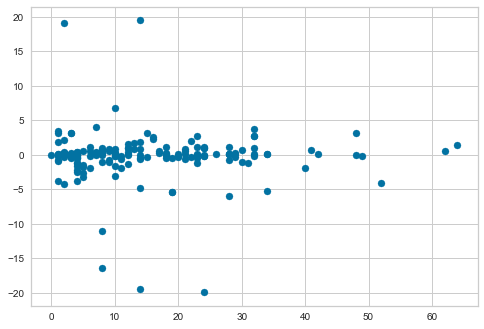

In [208]:
plt.scatter( dff["AbsHRAfter"],dff["DeltaPos"])

In [397]:
## BLUNDERS o OTTIME MOSSE
ndff =  dff[["AbsHRBefore","AbsHRAfter", "MoveS", "MovePGN","Time", "DeltaPos", 'Game', "Board",'Evaluation','AbsHRBefore_altro','AbsHRAfter_altro','Player']]



# ANALISI QUALITATIVA
Now let's try to see if it makes any sense to do a qualitative analysis.
We thought to carry this out in the following way:
First of all we want to find, among the already reduced moves, the ones that changed the position evaluation the most.

In the following cell, for each move we appended to the corresponding lists the following:
-  Highest difference from the heartrate of the player that made the move at time $ t $ in the interval $[t-10 , \; t]$
-  Highest difference from the heartrate of the player that made the move at time $ t $ in the interval $[t , \; t + 10]$
-  Highest difference from the heartrate of the player that didn't make the move at time $ t $ in the interval $[t-10 , \; t]$
-  Highest difference from the heartrate of the player that didn't make the move at time $ t $ in the interval $[t , \; t + 10]$

In the lists:
- `perdenti_prima`
- `perdenti_dopo`
- `vincenti_prima`
- `vincenti_dopo`

In the same cell we also append to `lista_c` all the moves that caused a change in absolute value, in the evaluation of the position of more than 3.0,
we expect this moves to be anyone of the following: good moves that gave a significant advantage to a player, bad mistakes that gave an advantage to the opponent. Now it's also important to underline that there could be changes in the position that signify potential opportunities that weren't exploited
from the players, this could depend on a number of factors like: overlooking a particular move, not understanding well the current position, lack of time or simply a lower skill level.

We therefore believe that the position evaluation of a chess engine would look a lot more alike to the position evaluation of a really expert player and obviously sees things in a very different way from the way our players did in the games.

Nonetheless we decided to analyse these key moments in the following cells asking each player how he felt during the game about that particular move or sequence of moves (also called _lines_ in chess)

We also displayed all the boards that met the aforementioned conditions, together with the position evaluation, position evaluation delta.


0
(18, AbsHRBefore                                                          6
AbsHRAfter                                                           7
MoveS                                                             Nge2
MovePGN                                                       ['g1e2']
Time                                                               116
DeltaPos                                                          0.58
Game                                                        Game0814-2
Board                r1bn1rk1/ppp2ppp/5b2/4p3/4P3/2N2P2/PPP1N1PP/2K...
Evaluation                                                       -0.64
AbsHRBefore_altro                                                   21
AbsHRAfter_altro                                                    18
Player                                                               w
Name: 18, dtype: object)


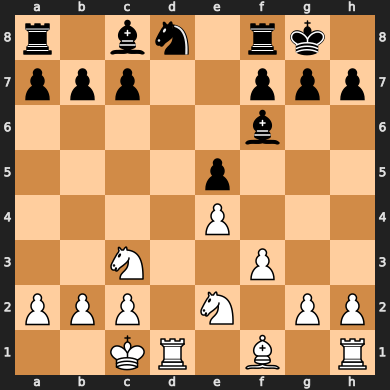

1
(19, AbsHRBefore                                                          9
AbsHRAfter                                                           7
MoveS                                                               c5
MovePGN                                                       ['c7c5']
Time                                                               139
DeltaPos                                                         -1.92
Game                                                        Game0814-2
Board                r1bn1rk1/pp3ppp/5b2/2p1p3/4P3/2N2P2/PPP1N1PP/2...
Evaluation                                                        1.28
AbsHRBefore_altro                                                    9
AbsHRAfter_altro                                                     6
Player                                                               b
Name: 19, dtype: object)


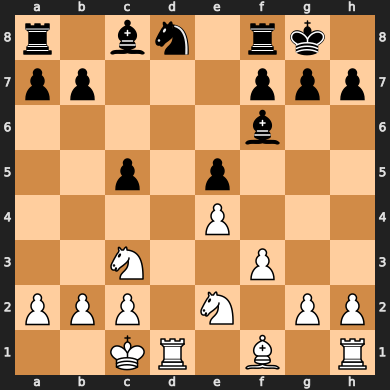

2
(20, AbsHRBefore                                                          8
AbsHRAfter                                                           8
MoveS                                                              Nd5
MovePGN                                                       ['c3d5']
Time                                                               164
DeltaPos                                                          0.26
Game                                                        Game0814-2
Board                r1bn1rk1/pp3ppp/5b2/2pNp3/4P3/5P2/PPP1N1PP/2KR...
Evaluation                                                        1.02
AbsHRBefore_altro                                                   13
AbsHRAfter_altro                                                    10
Player                                                               w
Name: 20, dtype: object)


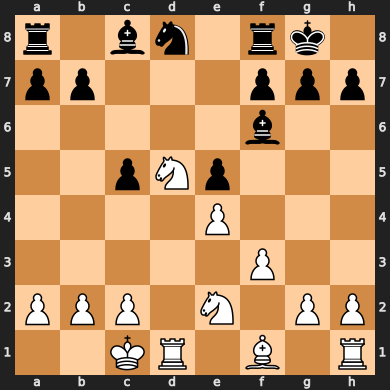

3
(21, AbsHRBefore                                                         12
AbsHRAfter                                                          16
MoveS                                                             Bg5+
MovePGN                                                       ['f6g5']
Time                                                               192
DeltaPos                                                          0.03
Game                                                        Game0814-2
Board                r1bn1rk1/pp3ppp/8/2pNp1b1/4P3/5P2/PPP1N1PP/2KR...
Evaluation                                                        0.99
AbsHRBefore_altro                                                   12
AbsHRAfter_altro                                                     7
Player                                                               b
Name: 21, dtype: object)


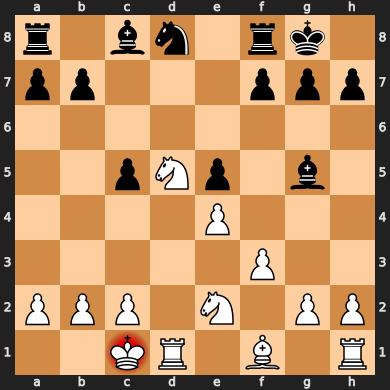

4
(30, AbsHRBefore                                                         14
AbsHRAfter                                                          12
MoveS                                                              Nd5
MovePGN                                                       ['f4d5']
Time                                                               293
DeltaPos                                                          0.56
Game                                                        Game0814-2
Board                r1br2k1/pp3ppp/2n5/2pN4/4P2P/8/PPP3P1/2KR1B1R ...
Evaluation                                                       -0.21
AbsHRBefore_altro                                                   14
AbsHRAfter_altro                                                    14
Player                                                               w
Name: 30, dtype: object)


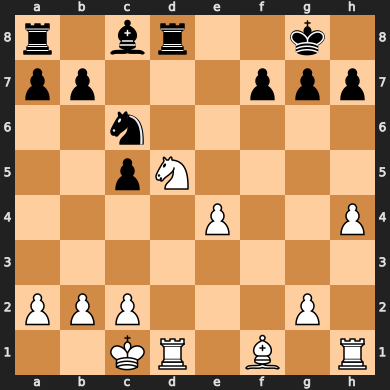

5
(31, AbsHRBefore                                                         20
AbsHRAfter                                                          17
MoveS                                                              Bg4
MovePGN                                                       ['c8g4']
Time                                                               311
DeltaPos                                                          0.27
Game                                                        Game0814-2
Board                r2r2k1/pp3ppp/2n5/2pN4/4P1bP/8/PPP3P1/2KR1B1R ...
Evaluation                                                       -0.48
AbsHRBefore_altro                                                   20
AbsHRAfter_altro                                                    13
Player                                                               b
Name: 31, dtype: object)


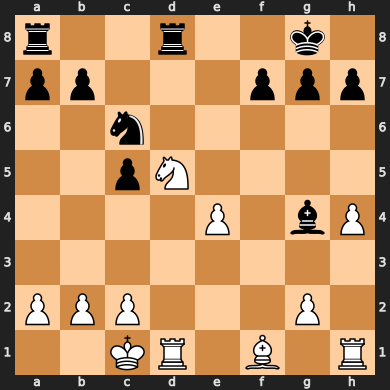

6
(32, AbsHRBefore                                                          9
AbsHRAfter                                                           8
MoveS                                                              Rd2
MovePGN                                                       ['d1d2']
Time                                                               353
DeltaPos                                                          0.15
Game                                                        Game0814-2
Board                r2r2k1/pp3ppp/2n5/2pN4/4P1bP/8/PPPR2P1/2K2B1R ...
Evaluation                                                       -0.63
AbsHRBefore_altro                                                   35
AbsHRAfter_altro                                                    36
Player                                                               w
Name: 32, dtype: object)


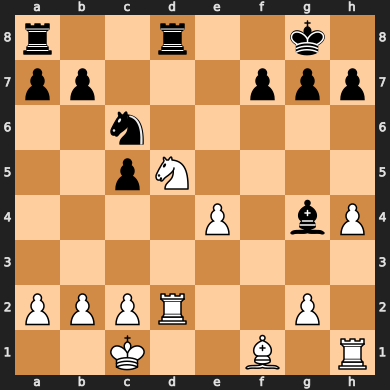

7
(37, AbsHRBefore                                                         12
AbsHRAfter                                                          10
MoveS                                                             Rxe8
MovePGN                                                       ['d8e8']
Time                                                               459
DeltaPos                                                         -0.18
Game                                                        Game0814-2
Board                4r1k1/pp3ppp/2n5/2p5/4P1bP/8/PPPR2P1/2K2B1R w ...
Evaluation                                                         5.5
AbsHRBefore_altro                                                   12
AbsHRAfter_altro                                                    10
Player                                                               b
Name: 37, dtype: object)


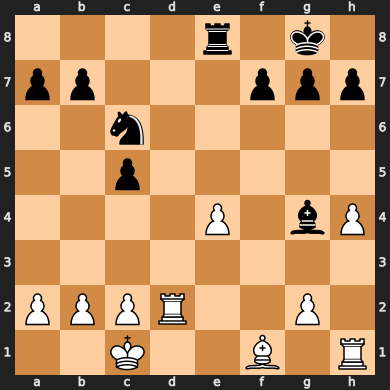

8
(38, AbsHRBefore                                                         22
AbsHRAfter                                                          23
MoveS                                                              Bc4
MovePGN                                                       ['f1c4']
Time                                                               498
DeltaPos                                                          1.06
Game                                                        Game0814-2
Board                4r1k1/pp3ppp/2n5/2p5/2B1P1bP/8/PPPR2P1/2K4R b ...
Evaluation                                                        4.44
AbsHRBefore_altro                                                   22
AbsHRAfter_altro                                                    18
Player                                                               w
Name: 38, dtype: object)


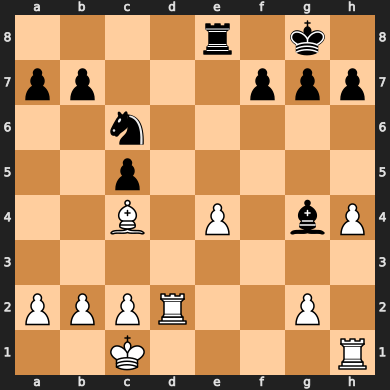

9
(39, AbsHRBefore                                                          3
AbsHRAfter                                                           4
MoveS                                                             Rxe4
MovePGN                                                       ['e8e4']
Time                                                               515
DeltaPos                                                         -0.46
Game                                                        Game0814-2
Board                6k1/pp3ppp/2n5/2p5/2B1r1bP/8/PPPR2P1/2K4R w - ...
Evaluation                                                         4.9
AbsHRBefore_altro                                                   19
AbsHRAfter_altro                                                    18
Player                                                               b
Name: 39, dtype: object)


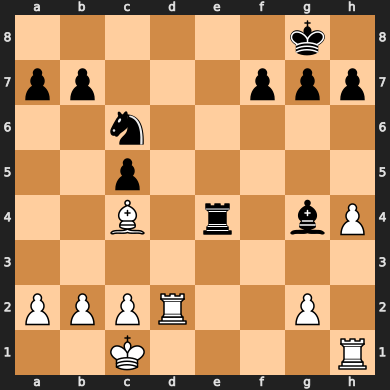

10
(40, AbsHRBefore                                                          6
AbsHRAfter                                                          10
MoveS                                                              Bd5
MovePGN                                                       ['c4d5']
Time                                                               531
DeltaPos                                                          0.26
Game                                                        Game0814-2
Board                6k1/pp3ppp/2n5/2pB4/4r1bP/8/PPPR2P1/2K4R b - -...
Evaluation                                                        4.64
AbsHRBefore_altro                                                    7
AbsHRAfter_altro                                                     6
Player                                                               w
Name: 40, dtype: object)


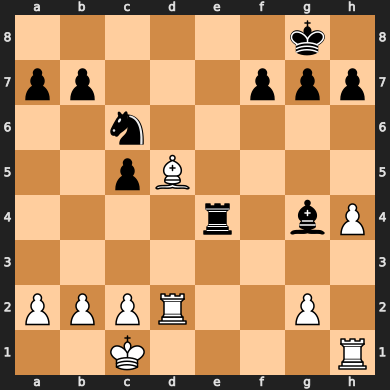

11
(41, AbsHRBefore                                                          3
AbsHRAfter                                                           4
MoveS                                                              Rd4
MovePGN                                                       ['e4d4']
Time                                                               554
DeltaPos                                                          -1.2
Game                                                        Game0814-2
Board                6k1/pp3ppp/2n5/2pB4/3r2bP/8/PPPR2P1/2K4R w - -...
Evaluation                                                        5.84
AbsHRBefore_altro                                                   12
AbsHRAfter_altro                                                    10
Player                                                               b
Name: 41, dtype: object)


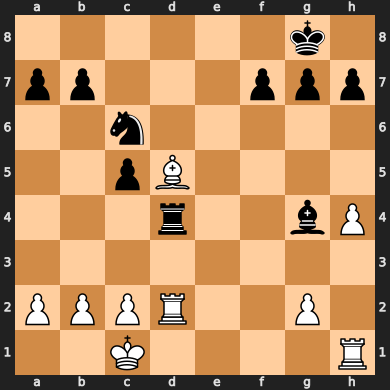

12
(56, AbsHRBefore                                                    14
AbsHRAfter                                                     14
MoveS                                                         Rb6
MovePGN                                                  ['c6b6']
Time                                                          707
DeltaPos                                                     0.32
Game                                                   Game0814-2
Board                6k1/5pp1/1R6/p6p/7P/3b4/PP4P1/2K5 b - - 1 29
Evaluation                                                   7.57
AbsHRBefore_altro                                              14
AbsHRAfter_altro                                               19
Player                                                          w
Name: 56, dtype: object)


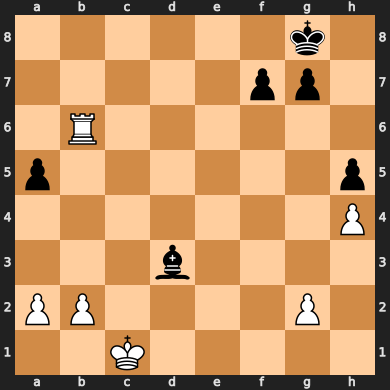

13
(104, AbsHRBefore                                                          5
AbsHRAfter                                                           4
MoveS                                                              Qe2
MovePGN                                                       ['d1e2']
Time                                                               182
DeltaPos                                                          0.56
Game                                                        Game0816-6
Board                rn2kb1r/pp2qppp/5n2/1N1pN3/8/8/PPPPQPPP/R1B1K2...
Evaluation                                                        2.37
AbsHRBefore_altro                                                    5
AbsHRAfter_altro                                                    17
Player                                                               w
Name: 104, dtype: object)


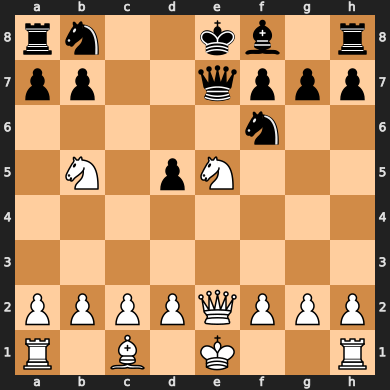

14
(105, AbsHRBefore                                                          3
AbsHRAfter                                                           4
MoveS                                                              Nc6
MovePGN                                                       ['b8c6']
Time                                                               276
DeltaPos                                                         -2.84
Game                                                        Game0816-6
Board                r3kb1r/pp2qppp/2n2n2/1N1pN3/8/8/PPPPQPPP/R1B1K...
Evaluation                                                        5.21
AbsHRBefore_altro                                                   14
AbsHRAfter_altro                                                    14
Player                                                               b
Name: 105, dtype: object)


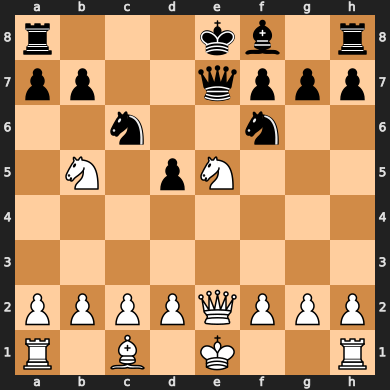

15
(108, AbsHRBefore                                                         20
AbsHRAfter                                                          20
MoveS                                                             Nxc6
MovePGN                                                       ['e5c6']
Time                                                               380
DeltaPos                                                          0.04
Game                                                        Game0816-6
Board                r3kb1r/1p2qppp/p1N2n2/1N1p4/3P4/8/PPP1QPPP/R1B...
Evaluation                                                        1.81
AbsHRBefore_altro                                                   20
AbsHRAfter_altro                                                    11
Player                                                               w
Name: 108, dtype: object)


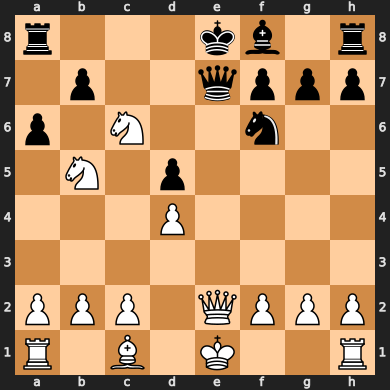

16
(112, AbsHRBefore                                                         18
AbsHRAfter                                                          23
MoveS                                                              Ne5
MovePGN                                                       ['c6e5']
Time                                                               451
DeltaPos                                                          0.11
Game                                                        Game0816-6
Board                r3kb1r/1p3ppp/5n2/1p1pN3/3P4/8/PPP1KPPP/R1B4R ...
Evaluation                                                        1.61
AbsHRBefore_altro                                                   18
AbsHRAfter_altro                                                    10
Player                                                               w
Name: 112, dtype: object)


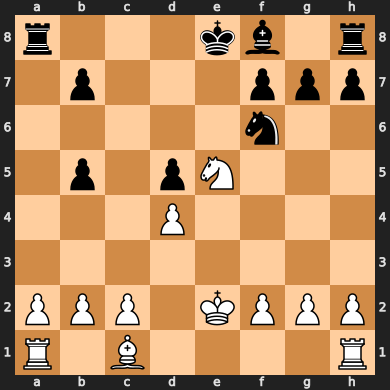

17
(118, AbsHRBefore                                                         13
AbsHRAfter                                                          12
MoveS                                                              Bg5
MovePGN                                                       ['c1g5']
Time                                                               518
DeltaPos                                                          0.83
Game                                                        Game0816-6
Board                r3r1k1/1p3ppp/3b1n2/1p1pN1B1/3P4/8/PPP2PPP/R3R...
Evaluation                                                        0.98
AbsHRBefore_altro                                                   13
AbsHRAfter_altro                                                    10
Player                                                               w
Name: 118, dtype: object)


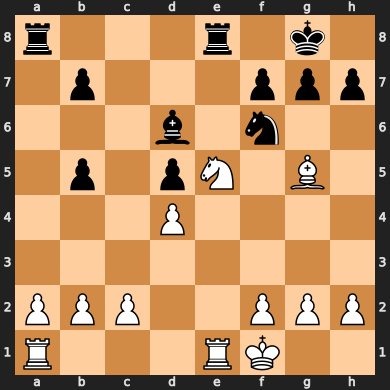

18
(122, AbsHRBefore                                                          8
AbsHRAfter                                                           6
MoveS                                                             Rad1
MovePGN                                                       ['a1d1']
Time                                                               574
DeltaPos                                                          0.01
Game                                                        Game0816-6
Board                r3r1k1/1p1n1ppp/8/1p1pP1B1/8/8/PPP2PPP/3RRK2 b...
Evaluation                                                        2.93
AbsHRBefore_altro                                                    8
AbsHRAfter_altro                                                     4
Player                                                               w
Name: 122, dtype: object)


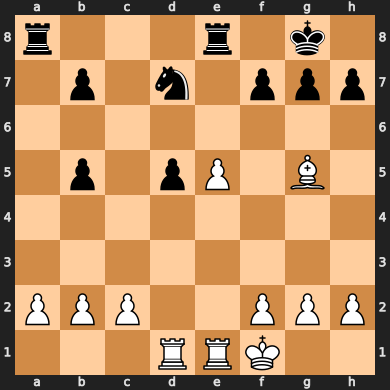

19
(123, AbsHRBefore                                                          5
AbsHRAfter                                                           3
MoveS                                                              Nb6
MovePGN                                                       ['d7b6']
Time                                                               599
DeltaPos                                                         -0.31
Game                                                        Game0816-6
Board                r3r1k1/1p3ppp/1n6/1p1pP1B1/8/8/PPP2PPP/3RRK2 w...
Evaluation                                                        3.24
AbsHRBefore_altro                                                   12
AbsHRAfter_altro                                                    11
Player                                                               b
Name: 123, dtype: object)


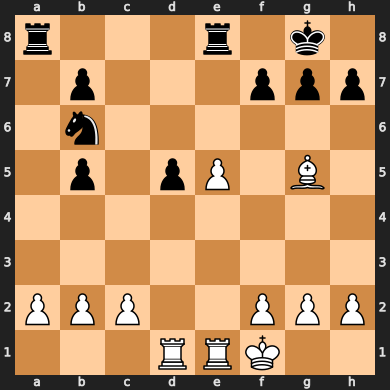

20
(172, AbsHRBefore                                                          9
AbsHRAfter                                                           8
MoveS                                                              Nd4
MovePGN                                                       ['f5d4']
Time                                                               213
DeltaPos                                                          0.04
Game                                                        Game0816-1
Board                2kr1b1r/p4ppp/2p5/4P3/3n4/2N5/PP3PPP/R1B1K2R w...
Evaluation                                                        0.68
AbsHRBefore_altro                                                    9
AbsHRAfter_altro                                                     3
Player                                                               b
Name: 172, dtype: object)


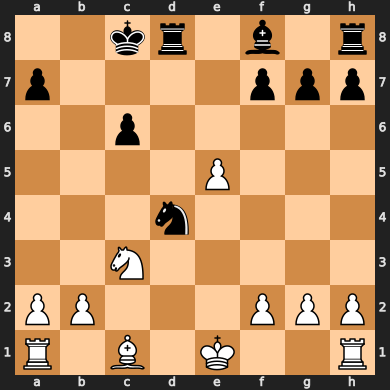

21
(173, AbsHRBefore                                                         14
AbsHRAfter                                                          19
MoveS                                                              O-O
MovePGN                                                       ['e1g1']
Time                                                               230
DeltaPos                                                          0.13
Game                                                        Game0816-1
Board                2kr1b1r/p4ppp/2p5/4P3/3n4/2N5/PP3PPP/R1B2RK1 b...
Evaluation                                                        0.81
AbsHRBefore_altro                                                   14
AbsHRAfter_altro                                                     8
Player                                                               w
Name: 173, dtype: object)


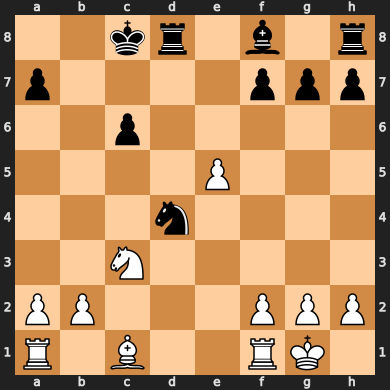

22
(180, AbsHRBefore                                                          2
AbsHRAfter                                                           2
MoveS                                                              Bc5
MovePGN                                                       ['e7c5']
Time                                                               323
DeltaPos                                                          0.79
Game                                                        Game0816-1
Board                2kr3r/p4ppp/2p5/2b1P3/8/2N1P3/PP4PP/2R2RK1 w -...
Evaluation                                                        0.97
AbsHRBefore_altro                                                    4
AbsHRAfter_altro                                                     6
Player                                                               b
Name: 180, dtype: object)


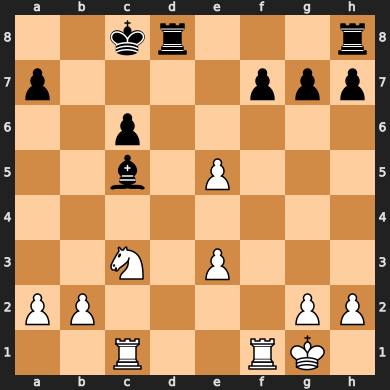

23
(184, AbsHRBefore                                                         16
AbsHRAfter                                                          14
MoveS                                                              Bb4
MovePGN                                                       ['c5b4']
Time                                                               456
DeltaPos                                                         -0.75
Game                                                        Game0816-1
Board                2krr3/p4ppp/2p5/4P3/1b2N3/4P3/PP4PP/2R1R1K1 w ...
Evaluation                                                        2.31
AbsHRBefore_altro                                                   16
AbsHRAfter_altro                                                     8
Player                                                               b
Name: 184, dtype: object)


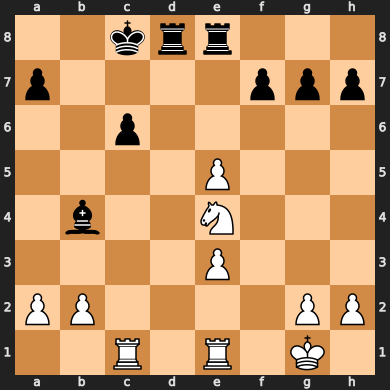

24
(188, AbsHRBefore                                                         29
AbsHRAfter                                                          28
MoveS                                                              Ba5
MovePGN                                                       ['b4a5']
Time                                                               537
DeltaPos                                                         -6.05
Game                                                        Game0816-1
Board                3rr3/pk3ppp/2R5/b3P3/4N3/4P3/PP4PP/2R3K1 w - -...
Evaluation                                                        7.25
AbsHRBefore_altro                                                   29
AbsHRAfter_altro                                                     5
Player                                                               b
Name: 188, dtype: object)


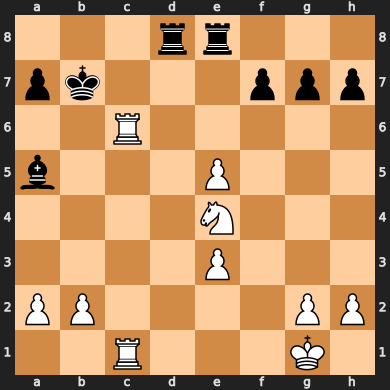

25
(192, AbsHRBefore                                                     12
AbsHRAfter                                                      12
MoveS                                                         Rxe3
MovePGN                                                   ['e8e3']
Time                                                           644
DeltaPos                                                     -0.51
Game                                                    Game0816-1
Board                8/pk3ppp/2RP4/b7/8/4r3/PP4PP/2R3K1 w - - 0 25
Evaluation                                                    6.95
AbsHRBefore_altro                                               12
AbsHRAfter_altro                                                 9
Player                                                           b
Name: 192, dtype: object)


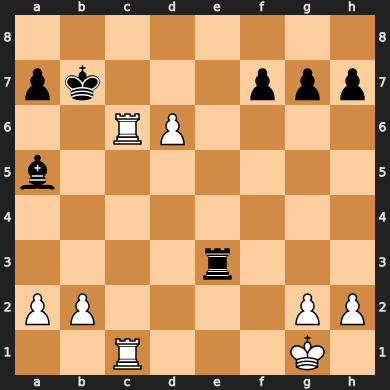

26
(193, AbsHRBefore                                                       6
AbsHRAfter                                                        6
MoveS                                                            d7
MovePGN                                                    ['d6d7']
Time                                                            683
DeltaPos                                                       0.86
Game                                                     Game0816-1
Board                8/pk1P1ppp/2R5/b7/8/4r3/PP4PP/2R3K1 b - - 0 25
Evaluation                                                     6.09
AbsHRBefore_altro                                                11
AbsHRAfter_altro                                                 12
Player                                                            w
Name: 193, dtype: object)


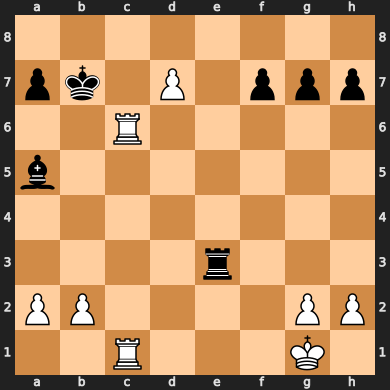

27
(197, AbsHRBefore                                                  1
AbsHRAfter                                                   5
MoveS                                                      Re7
MovePGN                                               ['e1e7']
Time                                                       730
DeltaPos                                                  0.27
Game                                                Game0816-1
Board                8/p2PRppp/2k5/b7/8/8/PP4PP/6K1 b - - 1 27
Evaluation                                                8.39
AbsHRBefore_altro                                            9
AbsHRAfter_altro                                            13
Player                                                       w
Name: 197, dtype: object)


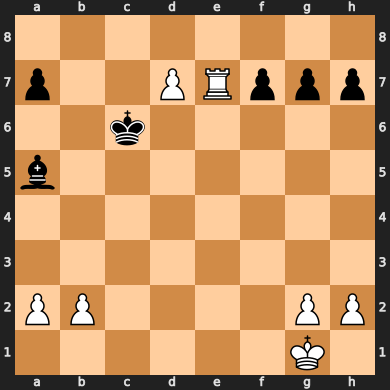

28
(220, AbsHRBefore                                                         19
AbsHRAfter                                                          18
MoveS                                                              Nf3
MovePGN                                                       ['d4f3']
Time                                                                84
DeltaPos                                                          0.04
Game                                                        Game0816-7
Board                rnbqk2r/pp2ppbp/3p1np1/8/4P3/2NB1N2/PPP2PPP/R1...
Evaluation                                                           0
AbsHRBefore_altro                                                   19
AbsHRAfter_altro                                                    13
Player                                                               w
Name: 220, dtype: object)


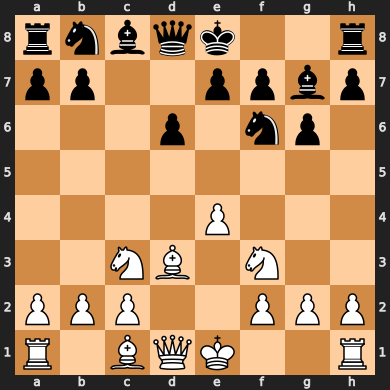

29
(221, AbsHRBefore                                                         10
AbsHRAfter                                                          10
MoveS                                                              Bg4
MovePGN                                                       ['c8g4']
Time                                                               103
DeltaPos                                                          0.02
Game                                                        Game0816-7
Board                rn1qk2r/pp2ppbp/3p1np1/8/4P1b1/2NB1N2/PPP2PPP/...
Evaluation                                                       -0.02
AbsHRBefore_altro                                                   11
AbsHRAfter_altro                                                    16
Player                                                               b
Name: 221, dtype: object)


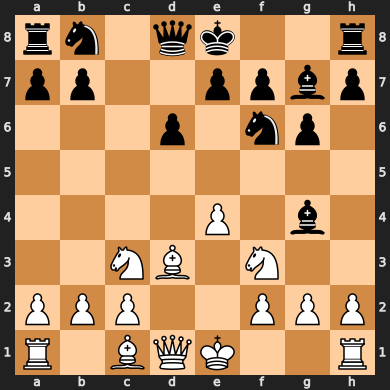

30
(222, AbsHRBefore                                                         12
AbsHRAfter                                                          12
MoveS                                                               h3
MovePGN                                                       ['h2h3']
Time                                                               116
DeltaPos                                                           0.1
Game                                                        Game0816-7
Board                rn1qk2r/pp2ppbp/3p1np1/8/4P1b1/2NB1N1P/PPP2PP1...
Evaluation                                                        0.08
AbsHRBefore_altro                                                   12
AbsHRAfter_altro                                                     9
Player                                                               w
Name: 222, dtype: object)


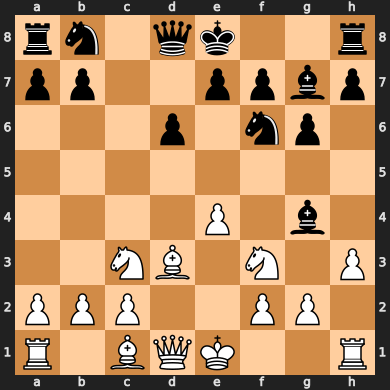

31
(237, AbsHRBefore                                                         26
AbsHRAfter                                                          24
MoveS                                                              Qb6
MovePGN                                                       ['d8b6']
Time                                                               234
DeltaPos                                                          0.08
Game                                                        Game0816-7
Board                r4rk1/4ppbp/pq1p1np1/1p6/4P3/1PNQ3P/1PP2PP1/R1...
Evaluation                                                       -0.48
AbsHRBefore_altro                                                   26
AbsHRAfter_altro                                                     8
Player                                                               b
Name: 237, dtype: object)


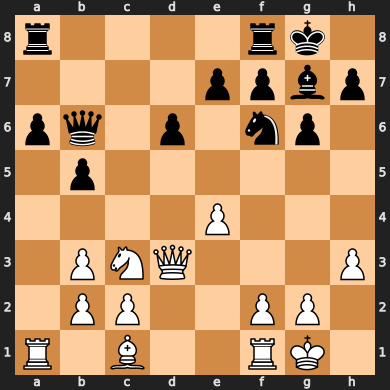

32
(238, AbsHRBefore                                                         16
AbsHRAfter                                                          17
MoveS                                                              Be3
MovePGN                                                       ['c1e3']
Time                                                               245
DeltaPos                                                          0.03
Game                                                        Game0816-7
Board                r4rk1/4ppbp/pq1p1np1/1p6/4P3/1PNQB2P/1PP2PP1/R...
Evaluation                                                       -0.45
AbsHRBefore_altro                                                   16
AbsHRAfter_altro                                                    12
Player                                                               w
Name: 238, dtype: object)


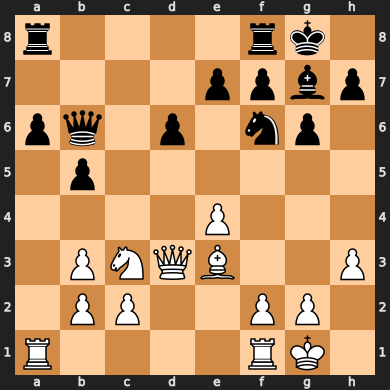

33
(239, AbsHRBefore                                                         14
AbsHRAfter                                                          14
MoveS                                                              Qc6
MovePGN                                                       ['b6c6']
Time                                                               257
DeltaPos                                                         -0.63
Game                                                        Game0816-7
Board                r4rk1/4ppbp/p1qp1np1/1p6/4P3/1PNQB2P/1PP2PP1/R...
Evaluation                                                        0.18
AbsHRBefore_altro                                                   16
AbsHRAfter_altro                                                    14
Player                                                               b
Name: 239, dtype: object)


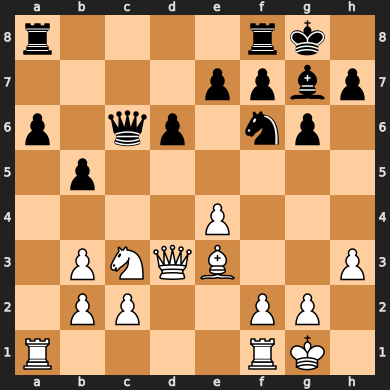

34
(245, AbsHRBefore                                                          2
AbsHRAfter                                                           3
MoveS                                                               b4
MovePGN                                                       ['b5b4']
Time                                                               365
DeltaPos                                                         -0.64
Game                                                        Game0816-7
Board                r4rk1/3qppbp/p2p2p1/3P4/1p6/1PPQB2P/1P3PP1/R4R...
Evaluation                                                        0.75
AbsHRBefore_altro                                                   11
AbsHRAfter_altro                                                     8
Player                                                               b
Name: 245, dtype: object)


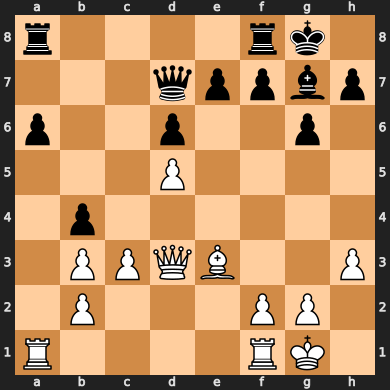

35
(252, AbsHRBefore                                                          3
AbsHRAfter                                                           2
MoveS                                                              Qc2
MovePGN                                                       ['d2c2']
Time                                                               475
DeltaPos                                                          2.24
Game                                                        Game0816-7
Board                1rr3k1/3qppbp/p2p2p1/3P4/8/1PP1B2P/2Q2PP1/2R2R...
Evaluation                                                       -2.74
AbsHRBefore_altro                                                   11
AbsHRAfter_altro                                                    10
Player                                                               w
Name: 252, dtype: object)


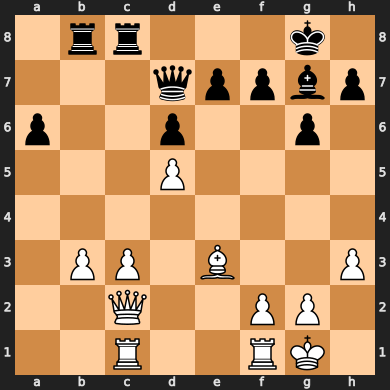

36
(253, AbsHRBefore                                                         31
AbsHRAfter                                                          30
MoveS                                                              Qb5
MovePGN                                                       ['d7b5']
Time                                                               509
DeltaPos                                                         -1.31
Game                                                        Game0816-7
Board                1rr3k1/4ppbp/p2p2p1/1q1P4/8/1PP1B2P/2Q2PP1/2R2...
Evaluation                                                       -1.43
AbsHRBefore_altro                                                   31
AbsHRAfter_altro                                                     4
Player                                                               b
Name: 253, dtype: object)


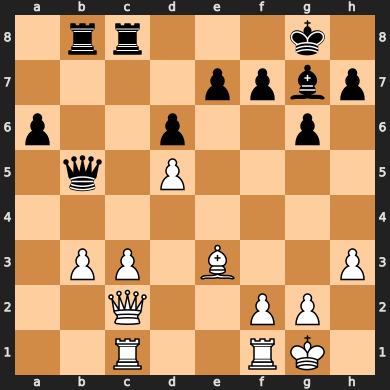

37
(256, AbsHRBefore                                                          1
AbsHRAfter                                                           1
MoveS                                                              Bd2
MovePGN                                                       ['e3d2']
Time                                                               595
DeltaPos                                                          1.78
Game                                                        Game0816-7
Board                1rr3k1/4ppbp/p2p2p1/3q4/1P6/2P4P/2QB1PP1/2R2RK...
Evaluation                                                       -3.19
AbsHRBefore_altro                                                   10
AbsHRAfter_altro                                                    13
Player                                                               w
Name: 256, dtype: object)


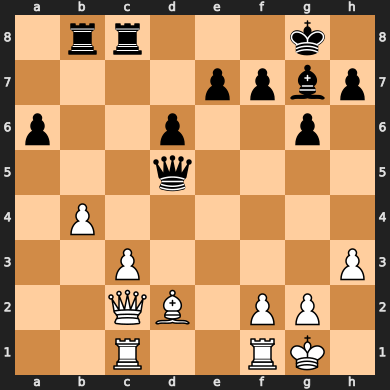

38
(257, AbsHRBefore                                                         41
AbsHRAfter                                                          40
MoveS                                                               a5
MovePGN                                                       ['a6a5']
Time                                                               624
DeltaPos                                                         -2.21
Game                                                        Game0816-7
Board                1rr3k1/4ppbp/3p2p1/p2q4/1P6/2P4P/2QB1PP1/2R2RK...
Evaluation                                                       -0.98
AbsHRBefore_altro                                                   41
AbsHRAfter_altro                                                     7
Player                                                               b
Name: 257, dtype: object)


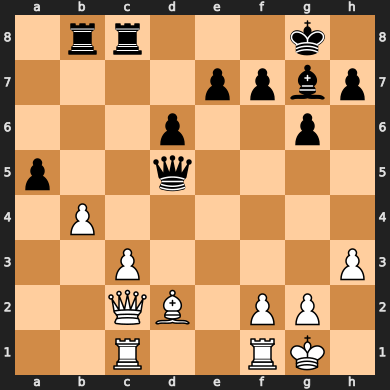

39
(260, AbsHRBefore                                                         14
AbsHRAfter                                                          12
MoveS                                                               c4
MovePGN                                                       ['c3c4']
Time                                                               650
DeltaPos                                                          0.07
Game                                                        Game0816-7
Board                1rr3k1/4ppbp/3p2p1/q7/2P5/7P/2QB1PP1/2R2RK1 b ...
Evaluation                                                       -2.34
AbsHRBefore_altro                                                   15
AbsHRAfter_altro                                                    13
Player                                                               w
Name: 260, dtype: object)


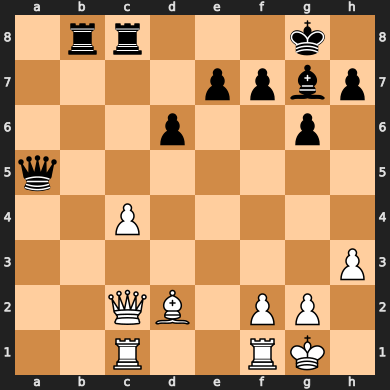

40
(261, AbsHRBefore                                                          2
AbsHRAfter                                                           3
MoveS                                                              Qc5
MovePGN                                                       ['a5c5']
Time                                                               673
DeltaPos                                                          0.06
Game                                                        Game0816-7
Board                1rr3k1/4ppbp/3p2p1/2q5/2P5/7P/2QB1PP1/2R2RK1 w...
Evaluation                                                        -2.4
AbsHRBefore_altro                                                    9
AbsHRAfter_altro                                                    14
Player                                                               b
Name: 261, dtype: object)


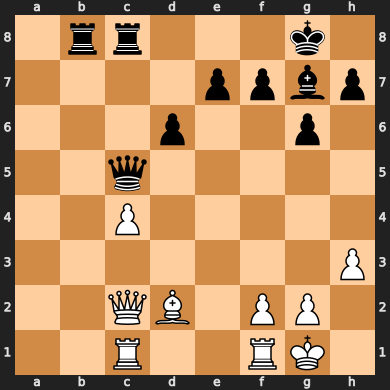

41
(262, AbsHRBefore                                                         15
AbsHRAfter                                                          14
MoveS                                                             Rfe1
MovePGN                                                       ['f1e1']
Time                                                               691
DeltaPos                                                          1.53
Game                                                        Game0816-7
Board                1rr3k1/4ppbp/3p2p1/2q5/2P5/7P/2QB1PP1/2R1R1K1 ...
Evaluation                                                       -3.93
AbsHRBefore_altro                                                   15
AbsHRAfter_altro                                                    10
Player                                                               w
Name: 262, dtype: object)


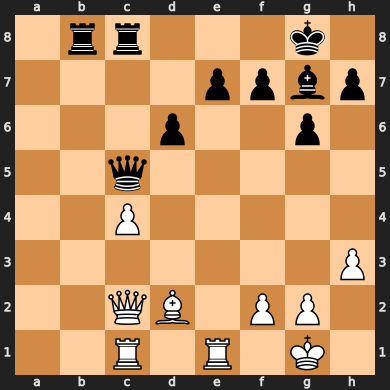

42
(263, AbsHRBefore                                                          2
AbsHRAfter                                                           4
MoveS                                                               e6
MovePGN                                                       ['e7e6']
Time                                                               709
DeltaPos                                                         -2.47
Game                                                        Game0816-7
Board                1rr3k1/5pbp/3pp1p1/2q5/2P5/7P/2QB1PP1/2R1R1K1 ...
Evaluation                                                       -1.46
AbsHRBefore_altro                                                    8
AbsHRAfter_altro                                                     8
Player                                                               b
Name: 263, dtype: object)


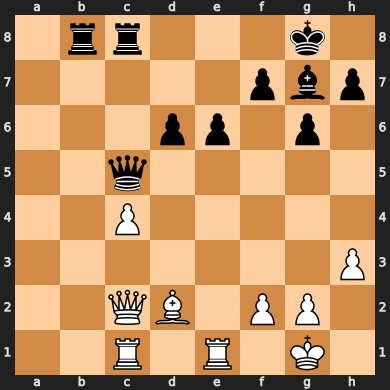

43
(264, AbsHRBefore                                                          0
AbsHRAfter                                                           1
MoveS                                                              Bf4
MovePGN                                                       ['d2f4']
Time                                                               722
DeltaPos                                                           3.2
Game                                                        Game0816-7
Board                1rr3k1/5pbp/3pp1p1/2q5/2P2B2/7P/2Q2PP1/2R1R1K1...
Evaluation                                                       -4.66
AbsHRBefore_altro                                                    2
AbsHRAfter_altro                                                     2
Player                                                               w
Name: 264, dtype: object)


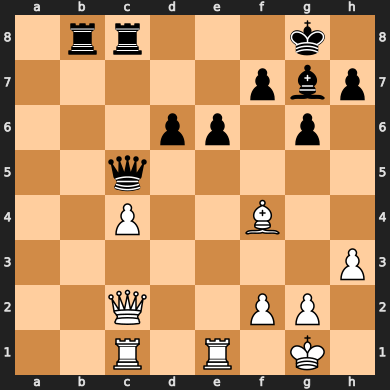

44
(265, AbsHRBefore                                                          4
AbsHRAfter                                                           5
MoveS                                                              Rb4
MovePGN                                                       ['b8b4']
Time                                                               742
DeltaPos                                                         -2.71
Game                                                        Game0816-7
Board                2r3k1/5pbp/3pp1p1/2q5/1rP2B2/7P/2Q2PP1/2R1R1K1...
Evaluation                                                       -1.95
AbsHRBefore_altro                                                    4
AbsHRAfter_altro                                                     4
Player                                                               b
Name: 265, dtype: object)


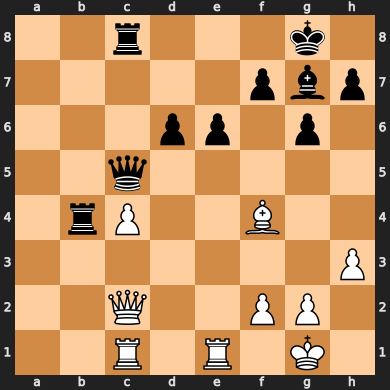

45
(266, AbsHRBefore                                                          2
AbsHRAfter                                                           3
MoveS                                                              Re2
MovePGN                                                       ['e1e2']
Time                                                               797
DeltaPos                                                          3.09
Game                                                        Game0816-7
Board                2r3k1/5pbp/3pp1p1/2q5/1rP2B2/7P/2Q1RPP1/2R3K1 ...
Evaluation                                                       -5.04
AbsHRBefore_altro                                                   12
AbsHRAfter_altro                                                     5
Player                                                               w
Name: 266, dtype: object)


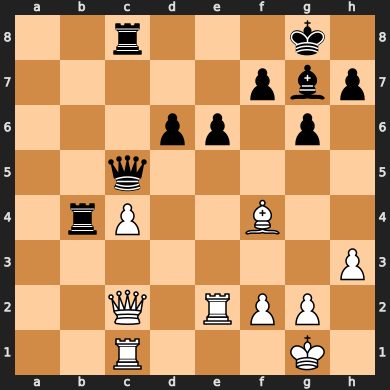

46
(276, AbsHRBefore                                                    7
AbsHRAfter                                                     4
MoveS                                                        Ba3
MovePGN                                                 ['d6a3']
Time                                                         882
DeltaPos                                                    0.02
Game                                                  Game0816-7
Board                6k1/5pbp/2r1p1p1/8/8/B6P/4RPPK/8 b - - 4 35
Evaluation                                                  -0.2
AbsHRBefore_altro                                              7
AbsHRAfter_altro                                              13
Player                                                         w
Name: 276, dtype: object)


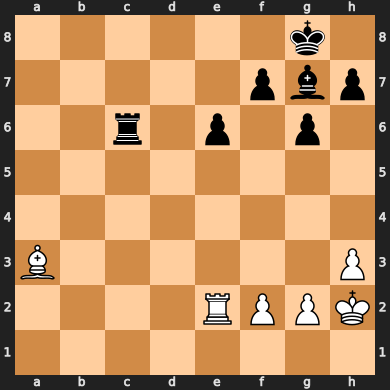

47
(277, AbsHRBefore                                                     28
AbsHRAfter                                                      28
MoveS                                                          Bd4
MovePGN                                                   ['g7d4']
Time                                                           898
DeltaPos                                                      0.05
Game                                                    Game0816-7
Board                6k1/5p1p/2r1p1p1/8/3b4/B6P/4RPPK/8 w - - 5 36
Evaluation                                                   -0.25
AbsHRBefore_altro                                               28
AbsHRAfter_altro                                                 3
Player                                                           b
Name: 277, dtype: object)


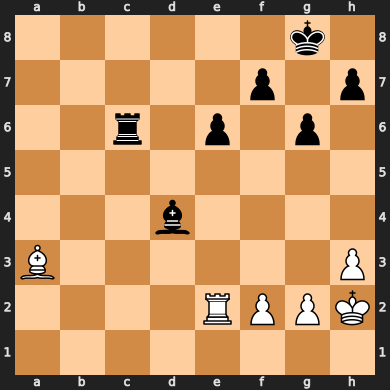

48
(280, AbsHRBefore                                                       2
AbsHRAfter                                                        3
MoveS                                                           Bc1
MovePGN                                                    ['a3c1']
Time                                                            963
DeltaPos                                                       0.17
Game                                                     Game0816-7
Board                6k1/5p1p/r3p1p1/8/3b4/6PP/4RP1K/2B5 b - - 2 37
Evaluation                                                    -0.52
AbsHRBefore_altro                                                 3
AbsHRAfter_altro                                                  2
Player                                                            w
Name: 280, dtype: object)


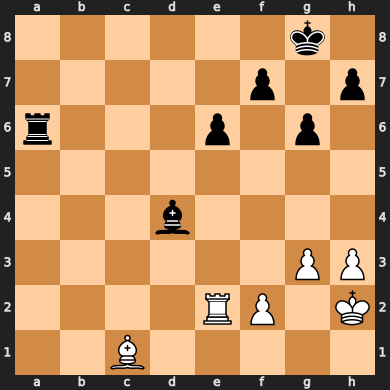

49
(285, AbsHRBefore                                                   18
AbsHRAfter                                                    19
MoveS                                                        Bd6
MovePGN                                                 ['c5d6']
Time                                                        1032
DeltaPos                                                   -5.33
Game                                                  Game0816-7
Board                8/5pkp/r2bp1p1/4R3/8/5PPP/7K/2B5 w - - 3 40
Evaluation                                                 -0.48
AbsHRBefore_altro                                             18
AbsHRAfter_altro                                              10
Player                                                         b
Name: 285, dtype: object)


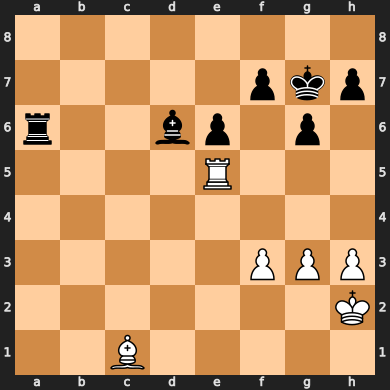

50
(293, AbsHRBefore                                                   19
AbsHRAfter                                                    18
MoveS                                                         f6
MovePGN                                                 ['f7f6']
Time                                                        1123
DeltaPos                                                   -0.02
Game                                                  Game0816-7
Board                8/4k1Bp/2rbppp1/8/8/5PPP/4R1K1/8 w - - 0 44
Evaluation                                                 -0.75
AbsHRBefore_altro                                             19
AbsHRAfter_altro                                              24
Player                                                         b
Name: 293, dtype: object)


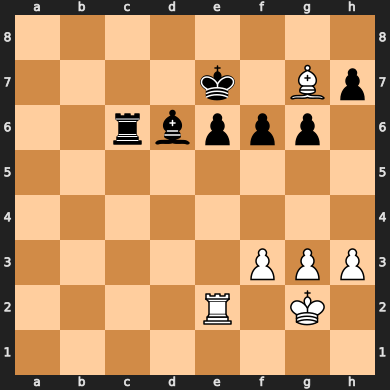

51
(294, AbsHRBefore                                                     28
AbsHRAfter                                                      32
MoveS                                                           g4
MovePGN                                                   ['g3g4']
Time                                                          1143
DeltaPos                                                       2.7
Game                                                    Game0816-7
Board                8/4k1Bp/2rbppp1/8/6P1/5P1P/4R1K1/8 b - - 0 44
Evaluation                                                   -3.45
AbsHRBefore_altro                                               28
AbsHRAfter_altro                                                17
Player                                                           w
Name: 294, dtype: object)


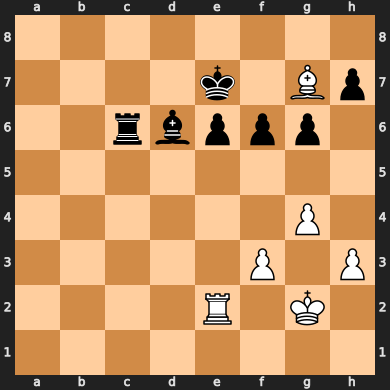

52
(327, AbsHRBefore                                                          9
AbsHRAfter                                                           8
MoveS                                                              Qd7
MovePGN                                                       ['d8d7']
Time                                                               101
DeltaPos                                                         -1.07
Game                                                        Game0813-3
Board                r3k2r/pppq1pbp/3p1np1/4p3/4P3/1PNP1QPb/P1P2P1P...
Evaluation                                                       -7.78
AbsHRBefore_altro                                                   17
AbsHRAfter_altro                                                    13
Player                                                               b
Name: 327, dtype: object)


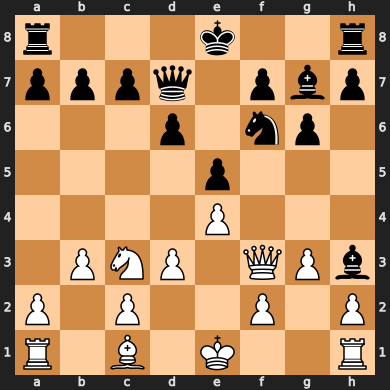

53
(328, AbsHRBefore                                                          2
AbsHRAfter                                                           6
MoveS                                                              Ne2
MovePGN                                                       ['c3e2']
Time                                                               124
DeltaPos                                                          1.19
Game                                                        Game0813-3
Board                r3k2r/pppq1pbp/3p1np1/4p3/4P3/1P1P1QPb/P1P1NP1...
Evaluation                                                       -8.97
AbsHRBefore_altro                                                    3
AbsHRAfter_altro                                                     3
Player                                                               w
Name: 328, dtype: object)


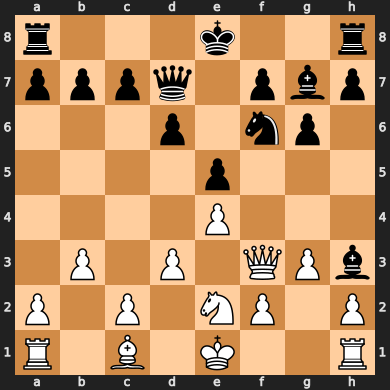

54
(406, AbsHRBefore                                                         14
AbsHRAfter                                                          14
MoveS                                                              Nh4
MovePGN                                                       ['f3h4']
Time                                                               157
DeltaPos                                                          0.81
Game                                                        Game0813-4
Board                rnb1qrk1/ppp2p1p/3p1p2/8/2B1P2N/2N5/PPP2PPP/R2...
Evaluation                                                        9.34
AbsHRBefore_altro                                                   14
AbsHRAfter_altro                                                     8
Player                                                               w
Name: 406, dtype: object)


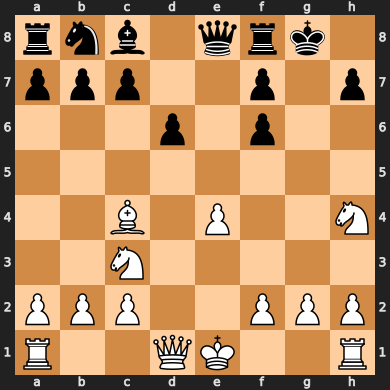

55
(407, AbsHRBefore                                                          2
AbsHRAfter                                                           3
MoveS                                                              Kh8
MovePGN                                                       ['g8h8']
Time                                                               173
DeltaPos                                                         -0.37
Game                                                        Game0813-4
Board                rnb1qr1k/ppp2p1p/3p1p2/8/2B1P2N/2N5/PPP2PPP/R2...
Evaluation                                                        9.71
AbsHRBefore_altro                                                   13
AbsHRAfter_altro                                                    12
Player                                                               b
Name: 407, dtype: object)


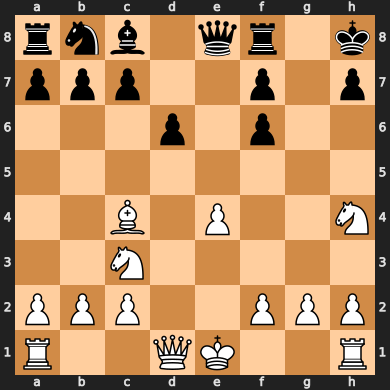

56
(412, AbsHRBefore                                                          8
AbsHRAfter                                                           8
MoveS                                                               g4
MovePGN                                                       ['g2g4']
Time                                                               267
DeltaPos                                                          0.91
Game                                                        Game0813-4
Board                rnb3rk/ppp1qp1p/3p1p2/8/2BQP1PN/2N2P2/PPP4P/R3...
Evaluation                                                        8.24
AbsHRBefore_altro                                                    8
AbsHRAfter_altro                                                     4
Player                                                               w
Name: 412, dtype: object)


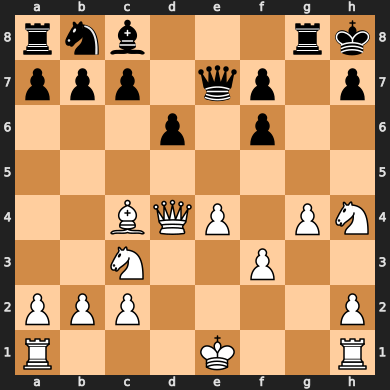

57
(413, AbsHRBefore                                                          2
AbsHRAfter                                                           3
MoveS                                                              Nc6
MovePGN                                                       ['b8c6']
Time                                                               280
DeltaPos                                                         -0.41
Game                                                        Game0813-4
Board                r1b3rk/ppp1qp1p/2np1p2/8/2BQP1PN/2N2P2/PPP4P/R...
Evaluation                                                        8.65
AbsHRBefore_altro                                                    9
AbsHRAfter_altro                                                    10
Player                                                               b
Name: 413, dtype: object)


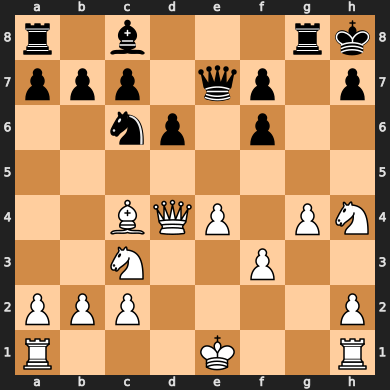

58
(414, AbsHRBefore                                                          4
AbsHRAfter                                                           5
MoveS                                                              Qd5
MovePGN                                                       ['d4d5']
Time                                                               324
DeltaPos                                                           5.7
Game                                                        Game0813-4
Board                r1b3rk/ppp1qp1p/2np1p2/3Q4/2B1P1PN/2N2P2/PPP4P...
Evaluation                                                        2.95
AbsHRBefore_altro                                                   17
AbsHRAfter_altro                                                    16
Player                                                               w
Name: 414, dtype: object)


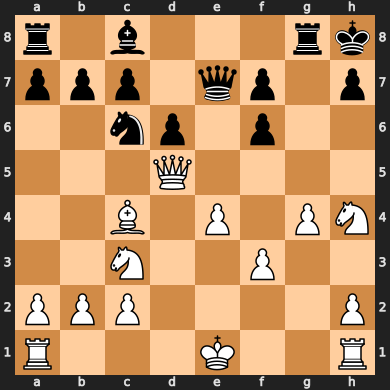

59
(415, AbsHRBefore                                                         21
AbsHRAfter                                                          22
MoveS                                                              Nb4
MovePGN                                                       ['c6b4']
Time                                                               336
DeltaPos                                                          -5.3
Game                                                        Game0813-4
Board                r1b3rk/ppp1qp1p/3p1p2/3Q4/1nB1P1PN/2N2P2/PPP4P...
Evaluation                                                        8.25
AbsHRBefore_altro                                                   21
AbsHRAfter_altro                                                     5
Player                                                               b
Name: 415, dtype: object)


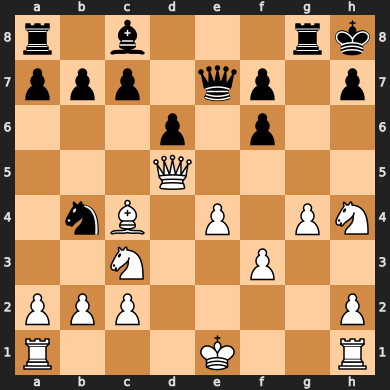

60
(416, AbsHRBefore                                                          6
AbsHRAfter                                                          13
MoveS                                                              Qd2
MovePGN                                                       ['d5d2']
Time                                                               360
DeltaPos                                                          1.74
Game                                                        Game0813-4
Board                r1b3rk/ppp1qp1p/3p1p2/8/1nB1P1PN/2N2P2/PPPQ3P/...
Evaluation                                                        6.51
AbsHRBefore_altro                                                    9
AbsHRAfter_altro                                                     7
Player                                                               w
Name: 416, dtype: object)


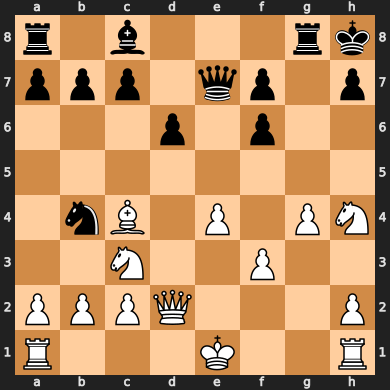

61
(419, AbsHRBefore                                                          4
AbsHRAfter                                                           5
MoveS                                                              Qe5
MovePGN                                                       ['e7e5']
Time                                                               447
DeltaPos                                                         -0.51
Game                                                        Game0813-4
Board                r1b3rk/1pp2p1p/p2p1p2/4q3/1nB1P1PN/2N2P2/PPPQ3...
Evaluation                                                        9.83
AbsHRBefore_altro                                                    9
AbsHRAfter_altro                                                    13
Player                                                               b
Name: 419, dtype: object)


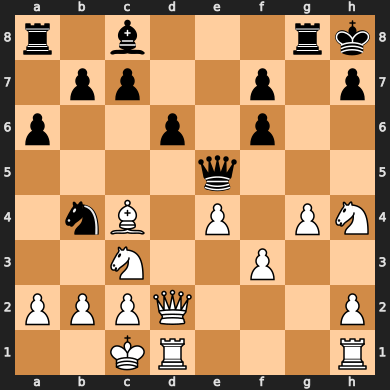

62
(420, AbsHRBefore                                                         14
AbsHRAfter                                                          12
MoveS                                                             Bxf7
MovePGN                                                       ['c4f7']
Time                                                               490
DeltaPos                                                          0.16
Game                                                        Game0813-4
Board                r1b3rk/1pp2B1p/p2p1p2/4q3/1n2P1PN/2N2P2/PPPQ3P...
Evaluation                                                        9.99
AbsHRBefore_altro                                                   14
AbsHRAfter_altro                                                    17
Player                                                               w
Name: 420, dtype: object)


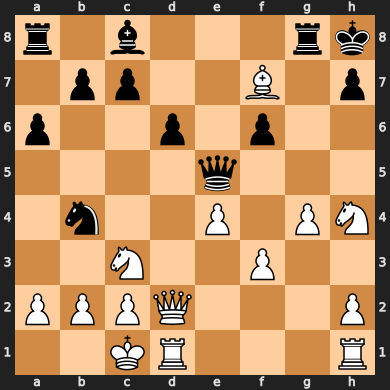

63
(421, AbsHRBefore                                                         16
AbsHRAfter                                                          14
MoveS                                                              Rf8
MovePGN                                                       ['g8f8']
Time                                                               505
DeltaPos                                                         -3.37
Game                                                        Game0813-4
Board                r1b2r1k/1pp2B1p/p2p1p2/4q3/1n2P1PN/2N2P2/PPPQ3...
Evaluation                                                       13.36
AbsHRBefore_altro                                                   16
AbsHRAfter_altro                                                    10
Player                                                               b
Name: 421, dtype: object)


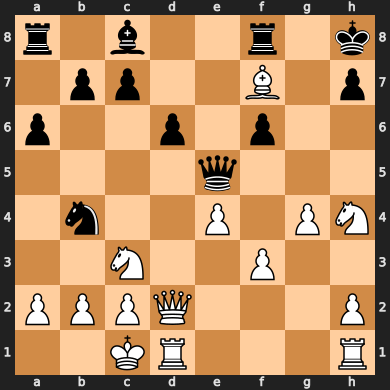

64
(422, AbsHRBefore                                                          7
AbsHRAfter                                                           7
MoveS                                                              Bh5
MovePGN                                                       ['f7h5']
Time                                                               519
DeltaPos                                                          4.19
Game                                                        Game0813-4
Board                r1b2r1k/1pp4p/p2p1p2/4q2B/1n2P1PN/2N2P2/PPPQ3P...
Evaluation                                                        9.17
AbsHRBefore_altro                                                    7
AbsHRAfter_altro                                                     6
Player                                                               w
Name: 422, dtype: object)


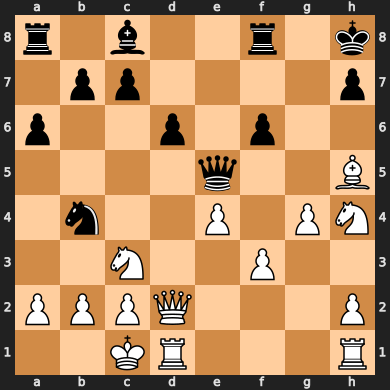

65
(423, AbsHRBefore                                                         12
AbsHRAfter                                                          12
MoveS                                                              Qa5
MovePGN                                                       ['e5a5']
Time                                                               546
DeltaPos                                                         -0.64
Game                                                        Game0813-4
Board                r1b2r1k/1pp4p/p2p1p2/q6B/1n2P1PN/2N2P2/PPPQ3P/...
Evaluation                                                        9.81
AbsHRBefore_altro                                                   12
AbsHRAfter_altro                                                     7
Player                                                               b
Name: 423, dtype: object)


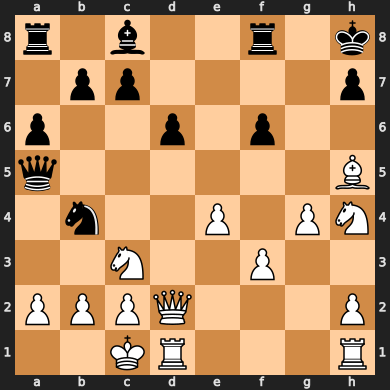

66
(424, AbsHRBefore                                                         15
AbsHRAfter                                                          15
MoveS                                                               a3
MovePGN                                                       ['a2a3']
Time                                                               583
DeltaPos                                                          0.25
Game                                                        Game0813-4
Board                r1b2r1k/1pp4p/p2p1p2/q6B/1n2P1PN/P1N2P2/1PPQ3P...
Evaluation                                                        9.56
AbsHRBefore_altro                                                   15
AbsHRAfter_altro                                                     9
Player                                                               w
Name: 424, dtype: object)


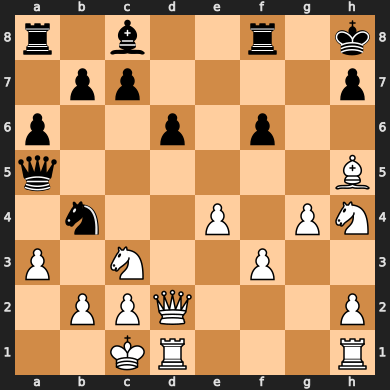

67
(425, AbsHRBefore                                                          2
AbsHRAfter                                                           2
MoveS                                                              Nc6
MovePGN                                                       ['b4c6']
Time                                                               622
DeltaPos                                                         -0.01
Game                                                        Game0813-4
Board                r1b2r1k/1pp4p/p1np1p2/q6B/4P1PN/P1N2P2/1PPQ3P/...
Evaluation                                                        9.57
AbsHRBefore_altro                                                   16
AbsHRAfter_altro                                                    16
Player                                                               b
Name: 425, dtype: object)


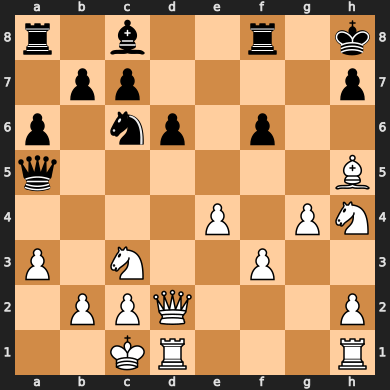

68
(426, AbsHRBefore                                                         18
AbsHRAfter                                                          18
MoveS                                                              Nf5
MovePGN                                                       ['h4f5']
Time                                                               647
DeltaPos                                                          0.04
Game                                                        Game0813-4
Board                r1b2r1k/1pp4p/p1np1p2/q4N1B/4P1P1/P1N2P2/1PPQ3...
Evaluation                                                        9.53
AbsHRBefore_altro                                                   18
AbsHRAfter_altro                                                    10
Player                                                               w
Name: 426, dtype: object)


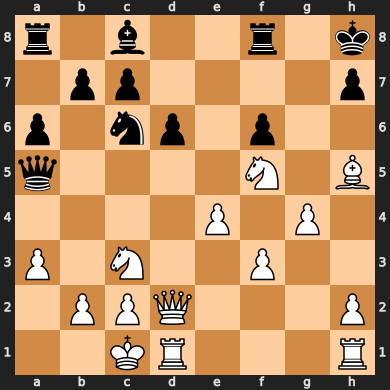

69
(427, AbsHRBefore                                                          3
AbsHRAfter                                                           2
MoveS                                                              Ne5
MovePGN                                                       ['c6e5']
Time                                                               669
DeltaPos                                                         -0.33
Game                                                        Game0813-4
Board                r1b2r1k/1pp4p/p2p1p2/q3nN1B/4P1P1/P1N2P2/1PPQ3...
Evaluation                                                        9.86
AbsHRBefore_altro                                                   10
AbsHRAfter_altro                                                    11
Player                                                               b
Name: 427, dtype: object)


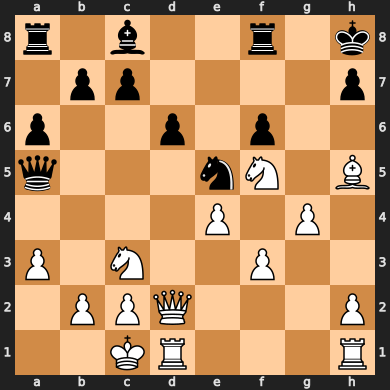

70
(430, AbsHRBefore                                                         13
AbsHRAfter                                                          12
MoveS                                                              Qd5
MovePGN                                                       ['d2d5']
Time                                                               754
DeltaPos                                                          0.92
Game                                                        Game0813-4
Board                r1b2r1k/1pp4p/p2p1p2/q2Q1N1B/4PPP1/P1N2n2/1PP4...
Evaluation                                                       10.45
AbsHRBefore_altro                                                   13
AbsHRAfter_altro                                                     8
Player                                                               w
Name: 430, dtype: object)


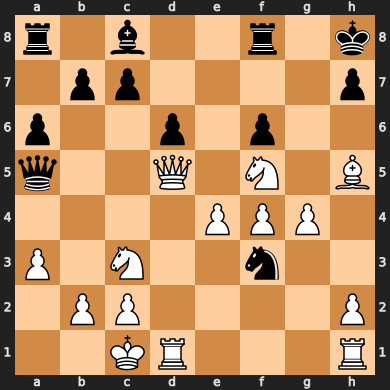

71
(431, AbsHRBefore                                                          0
AbsHRAfter                                                           1
MoveS                                                               b5
MovePGN                                                       ['b7b5']
Time                                                               767
DeltaPos                                                         -3.83
Game                                                        Game0813-4
Board                r1b2r1k/2p4p/p2p1p2/qp1Q1N1B/4PPP1/P1N2n2/1PP4...
Evaluation                                                       14.28
AbsHRBefore_altro                                                   11
AbsHRAfter_altro                                                    11
Player                                                               b
Name: 431, dtype: object)


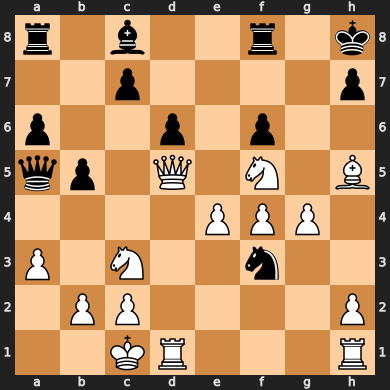

72
(475, AbsHRBefore                                                         23
AbsHRAfter                                                          22
MoveS                                                              Be3
MovePGN                                                       ['c1e3']
Time                                                                85
DeltaPos                                                          1.94
Game                                                        Game0817-2
Board                r2qkbnr/pp3pp1/2n1p2p/3pP3/3N3P/2NQB3/PPP2PP1/...
Evaluation                                                       -1.91
AbsHRBefore_altro                                                   23
AbsHRAfter_altro                                                    14
Player                                                               w
Name: 475, dtype: object)


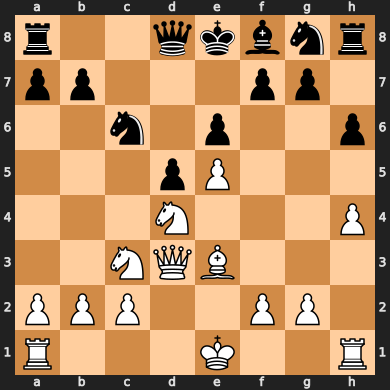

73
(487, AbsHRBefore                                                         29
AbsHRAfter                                                          28
MoveS                                                              Qc3
MovePGN                                                       ['d3c3']
Time                                                               219
DeltaPos                                                          1.19
Game                                                        Game0817-2
Board                r4b1N/1p1kn1p1/pq2p2p/3pn3/3N3P/2Q5/PPPB1PP1/R...
Evaluation                                                        6.82
AbsHRBefore_altro                                                   29
AbsHRAfter_altro                                                    16
Player                                                               w
Name: 487, dtype: object)


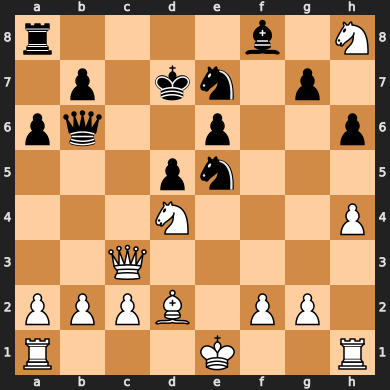

74
(491, AbsHRBefore                                                         25
AbsHRAfter                                                          24
MoveS                                                             Nxc6
MovePGN                                                       ['d4c6']
Time                                                               263
DeltaPos                                                          0.96
Game                                                        Game0817-2
Board                r6N/1p1k2p1/pqN1p2p/3pn3/1b5P/2Q1B3/PPP2PP1/R3...
Evaluation                                                       -5.94
AbsHRBefore_altro                                                   25
AbsHRAfter_altro                                                    17
Player                                                               w
Name: 491, dtype: object)


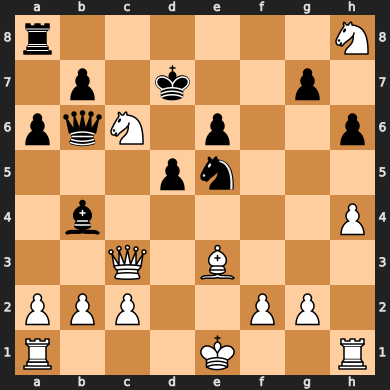

75
(492, AbsHRBefore                                                          4
AbsHRAfter                                                           8
MoveS                                                             Qxc6
MovePGN                                                       ['b6c6']
Time                                                               279
DeltaPos                                                        -16.38
Game                                                        Game0817-2
Board                r6N/1p1k2p1/p1q1p2p/3pn3/1b5P/2Q1B3/PPP2PP1/R3...
Evaluation                                                       10.44
AbsHRBefore_altro                                                   22
AbsHRAfter_altro                                                    17
Player                                                               b
Name: 492, dtype: object)


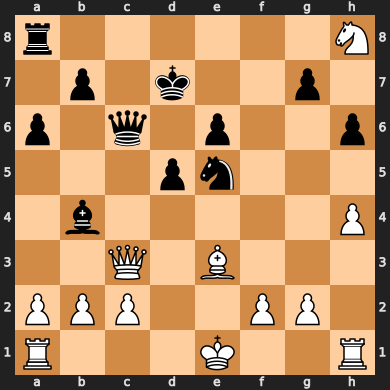

76
(493, AbsHRBefore                                                          1
AbsHRAfter                                                           0
MoveS                                                             Qxb4
MovePGN                                                       ['c3b4']
Time                                                               291
DeltaPos                                                             0
Game                                                        Game0817-2
Board                r6N/1p1k2p1/p1q1p2p/3pn3/1Q5P/4B3/PPP2PP1/R3K2...
Evaluation                                                       10.44
AbsHRBefore_altro                                                    4
AbsHRAfter_altro                                                     8
Player                                                               w
Name: 493, dtype: object)


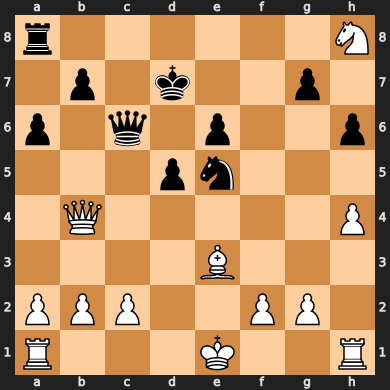

77
(615, AbsHRBefore                                                         21
AbsHRAfter                                                          21
MoveS                                                              Qf3
MovePGN                                                       ['e2f3']
Time                                                               119
DeltaPos                                                          0.47
Game                                                        Game0529-5
Board                r2qk2r/pp1nbppp/4p3/2ppP3/5P2/2N1PQP1/PPPB3P/2...
Evaluation                                                       -0.89
AbsHRBefore_altro                                                   21
AbsHRAfter_altro                                                    13
Player                                                               w
Name: 615, dtype: object)


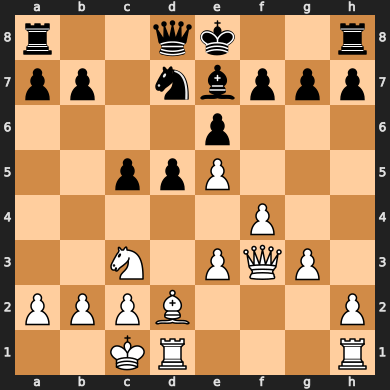

78
(628, AbsHRBefore                                                         22
AbsHRAfter                                                          23
MoveS                                                             exd5
MovePGN                                                       ['e6d5']
Time                                                               245
DeltaPos                                                         -0.47
Game                                                        Game0529-5
Board                r3k2r/pp2bppp/1q6/3pP3/5P2/1Q4P1/P1PRN2P/2K4R ...
Evaluation                                                        2.61
AbsHRBefore_altro                                                   22
AbsHRAfter_altro                                                     6
Player                                                               b
Name: 628, dtype: object)


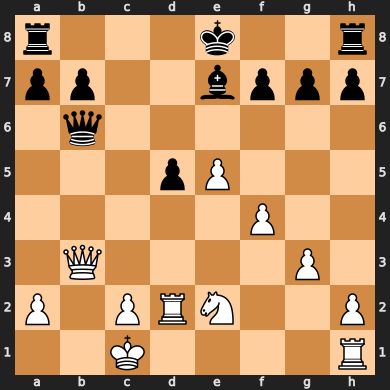

79
(636, AbsHRBefore                                                         11
AbsHRAfter                                                          14
MoveS                                                             Ba3+
MovePGN                                                       ['e7a3']
Time                                                               319
DeltaPos                                                         -0.43
Game                                                        Game0529-5
Board                r3k2r/1p3p1p/1p6/3pP3/3N1P2/b1P5/P2R3P/2K4R w ...
Evaluation                                                        1.09
AbsHRBefore_altro                                                   11
AbsHRAfter_altro                                                     7
Player                                                               b
Name: 636, dtype: object)


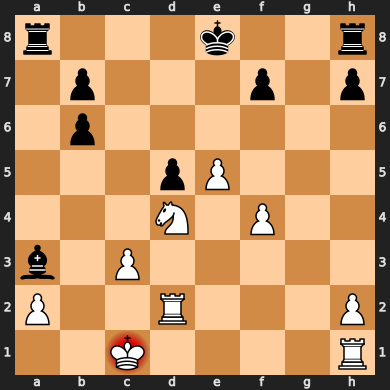

80
(657, AbsHRBefore                                                       22
AbsHRAfter                                                        23
MoveS                                                            Re2
MovePGN                                                     ['e1e2']
Time                                                             454
DeltaPos                                                        2.65
Game                                                      Game0529-5
Board                r7/1p3p1p/1pk5/4P3/3R4/2P3bP/PK2R3/8 b - - 6 34
Evaluation                                                      4.45
AbsHRBefore_altro                                                 22
AbsHRAfter_altro                                                  20
Player                                                             w
Name: 657, dtype: object)


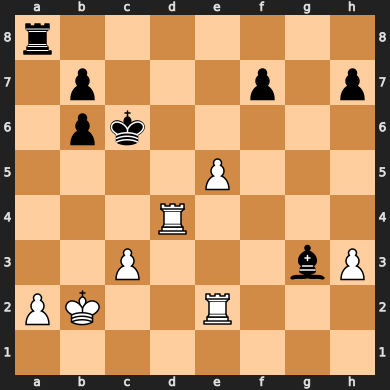

81
(661, AbsHRBefore                                                          7
AbsHRAfter                                                           4
MoveS                                                              Rd7
MovePGN                                                       ['d6d7']
Time                                                               497
DeltaPos                                                          0.01
Game                                                        Game0529-5
Board                4r3/1p1R1p1p/1p6/2k1P3/8/2P3bP/PK2R3/8 b - - 1...
Evaluation                                                        4.58
AbsHRBefore_altro                                                   11
AbsHRAfter_altro                                                    11
Player                                                               w
Name: 661, dtype: object)


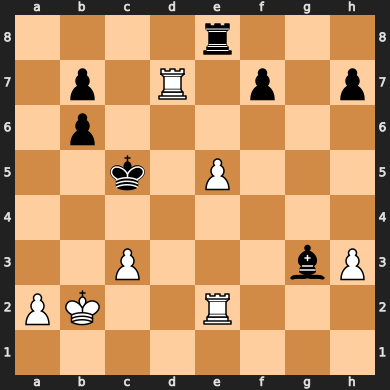

82
(662, AbsHRBefore                                                        22
AbsHRAfter                                                         23
MoveS                                                            Bxe5
MovePGN                                                      ['g3e5']
Time                                                              533
DeltaPos                                                         0.15
Game                                                       Game0529-5
Board                4r3/1p1R1p1p/1p6/2k1b3/8/2P4P/PK2R3/8 w - - 0 37
Evaluation                                                       4.43
AbsHRBefore_altro                                                  22
AbsHRAfter_altro                                                    6
Player                                                              b
Name: 662, dtype: object)


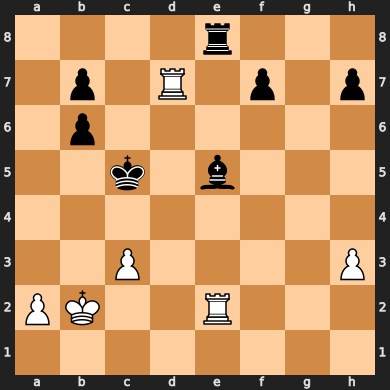

83
(663, AbsHRBefore                                                         4
AbsHRAfter                                                          2
MoveS                                                             Kb3
MovePGN                                                      ['b2b3']
Time                                                              557
DeltaPos                                                         0.06
Game                                                       Game0529-5
Board                4r3/1p1R1p1p/1p6/2k1b3/8/1KP4P/P3R3/8 b - - 1 37
Evaluation                                                       4.37
AbsHRBefore_altro                                                   5
AbsHRAfter_altro                                                    7
Player                                                              w
Name: 663, dtype: object)


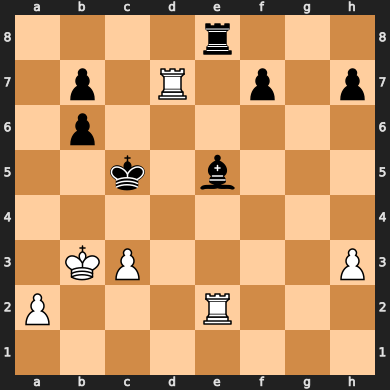

84
(673, AbsHRBefore                                                      12
AbsHRAfter                                                        8
MoveS                                                           Kc2
MovePGN                                                    ['b3c2']
Time                                                            639
DeltaPos                                                       0.62
Game                                                     Game0529-5
Board                4r3/1p6/1p6/4b2R/2P2p2/4k2P/P1KR4/8 b - - 4 42
Evaluation                                                        0
AbsHRBefore_altro                                                18
AbsHRAfter_altro                                                 19
Player                                                            w
Name: 673, dtype: object)


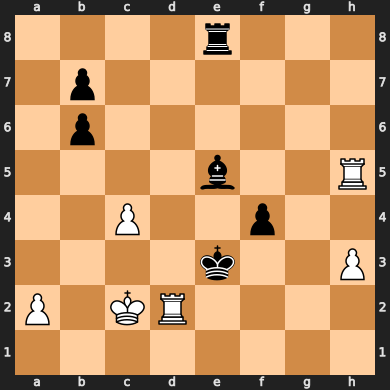

85
(674, AbsHRBefore                                                     21
AbsHRAfter                                                      23
MoveS                                                           f3
MovePGN                                                   ['f4f3']
Time                                                           659
DeltaPos                                                     -1.16
Game                                                    Game0529-5
Board                4r3/1p6/1p6/4b2R/2P5/4kp1P/P1KR4/8 w - - 0 43
Evaluation                                                    1.16
AbsHRBefore_altro                                               21
AbsHRAfter_altro                                                 9
Player                                                           b
Name: 674, dtype: object)


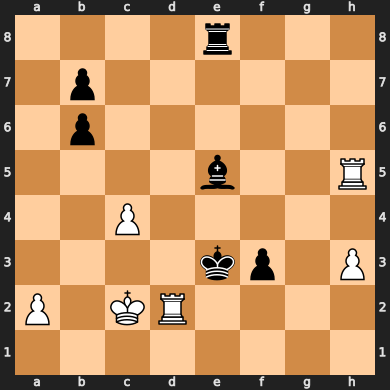

86
(675, AbsHRBefore                                                      8
AbsHRAfter                                                       9
MoveS                                                          Rf5
MovePGN                                                   ['h5f5']
Time                                                           687
DeltaPos                                                       0.9
Game                                                    Game0529-5
Board                4r3/1p6/1p6/4bR2/2P5/4kp1P/P1KR4/8 b - - 1 43
Evaluation                                                    0.26
AbsHRBefore_altro                                               17
AbsHRAfter_altro                                                15
Player                                                           w
Name: 675, dtype: object)


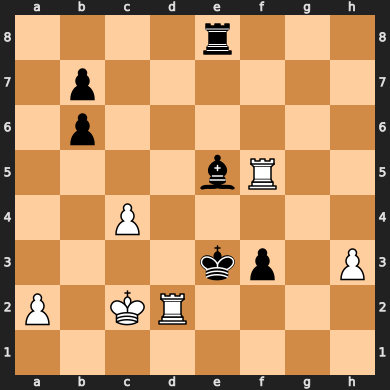

87
(679, AbsHRBefore                                                       63
AbsHRAfter                                                        62
MoveS                                                            Rf7
MovePGN                                                     ['f5f7']
Time                                                             756
DeltaPos                                                         0.6
Game                                                      Game0529-5
Board                4r3/1p3R2/1p6/8/2P1kb2/3R1p1P/P1K5/8 b - - 5 45
Evaluation                                                     -0.74
AbsHRBefore_altro                                                 63
AbsHRAfter_altro                                                  51
Player                                                             w
Name: 679, dtype: object)


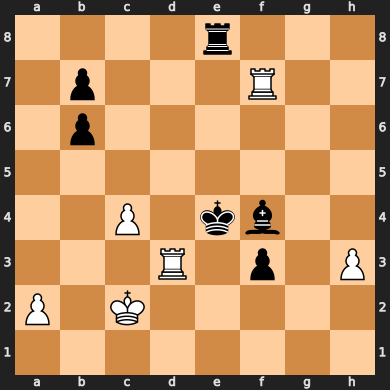

88
(686, AbsHRBefore                                                        24
AbsHRAfter                                                         32
MoveS                                                             Kf3
MovePGN                                                      ['e4f3']
Time                                                              825
DeltaPos                                                         0.17
Game                                                       Game0529-5
Board                8/1p3R2/1p6/8/2P2b2/1K3k1P/P2r1p2/5R2 w - - 6 49
Evaluation                                                      -0.25
AbsHRBefore_altro                                                  24
AbsHRAfter_altro                                                   18
Player                                                              b
Name: 686, dtype: object)


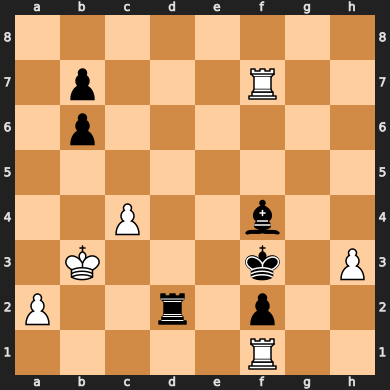

89
(702, AbsHRBefore                                                26
AbsHRAfter                                                 26
MoveS                                                     Rf5
MovePGN                                              ['f3f5']
Time                                                      989
DeltaPos                                                 0.14
Game                                               Game0529-5
Board                8/8/1p4R1/1Kb2r1P/2P5/7k/P7/8 w - - 9 57
Evaluation                                               0.26
AbsHRBefore_altro                                          26
AbsHRAfter_altro                                           26
Player                                                      b
Name: 702, dtype: object)


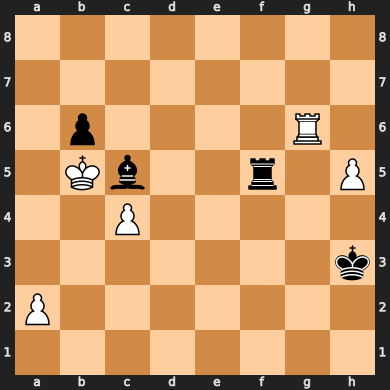

90
(703, AbsHRBefore                                               45
AbsHRAfter                                                42
MoveS                                                     h6
MovePGN                                             ['h5h6']
Time                                                    1008
DeltaPos                                                0.09
Game                                              Game0529-5
Board                8/8/1p4RP/1Kb2r2/2P5/7k/P7/8 b - - 0 57
Evaluation                                              0.35
AbsHRBefore_altro                                         46
AbsHRAfter_altro                                          53
Player                                                     w
Name: 703, dtype: object)


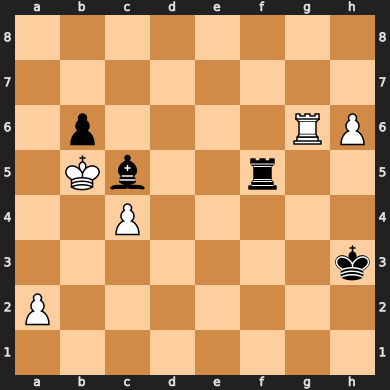

91
(739, AbsHRBefore                                                         20
AbsHRAfter                                                          21
MoveS                                                              Bb5
MovePGN                                                       ['f1b5']
Time                                                                53
DeltaPos                                                          0.12
Game                                                        Game0813-2
Board                r1b1kb1r/ppp1qppp/2n2n2/1B2p3/4P3/2N1BN2/PPP2P...
Evaluation                                                        1.19
AbsHRBefore_altro                                                   25
AbsHRAfter_altro                                                    26
Player                                                               w
Name: 739, dtype: object)


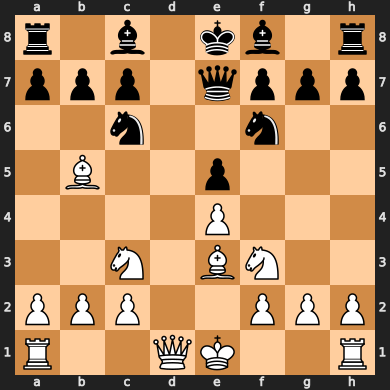

92
(740, AbsHRBefore                                                         24
AbsHRAfter                                                          23
MoveS                                                              Bd7
MovePGN                                                       ['c8d7']
Time                                                                66
DeltaPos                                                         -0.04
Game                                                        Game0813-2
Board                r3kb1r/pppbqppp/2n2n2/1B2p3/4P3/2N1BN2/PPP2PPP...
Evaluation                                                        1.23
AbsHRBefore_altro                                                   24
AbsHRAfter_altro                                                    16
Player                                                               b
Name: 740, dtype: object)


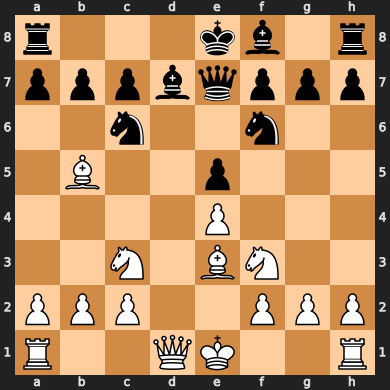

93
(747, AbsHRBefore                                                         28
AbsHRAfter                                                          29
MoveS                                                               c3
MovePGN                                                       ['c2c3']
Time                                                               163
DeltaPos                                                          0.31
Game                                                        Game0813-2
Board                r3kb1r/pppn1ppp/8/4p3/1n2P3/2P1BN2/PP3PPP/R2QK...
Evaluation                                                        9.41
AbsHRBefore_altro                                                   28
AbsHRAfter_altro                                                    25
Player                                                               w
Name: 747, dtype: object)


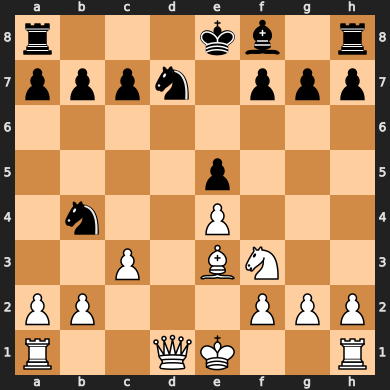

94
(748, AbsHRBefore                                                         20
AbsHRAfter                                                          20
MoveS                                                              Nc6
MovePGN                                                       ['b4c6']
Time                                                               175
DeltaPos                                                         -0.32
Game                                                        Game0813-2
Board                r3kb1r/pppn1ppp/2n5/4p3/4P3/2P1BN2/PP3PPP/R2QK...
Evaluation                                                        9.73
AbsHRBefore_altro                                                   26
AbsHRAfter_altro                                                    27
Player                                                               b
Name: 748, dtype: object)


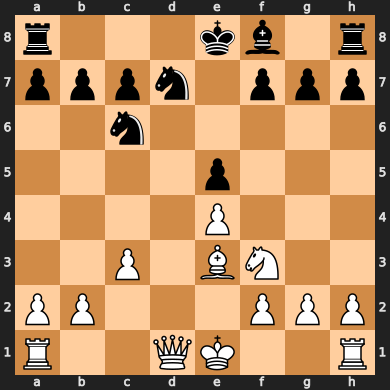

95
(757, AbsHRBefore                                                         13
AbsHRAfter                                                          12
MoveS                                                             Bxa7
MovePGN                                                       ['e3a7']
Time                                                               291
DeltaPos                                                          1.54
Game                                                        Game0813-2
Board                2kr3r/Bppn2bp/2n1Qp2/4p1p1/4P3/2P2N2/PP3PPP/3R...
Evaluation                                                        8.62
AbsHRBefore_altro                                                   15
AbsHRAfter_altro                                                    17
Player                                                               w
Name: 757, dtype: object)


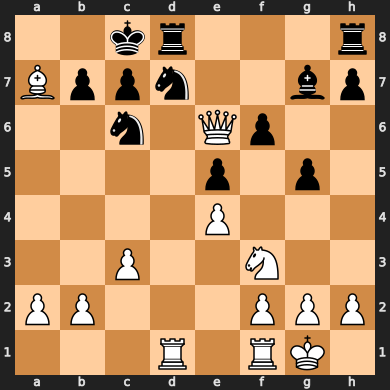

96
(758, AbsHRBefore                                                         28
AbsHRAfter                                                          29
MoveS                                                             Rhe8
MovePGN                                                       ['h8e8']
Time                                                               309
DeltaPos                                                         -0.35
Game                                                        Game0813-2
Board                2krr3/Bppn2bp/2n1Qp2/4p1p1/4P3/2P2N2/PP3PPP/3R...
Evaluation                                                        8.97
AbsHRBefore_altro                                                   28
AbsHRAfter_altro                                                    13
Player                                                               b
Name: 758, dtype: object)


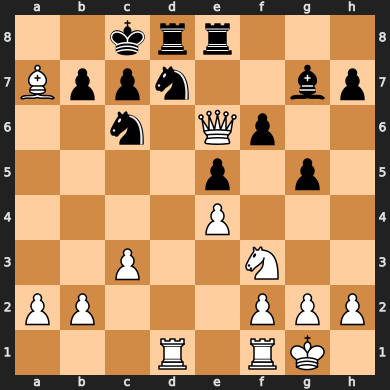

97
(772, AbsHRBefore                                                         20
AbsHRAfter                                                          21
MoveS                                                              Bc5
MovePGN                                                       ['f8c5']
Time                                                               477
DeltaPos                                                          0.82
Game                                                        Game0813-2
Board                1nkrr3/1ppn4/5p1p/1Pb1p3/2Q1P1PN/2P5/P4P2/3R1R...
Evaluation                                                        7.25
AbsHRBefore_altro                                                   20
AbsHRAfter_altro                                                    11
Player                                                               b
Name: 772, dtype: object)


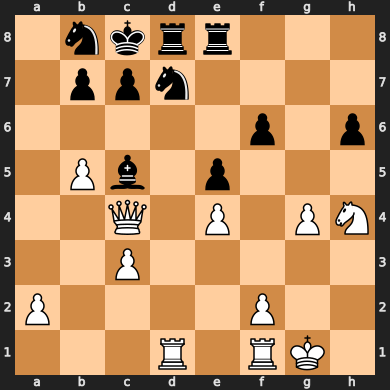

98
(784, AbsHRBefore                                                         22
AbsHRAfter                                                          24
MoveS                                                               c6
MovePGN                                                       ['c7c6']
Time                                                               590
DeltaPos                                                             0
Game                                                        Game0813-2
Board                1nk5/1p1r4/1np1QN2/1P2p3/4P3/2P5/P4R2/3R2K1 w ...
Evaluation                                                          20
AbsHRBefore_altro                                                   22
AbsHRAfter_altro                                                    26
Player                                                               b
Name: 784, dtype: object)


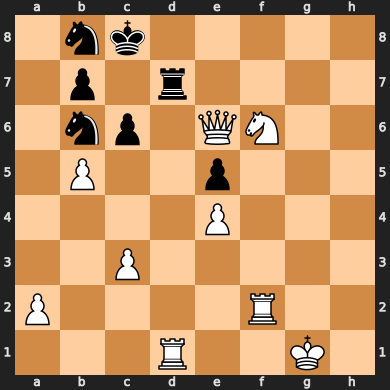

99
(844, AbsHRBefore                                                          5
AbsHRAfter                                                           7
MoveS                                                              Bg5
MovePGN                                                       ['e3g5']
Time                                                               121
DeltaPos                                                          0.44
Game                                                        Game0529-4
Board                r3k2r/3bppbp/1p1p1np1/2p3B1/2B1P3/2N5/PPP2PPP/...
Evaluation                                                       -0.57
AbsHRBefore_altro                                                   12
AbsHRAfter_altro                                                    16
Player                                                               w
Name: 844, dtype: object)


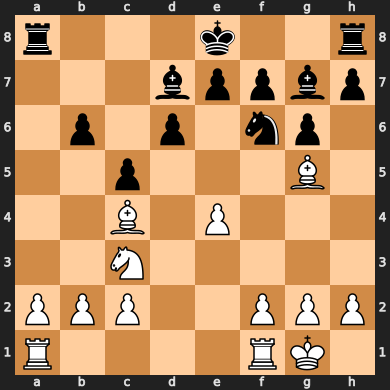

100
(848, AbsHRBefore                                                          0
AbsHRAfter                                                           1
MoveS                                                              Nd5
MovePGN                                                       ['c3d5']
Time                                                               165
DeltaPos                                                          0.14
Game                                                        Game0529-4
Board                r3k2r/4pp1p/1pbp1bp1/2pN4/2B1P3/8/PPP2PPP/R4RK...
Evaluation                                                       -0.39
AbsHRBefore_altro                                                    3
AbsHRAfter_altro                                                     4
Player                                                               w
Name: 848, dtype: object)


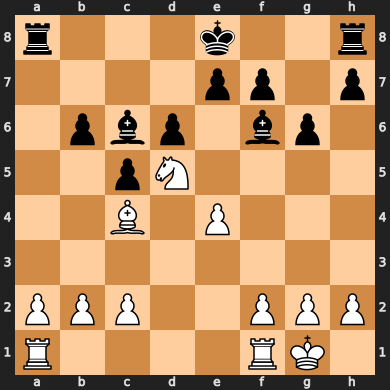

101
(890, AbsHRBefore                                                          0
AbsHRAfter                                                           1
MoveS                                                              Bb3
MovePGN                                                       ['c4b3']
Time                                                               402
DeltaPos                                                             0
Game                                                        Game0529-4
Board                8/8/3p1p2/2p1b1p1/1k2P1P1/1B1K4/P1P5/8 b - - 1...
Evaluation                                                           0
AbsHRBefore_altro                                                    8
AbsHRAfter_altro                                                    12
Player                                                               w
Name: 890, dtype: object)


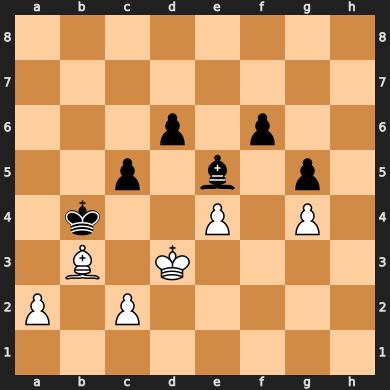

102
(891, AbsHRBefore                                                          6
AbsHRAfter                                                           7
MoveS                                                              Kb5
MovePGN                                                       ['b4b5']
Time                                                               461
DeltaPos                                                         -0.01
Game                                                        Game0529-4
Board                8/8/3p1p2/1kp1b1p1/4P1P1/1B1K4/P1P5/8 w - - 12 37
Evaluation                                                        0.01
AbsHRBefore_altro                                                    6
AbsHRAfter_altro                                                     4
Player                                                               b
Name: 891, dtype: object)


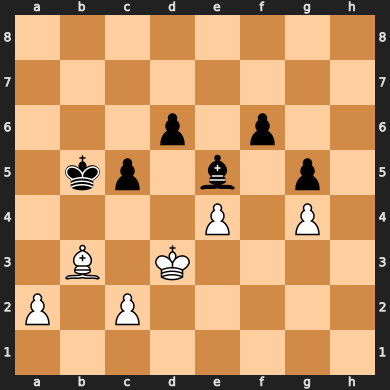

103
(892, AbsHRBefore                                                       12
AbsHRAfter                                                        12
MoveS                                                             a3
MovePGN                                                     ['a2a3']
Time                                                             480
DeltaPos                                                        0.01
Game                                                      Game0529-4
Board                8/8/3p1p2/1kp1b1p1/4P1P1/PB1K4/2P5/8 b - - 0 37
Evaluation                                                         0
AbsHRBefore_altro                                                 15
AbsHRAfter_altro                                                  17
Player                                                             w
Name: 892, dtype: object)


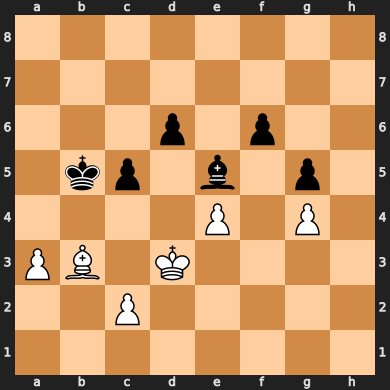

104
(898, AbsHRBefore                                                        1
AbsHRAfter                                                         2
MoveS                                                             c3
MovePGN                                                     ['c2c3']
Time                                                             569
DeltaPos                                                           0
Game                                                      Game0529-4
Board                8/8/3p1p2/k1p1b1p1/P1K1P1P1/1BP5/8/8 b - - 0 40
Evaluation                                                         0
AbsHRBefore_altro                                                  7
AbsHRAfter_altro                                                   5
Player                                                             w
Name: 898, dtype: object)


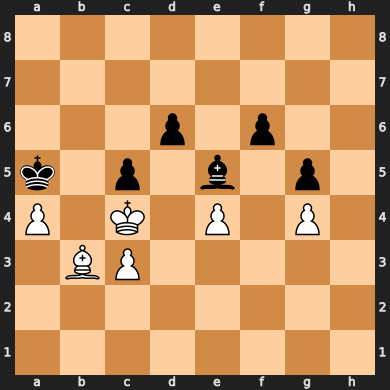

105
(961, AbsHRBefore                                                         17
AbsHRAfter                                                          17
MoveS                                                               c3
MovePGN                                                       ['c2c3']
Time                                                                74
DeltaPos                                                          0.24
Game                                                        Game0529-3
Board                r1bqk2r/ppp2ppp/2n1pn2/3p4/3P1P2/2P2NP1/PP1NP1...
Evaluation                                                        0.37
AbsHRBefore_altro                                                   17
AbsHRAfter_altro                                                     9
Player                                                               w
Name: 961, dtype: object)


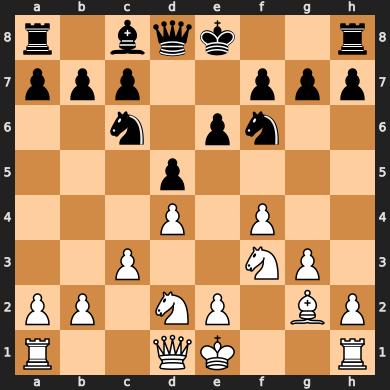

106
(962, AbsHRBefore                                                          5
AbsHRAfter                                                           8
MoveS                                                              Ne4
MovePGN                                                       ['f6e4']
Time                                                                89
DeltaPos                                                         -0.89
Game                                                        Game0529-3
Board                r1bqk2r/ppp2ppp/2n1p3/3p4/3PnP2/2P2NP1/PP1NP1B...
Evaluation                                                        1.26
AbsHRBefore_altro                                                   12
AbsHRAfter_altro                                                    11
Player                                                               b
Name: 962, dtype: object)


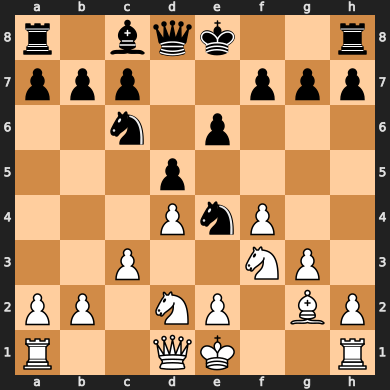

107
(966, AbsHRBefore                                                          4
AbsHRAfter                                                           5
MoveS                                                              Qd6
MovePGN                                                       ['d8d6']
Time                                                               119
DeltaPos                                                          -2.3
Game                                                        Game0529-3
Board                r1b1k2r/ppp2ppp/2nqp3/4N3/3PpP2/2P3P1/PP2P1BP/...
Evaluation                                                        3.24
AbsHRBefore_altro                                                    4
AbsHRAfter_altro                                                     4
Player                                                               b
Name: 966, dtype: object)


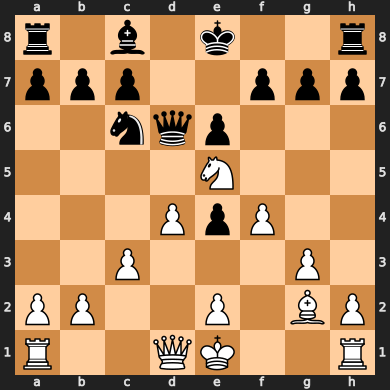

108
(969, AbsHRBefore                                                         24
AbsHRAfter                                                          26
MoveS                                                             dxe5
MovePGN                                                       ['d4e5']
Time                                                               178
DeltaPos                                                          0.51
Game                                                        Game0529-3
Board                r1b1k2r/ppp2ppp/3qp3/4P3/4BP2/2P3P1/PP2P2P/R2Q...
Evaluation                                                        2.85
AbsHRBefore_altro                                                   24
AbsHRAfter_altro                                                    15
Player                                                               w
Name: 969, dtype: object)


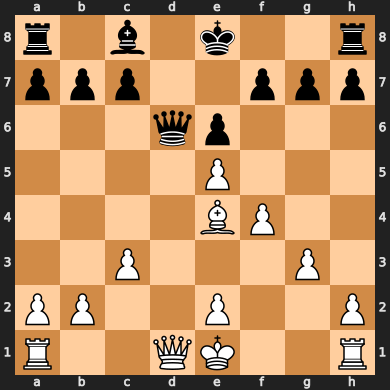

109
(972, AbsHRBefore                                                          8
AbsHRAfter                                                          10
MoveS                                                              Bd7
MovePGN                                                       ['c8d7']
Time                                                               209
DeltaPos                                                         -0.25
Game                                                        Game0529-3
Board                r3k2r/pppb1ppp/4p3/4P3/4BP2/2P3P1/PP2P2P/3RK2R...
Evaluation                                                        3.23
AbsHRBefore_altro                                                   13
AbsHRAfter_altro                                                    14
Player                                                               b
Name: 972, dtype: object)


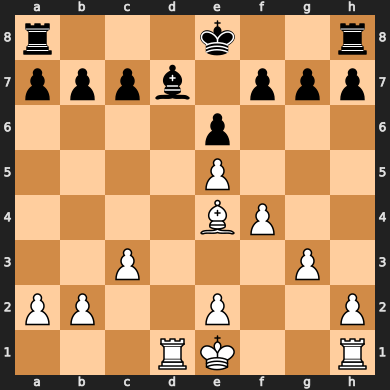

110
(1072, AbsHRBefore                                                         14
AbsHRAfter                                                          14
MoveS                                                              Bg5
MovePGN                                                       ['c1g5']
Time                                                               106
DeltaPos                                                          2.91
Game                                                        Game0817-3
Board                r1bqk2r/pppp1ppp/2n2n2/1Bb3B1/Q3P3/8/PPP2PPP/R...
Evaluation                                                       -2.98
AbsHRBefore_altro                                                   19
AbsHRAfter_altro                                                    20
Player                                                               w
Name: 1072, dtype: object)


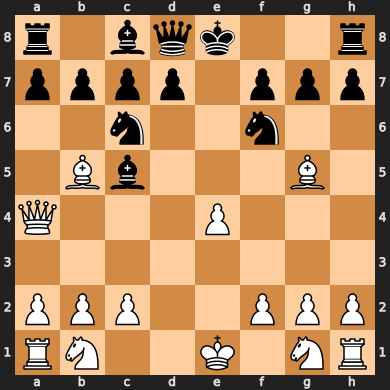

111
(1073, AbsHRBefore                                                         36
AbsHRAfter                                                          37
MoveS                                                              Ne5
MovePGN                                                       ['c6e5']
Time                                                               139
DeltaPos                                                         -1.84
Game                                                        Game0817-3
Board                r1bqk2r/pppp1ppp/5n2/1Bb1n1B1/Q3P3/8/PPP2PPP/R...
Evaluation                                                       -1.14
AbsHRBefore_altro                                                   36
AbsHRAfter_altro                                                    20
Player                                                               b
Name: 1073, dtype: object)


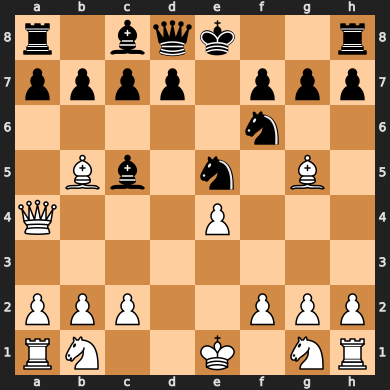

112
(1074, AbsHRBefore                                                         28
AbsHRAfter                                                          31
MoveS                                                               f4
MovePGN                                                       ['f2f4']
Time                                                               152
DeltaPos                                                          0.58
Game                                                        Game0817-3
Board                r1bqk2r/pppp1ppp/5n2/1Bb1n1B1/Q3PP2/8/PPP3PP/R...
Evaluation                                                       -1.72
AbsHRBefore_altro                                                   34
AbsHRAfter_altro                                                    33
Player                                                               w
Name: 1074, dtype: object)


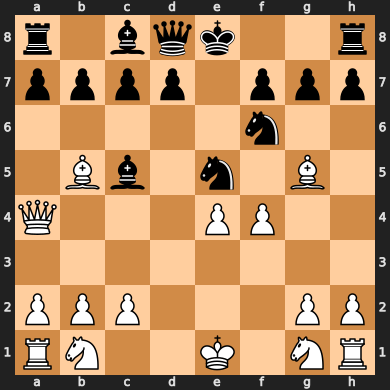

113
(1075, AbsHRBefore                                                          9
AbsHRAfter                                                           2
MoveS                                                             Neg4
MovePGN                                                       ['e5g4']
Time                                                               170
DeltaPos                                                          -0.6
Game                                                        Game0817-3
Board                r1bqk2r/pppp1ppp/5n2/1Bb3B1/Q3PPn1/8/PPP3PP/RN...
Evaluation                                                       -1.12
AbsHRBefore_altro                                                   27
AbsHRAfter_altro                                                    27
Player                                                               b
Name: 1075, dtype: object)


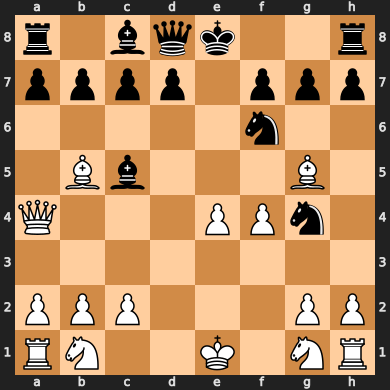

114
(1078, AbsHRBefore                                                         14
AbsHRAfter                                                          15
MoveS                                                              Bd3
MovePGN                                                       ['b5d3']
Time                                                               211
DeltaPos                                                          0.13
Game                                                        Game0817-3
Board                r1bqk2r/pp1p1ppp/2p2n2/2b3B1/Q3PPn1/3B3N/PPP3P...
Evaluation                                                       -3.17
AbsHRBefore_altro                                                   17
AbsHRAfter_altro                                                    19
Player                                                               w
Name: 1078, dtype: object)


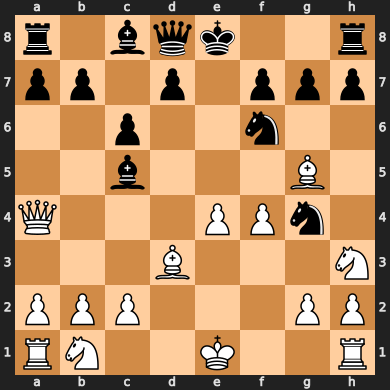

115
(1079, AbsHRBefore                                                         36
AbsHRAfter                                                          37
MoveS                                                               d6
MovePGN                                                       ['d7d6']
Time                                                               238
DeltaPos                                                         -0.25
Game                                                        Game0817-3
Board                r1bqk2r/pp3ppp/2pp1n2/2b3B1/Q3PPn1/3B3N/PPP3PP...
Evaluation                                                       -2.92
AbsHRBefore_altro                                                   36
AbsHRAfter_altro                                                    17
Player                                                               b
Name: 1079, dtype: object)


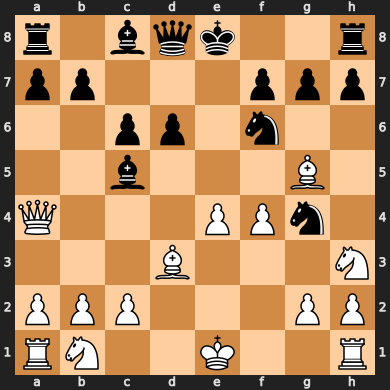

116
(1080, AbsHRBefore                                                         32
AbsHRAfter                                                          33
MoveS                                                              Nd2
MovePGN                                                       ['b1d2']
Time                                                               261
DeltaPos                                                          0.26
Game                                                        Game0817-3
Board                r1bqk2r/pp3ppp/2pp1n2/2b3B1/Q3PPn1/3B3N/PPPN2P...
Evaluation                                                       -2.66
AbsHRBefore_altro                                                   32
AbsHRAfter_altro                                                    32
Player                                                               w
Name: 1080, dtype: object)


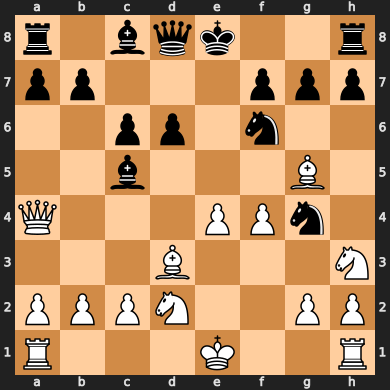

117
(1081, AbsHRBefore                                                         22
AbsHRAfter                                                          23
MoveS                                                               b5
MovePGN                                                       ['b7b5']
Time                                                               290
DeltaPos                                                         -0.27
Game                                                        Game0817-3
Board                r1bqk2r/p4ppp/2pp1n2/1pb3B1/Q3PPn1/3B3N/PPPN2P...
Evaluation                                                       -2.39
AbsHRBefore_altro                                                   30
AbsHRAfter_altro                                                    34
Player                                                               b
Name: 1081, dtype: object)


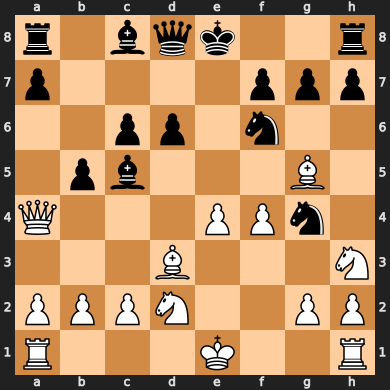

118
(1082, AbsHRBefore                                                         35
AbsHRAfter                                                          32
MoveS                                                              Qb3
MovePGN                                                       ['a4b3']
Time                                                               312
DeltaPos                                                          0.67
Game                                                        Game0817-3
Board                r1bqk2r/p4ppp/2pp1n2/1pb3B1/4PPn1/1Q1B3N/PPPN2...
Evaluation                                                       -3.06
AbsHRBefore_altro                                                   35
AbsHRAfter_altro                                                    19
Player                                                               w
Name: 1082, dtype: object)


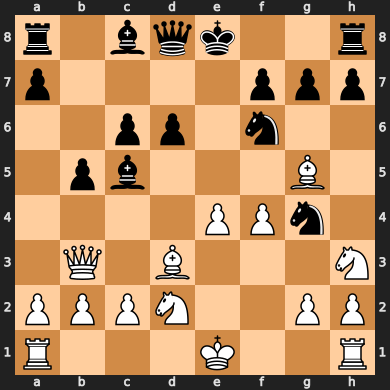

119
(1083, AbsHRBefore                                                         16
AbsHRAfter                                                          17
MoveS                                                              Be6
MovePGN                                                       ['c8e6']
Time                                                               328
DeltaPos                                                          0.35
Game                                                        Game0817-3
Board                r2qk2r/p4ppp/2ppbn2/1pb3B1/4PPn1/1Q1B3N/PPPN2P...
Evaluation                                                       -3.41
AbsHRBefore_altro                                                   21
AbsHRAfter_altro                                                    17
Player                                                               b
Name: 1083, dtype: object)


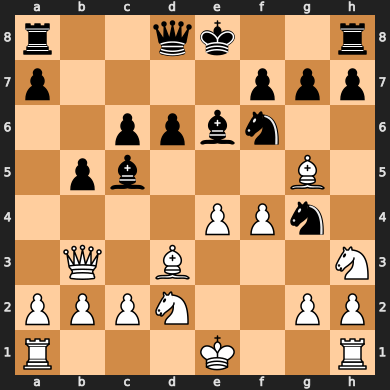

120
(1084, AbsHRBefore                                                         22
AbsHRAfter                                                          22
MoveS                                                              Qc3
MovePGN                                                       ['b3c3']
Time                                                               354
DeltaPos                                                          3.36
Game                                                        Game0817-3
Board                r2qk2r/p4ppp/2ppbn2/1pb3B1/4PPn1/2QB3N/PPPN2PP...
Evaluation                                                       -6.77
AbsHRBefore_altro                                                   38
AbsHRAfter_altro                                                    39
Player                                                               w
Name: 1084, dtype: object)


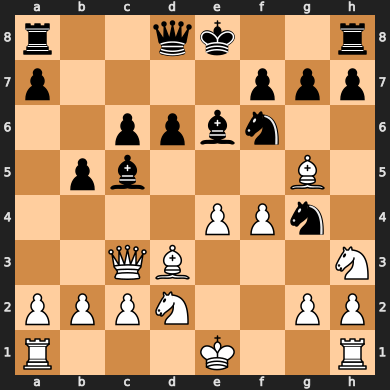

121
(1085, AbsHRBefore                                                         52
AbsHRAfter                                                          50
MoveS                                                               b4
MovePGN                                                       ['b5b4']
Time                                                               379
DeltaPos                                                          0.54
Game                                                        Game0817-3
Board                r2qk2r/p4ppp/2ppbn2/2b3B1/1p2PPn1/2QB3N/PPPN2P...
Evaluation                                                       -7.31
AbsHRBefore_altro                                                   52
AbsHRAfter_altro                                                    24
Player                                                               b
Name: 1085, dtype: object)


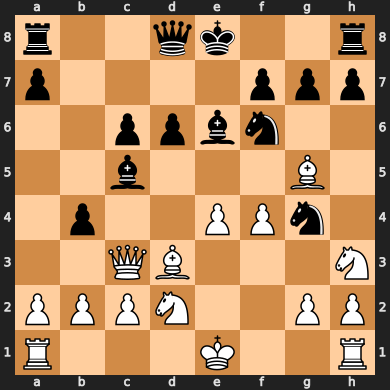

122
(1086, AbsHRBefore                                                         44
AbsHRAfter                                                          42
MoveS                                                             Bxf6
MovePGN                                                       ['g5f6']
Time                                                               407
DeltaPos                                                          1.17
Game                                                        Game0817-3
Board                r2qk2r/p4ppp/2ppbB2/2b5/1p2PPn1/2QB3N/PPPN2PP/...
Evaluation                                                       -8.48
AbsHRBefore_altro                                                   44
AbsHRAfter_altro                                                    29
Player                                                               w
Name: 1086, dtype: object)


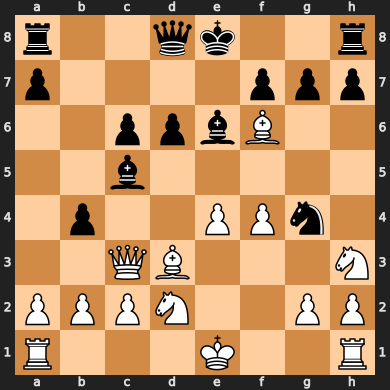

123
(1087, AbsHRBefore                                                         14
AbsHRAfter                                                          14
MoveS                                                             Nxf6
MovePGN                                                       ['g4f6']
Time                                                               420
DeltaPos                                                         -0.88
Game                                                        Game0817-3
Board                r2qk2r/p4ppp/2ppbn2/2b5/1p2PP2/2QB3N/PPPN2PP/R...
Evaluation                                                        -7.6
AbsHRBefore_altro                                                   37
AbsHRAfter_altro                                                    32
Player                                                               b
Name: 1087, dtype: object)


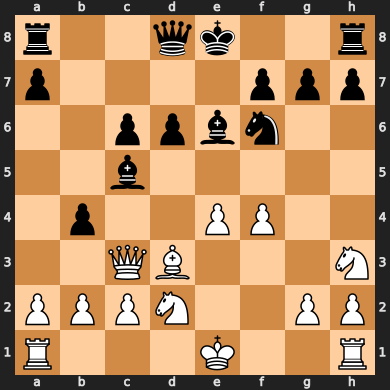

124
(1091, AbsHRBefore                                                          1
AbsHRAfter                                                           1
MoveS                                                              Nd5
MovePGN                                                       ['f6d5']
Time                                                               472
DeltaPos                                                         -0.34
Game                                                        Game0817-3
Board                r2qk2r/p4ppp/2p1b3/2pnP3/1p3P2/3B3N/PPPN2PP/R3...
Evaluation                                                       -7.46
AbsHRBefore_altro                                                   25
AbsHRAfter_altro                                                    29
Player                                                               b
Name: 1091, dtype: object)


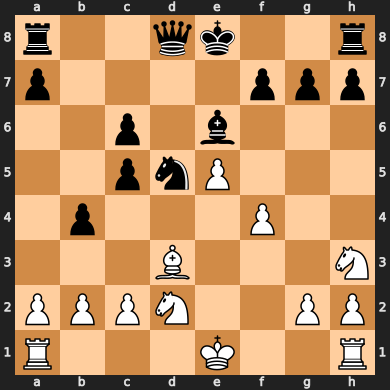

125
(1092, AbsHRBefore                                                         32
AbsHRAfter                                                          32
MoveS                                                               f5
MovePGN                                                       ['f4f5']
Time                                                               490
DeltaPos                                                           0.1
Game                                                        Game0817-3
Board                r2qk2r/p4ppp/2p1b3/2pnPP2/1p6/3B3N/PPPN2PP/R3K...
Evaluation                                                       -7.56
AbsHRBefore_altro                                                   32
AbsHRAfter_altro                                                    18
Player                                                               w
Name: 1092, dtype: object)


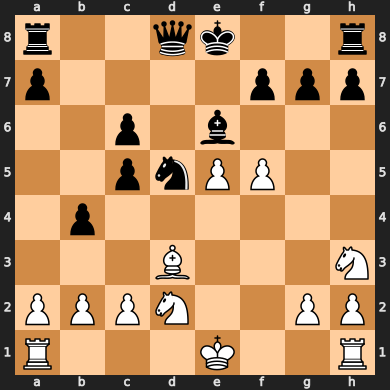

126
(1097, AbsHRBefore                                                          3
AbsHRAfter                                                           2
MoveS                                                              Kf8
MovePGN                                                       ['e8f8']
Time                                                               537
DeltaPos                                                          0.02
Game                                                        Game0817-3
Board                r2q1k1r/p4ppp/2pN4/2pnPb2/1p6/3B3N/PPP3PP/R3K2...
Evaluation                                                       -6.61
AbsHRBefore_altro                                                   34
AbsHRAfter_altro                                                    41
Player                                                               b
Name: 1097, dtype: object)


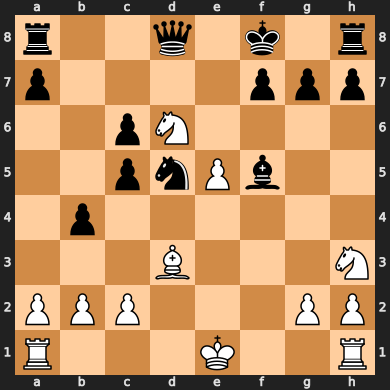

127
(1098, AbsHRBefore                                                         34
AbsHRAfter                                                          34
MoveS                                                             Bxf5
MovePGN                                                       ['d3f5']
Time                                                               558
DeltaPos                                                          0.85
Game                                                        Game0817-3
Board                r2q1k1r/p4ppp/2pN4/2pnPB2/1p6/7N/PPP3PP/R3K2R ...
Evaluation                                                       -7.46
AbsHRBefore_altro                                                   34
AbsHRAfter_altro                                                    28
Player                                                               w
Name: 1098, dtype: object)


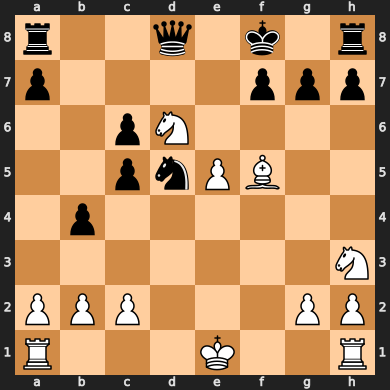

128
(1102, AbsHRBefore                                                         62
AbsHRAfter                                                          63
MoveS                                                              Ne4
MovePGN                                                       ['d6e4']
Time                                                               600
DeltaPos                                                          0.32
Game                                                        Game0817-3
Board                r2q1k1r/p5pp/2p5/2pnpB2/1p2N3/7N/PPP3PP/2KR3R ...
Evaluation                                                       -3.87
AbsHRBefore_altro                                                   62
AbsHRAfter_altro                                                    46
Player                                                               w
Name: 1102, dtype: object)


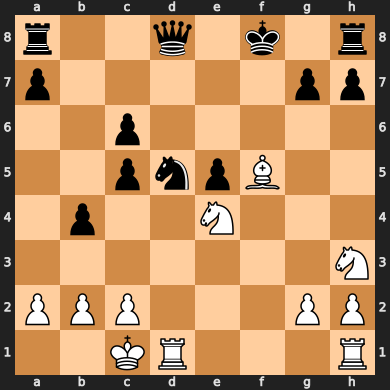

129
(1103, AbsHRBefore                                                          3
AbsHRAfter                                                           2
MoveS                                                              Qe7
MovePGN                                                       ['d8e7']
Time                                                               655
DeltaPos                                                           0.3
Game                                                        Game0817-3
Board                r4k1r/p3q1pp/2p5/2pnpB2/1p2N3/7N/PPP3PP/2KR3R ...
Evaluation                                                       -4.17
AbsHRBefore_altro                                                   52
AbsHRAfter_altro                                                    50
Player                                                               b
Name: 1103, dtype: object)


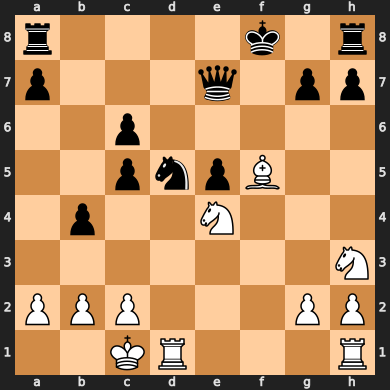

130
(1104, AbsHRBefore                                                         67
AbsHRAfter                                                          64
MoveS                                                             Rhf1
MovePGN                                                       ['h1f1']
Time                                                               674
DeltaPos                                                          1.34
Game                                                        Game0817-3
Board                r4k1r/p3q1pp/2p5/2pnpB2/1p2N3/7N/PPP3PP/2KR1R2...
Evaluation                                                       -2.83
AbsHRBefore_altro                                                   67
AbsHRAfter_altro                                                    38
Player                                                               w
Name: 1104, dtype: object)


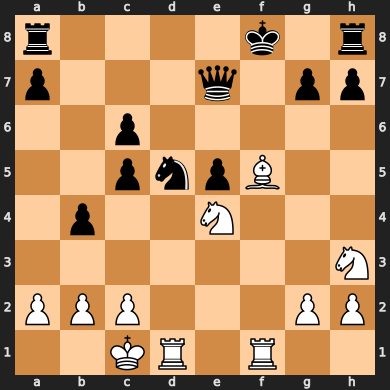

131
(1105, AbsHRBefore                                                          2
AbsHRAfter                                                           4
MoveS                                                              Nf6
MovePGN                                                       ['d5f6']
Time                                                               710
DeltaPos                                                         -1.13
Game                                                        Game0817-3
Board                r4k1r/p3q1pp/2p2n2/2p1pB2/1p2N3/7N/PPP3PP/2KR1...
Evaluation                                                        -1.7
AbsHRBefore_altro                                                   38
AbsHRAfter_altro                                                    53
Player                                                               b
Name: 1105, dtype: object)


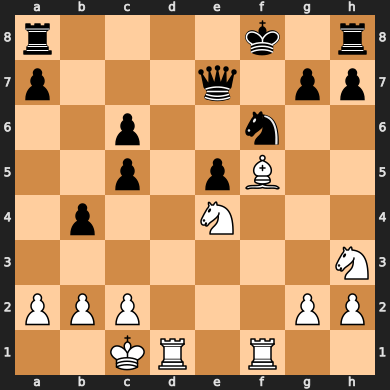

132
(1106, AbsHRBefore                                                         48
AbsHRAfter                                                          48
MoveS                                                              Bg4
MovePGN                                                       ['f5g4']
Time                                                               748
DeltaPos                                                          3.16
Game                                                        Game0817-3
Board                r4k1r/p3q1pp/2p2n2/2p1p3/1p2N1B1/7N/PPP3PP/2KR...
Evaluation                                                       -4.86
AbsHRBefore_altro                                                   48
AbsHRAfter_altro                                                    28
Player                                                               w
Name: 1106, dtype: object)


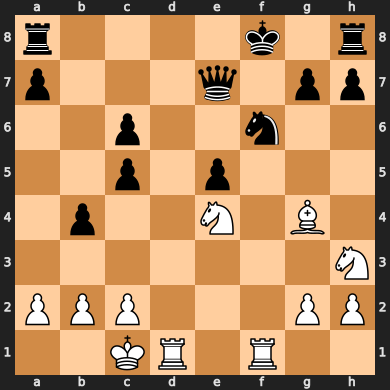

133
(1144, AbsHRBefore                                                         16
AbsHRAfter                                                          16
MoveS                                                               g4
MovePGN                                                       ['g2g4']
Time                                                                82
DeltaPos                                                          0.38
Game                                                        Game0817-4
Board                r2qkb1r/pp1n1pp1/2p1p2p/3pPn2/3P1BPP/3Q1N2/PPP...
Evaluation                                                           0
AbsHRBefore_altro                                                   16
AbsHRAfter_altro                                                    11
Player                                                               w
Name: 1144, dtype: object)


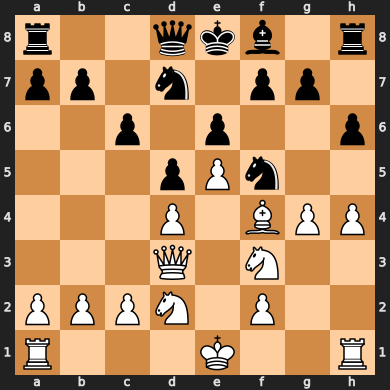

134
(1145, AbsHRBefore                                                          2
AbsHRAfter                                                           1
MoveS                                                              Ne7
MovePGN                                                       ['f5e7']
Time                                                                94
DeltaPos                                                         -0.19
Game                                                        Game0817-4
Board                r2qkb1r/pp1nnpp1/2p1p2p/3pP3/3P1BPP/3Q1N2/PPPN...
Evaluation                                                        0.19
AbsHRBefore_altro                                                   17
AbsHRAfter_altro                                                    18
Player                                                               b
Name: 1145, dtype: object)


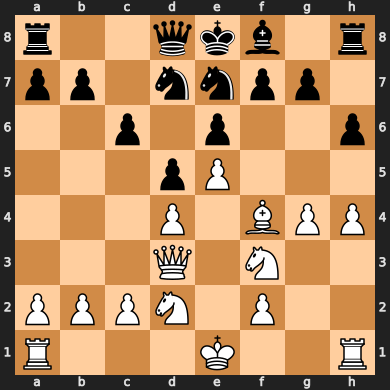

135
(1146, AbsHRBefore                                                          5
AbsHRAfter                                                           6
MoveS                                                               g5
MovePGN                                                       ['g4g5']
Time                                                               121
DeltaPos                                                          0.56
Game                                                        Game0817-4
Board                r2qkb1r/pp1nnpp1/2p1p2p/3pP1P1/3P1B1P/3Q1N2/PP...
Evaluation                                                       -0.37
AbsHRBefore_altro                                                    9
AbsHRAfter_altro                                                    11
Player                                                               w
Name: 1146, dtype: object)


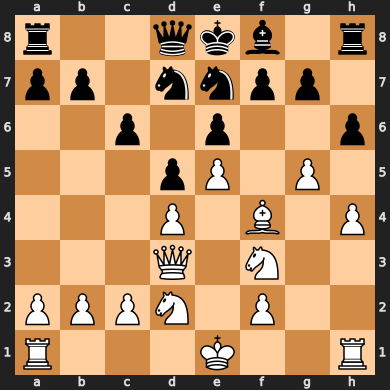

136
(1147, AbsHRBefore                                                         10
AbsHRAfter                                                           9
MoveS                                                              Nf5
MovePGN                                                       ['e7f5']
Time                                                               137
DeltaPos                                                         -0.75
Game                                                        Game0817-4
Board                r2qkb1r/pp1n1pp1/2p1p2p/3pPnP1/3P1B1P/3Q1N2/PP...
Evaluation                                                        0.38
AbsHRBefore_altro                                                   10
AbsHRAfter_altro                                                    10
Player                                                               b
Name: 1147, dtype: object)


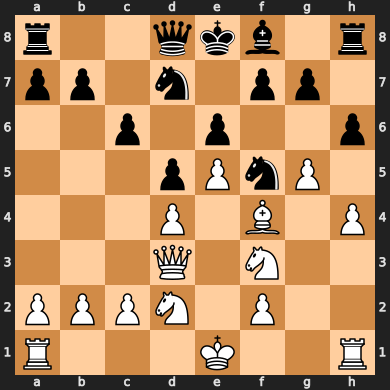

137
(1148, AbsHRBefore                                                          2
AbsHRAfter                                                           2
MoveS                                                            O-O-O
MovePGN                                                       ['e1c1']
Time                                                               235
DeltaPos                                                          0.22
Game                                                        Game0817-4
Board                r2qkb1r/pp1n1pp1/2p1p2p/3pPnP1/3P1B1P/3Q1N2/PP...
Evaluation                                                        0.16
AbsHRBefore_altro                                                    7
AbsHRAfter_altro                                                     7
Player                                                               w
Name: 1148, dtype: object)


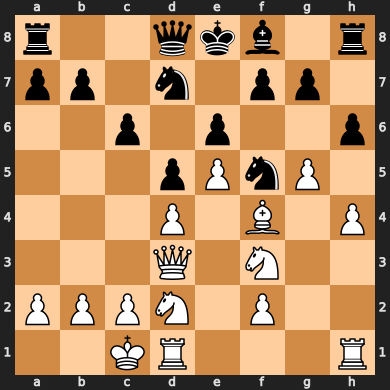

138
(1149, AbsHRBefore                                                          4
AbsHRAfter                                                           4
MoveS                                                              Qa5
MovePGN                                                       ['d8a5']
Time                                                               249
DeltaPos                                                         -0.29
Game                                                        Game0817-4
Board                r3kb1r/pp1n1pp1/2p1p2p/q2pPnP1/3P1B1P/3Q1N2/PP...
Evaluation                                                        0.45
AbsHRBefore_altro                                                    4
AbsHRAfter_altro                                                     3
Player                                                               b
Name: 1149, dtype: object)


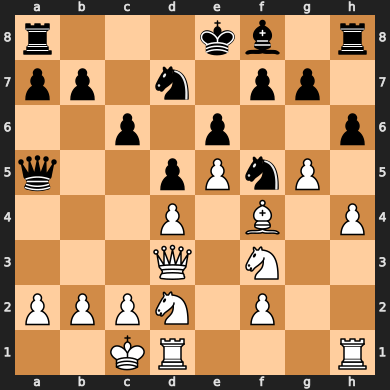

139
(1150, AbsHRBefore                                                          6
AbsHRAfter                                                           7
MoveS                                                              Kb1
MovePGN                                                       ['c1b1']
Time                                                               303
DeltaPos                                                           0.3
Game                                                        Game0817-4
Board                r3kb1r/pp1n1pp1/2p1p2p/q2pPnP1/3P1B1P/3Q1N2/PP...
Evaluation                                                        0.15
AbsHRBefore_altro                                                    6
AbsHRAfter_altro                                                    13
Player                                                               w
Name: 1150, dtype: object)


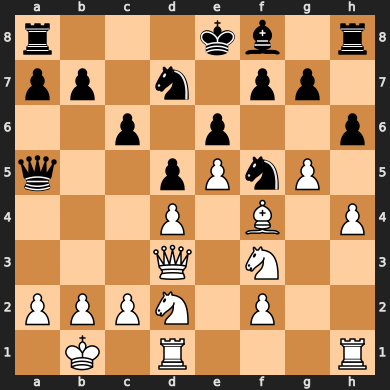

140
(1153, AbsHRBefore                                                         18
AbsHRAfter                                                          20
MoveS                                                              Qc7
MovePGN                                                       ['a5c7']
Time                                                               363
DeltaPos                                                         -0.22
Game                                                        Game0817-4
Board                2kr1b1r/ppqn1pp1/2p1p2p/3pPnP1/3P1B1P/1N1Q1N2/...
Evaluation                                                        0.52
AbsHRBefore_altro                                                   18
AbsHRAfter_altro                                                     2
Player                                                               b
Name: 1153, dtype: object)


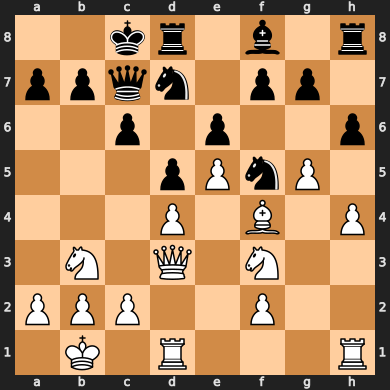

141
(1154, AbsHRBefore                                                          5
AbsHRAfter                                                           4
MoveS                                                               c3
MovePGN                                                       ['c2c3']
Time                                                               458
DeltaPos                                                           0.4
Game                                                        Game0817-4
Board                2kr1b1r/ppqn1pp1/2p1p2p/3pPnP1/3P1B1P/1NPQ1N2/...
Evaluation                                                        0.12
AbsHRBefore_altro                                                   26
AbsHRAfter_altro                                                    31
Player                                                               w
Name: 1154, dtype: object)


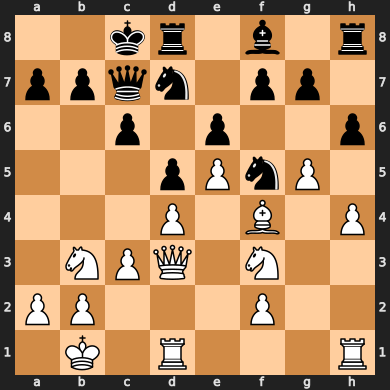

142
(1155, AbsHRBefore                                                         32
AbsHRAfter                                                          32
MoveS                                                              Kb8
MovePGN                                                       ['c8b8']
Time                                                               474
DeltaPos                                                         -0.13
Game                                                        Game0817-4
Board                1k1r1b1r/ppqn1pp1/2p1p2p/3pPnP1/3P1B1P/1NPQ1N2...
Evaluation                                                        0.25
AbsHRBefore_altro                                                   32
AbsHRAfter_altro                                                     2
Player                                                               b
Name: 1155, dtype: object)


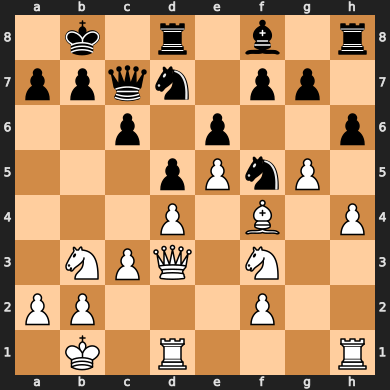

143
(1156, AbsHRBefore                                                          2
AbsHRAfter                                                           4
MoveS                                                               h5
MovePGN                                                       ['h4h5']
Time                                                               498
DeltaPos                                                          0.08
Game                                                        Game0817-4
Board                1k1r1b1r/ppqn1pp1/2p1p2p/3pPnPP/3P1B2/1NPQ1N2/...
Evaluation                                                        0.17
AbsHRBefore_altro                                                    6
AbsHRAfter_altro                                                     9
Player                                                               w
Name: 1156, dtype: object)


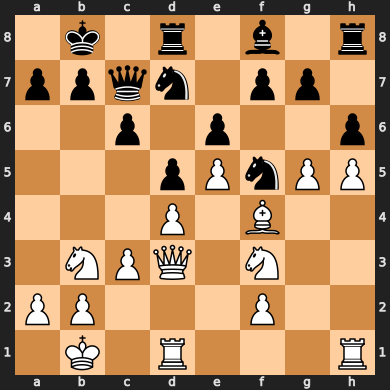

144
(1157, AbsHRBefore                                                         22
AbsHRAfter                                                          22
MoveS                                                              Be7
MovePGN                                                       ['f8e7']
Time                                                               521
DeltaPos                                                         -0.33
Game                                                        Game0817-4
Board                1k1r3r/ppqnbpp1/2p1p2p/3pPnPP/3P1B2/1NPQ1N2/PP...
Evaluation                                                         0.5
AbsHRBefore_altro                                                   22
AbsHRAfter_altro                                                     5
Player                                                               b
Name: 1157, dtype: object)


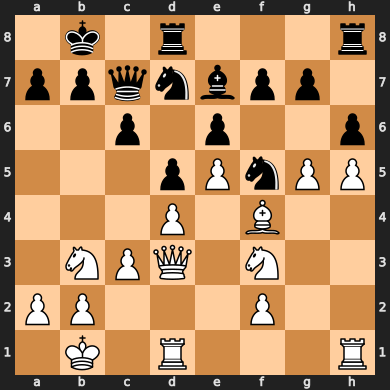

145
(1158, AbsHRBefore                                                         24
AbsHRAfter                                                          24
MoveS                                                               g6
MovePGN                                                       ['g5g6']
Time                                                               573
DeltaPos                                                          1.01
Game                                                        Game0817-4
Board                1k1r3r/ppqnbpp1/2p1p1Pp/3pPn1P/3P1B2/1NPQ1N2/P...
Evaluation                                                       -0.51
AbsHRBefore_altro                                                   24
AbsHRAfter_altro                                                    19
Player                                                               w
Name: 1158, dtype: object)


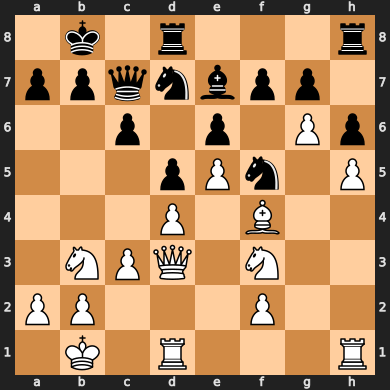

146
(1161, AbsHRBefore                                                         12
AbsHRAfter                                                          11
MoveS                                                              Rc8
MovePGN                                                       ['d8c8']
Time                                                               620
DeltaPos                                                         -0.22
Game                                                        Game0817-4
Board                1kr4r/ppqnb1p1/2p1p1Pp/3pPn2/3P1B2/1NPQ1N2/PP3...
Evaluation                                                       -0.38
AbsHRBefore_altro                                                   22
AbsHRAfter_altro                                                    20
Player                                                               b
Name: 1161, dtype: object)


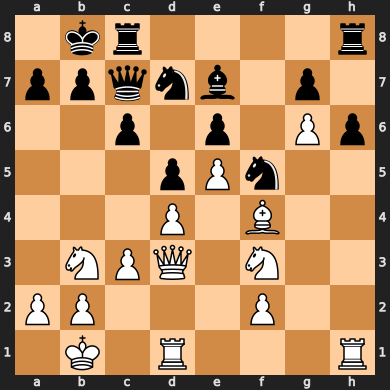

147
(1162, AbsHRBefore                                                         19
AbsHRAfter                                                          18
MoveS                                                              Bg3
MovePGN                                                       ['f4g3']
Time                                                               683
DeltaPos                                                          0.24
Game                                                        Game0817-4
Board                1kr4r/ppqnb1p1/2p1p1Pp/3pPn2/3P4/1NPQ1NB1/PP3P...
Evaluation                                                       -0.62
AbsHRBefore_altro                                                   25
AbsHRAfter_altro                                                    22
Player                                                               w
Name: 1162, dtype: object)


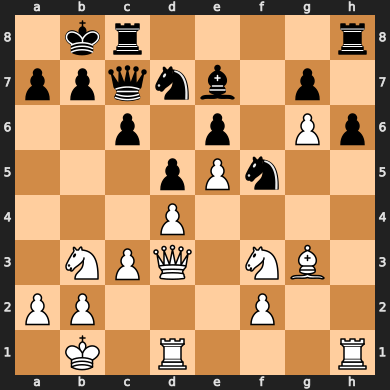

148
(1163, AbsHRBefore                                                          4
AbsHRAfter                                                           4
MoveS                                                              Qd8
MovePGN                                                       ['c7d8']
Time                                                               707
DeltaPos                                                          0.44
Game                                                        Game0817-4
Board                1krq3r/pp1nb1p1/2p1p1Pp/3pPn2/3P4/1NPQ1NB1/PP3...
Evaluation                                                       -1.06
AbsHRBefore_altro                                                   13
AbsHRAfter_altro                                                    12
Player                                                               b
Name: 1163, dtype: object)


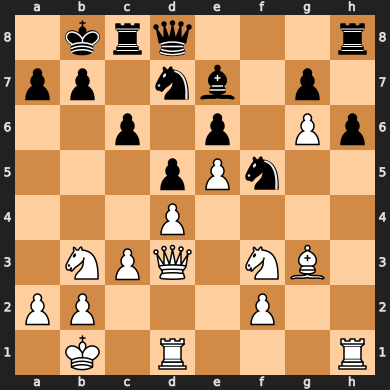

149
(1188, AbsHRBefore                                                          8
AbsHRAfter                                                          13
MoveS                                                              Qg6
MovePGN                                                       ['d3g6']
Time                                                               928
DeltaPos                                                          0.78
Game                                                        Game0817-4
Board                1krq3r/pp1n4/4p1Qp/3pP1b1/1P1P4/2P3B1/1P6/1K1R...
Evaluation                                                       -6.62
AbsHRBefore_altro                                                   13
AbsHRAfter_altro                                                    10
Player                                                               w
Name: 1188, dtype: object)


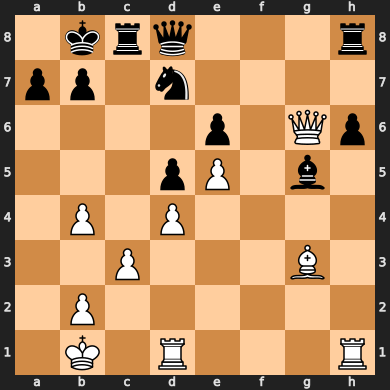

150
(1221, AbsHRBefore                                                          4
AbsHRAfter                                                           5
MoveS                                                              Nd4
MovePGN                                                       ['c6d4']
Time                                                                85
DeltaPos                                                         -1.53
Game                                                        Game0814-1
Board                r1bqk1nr/ppp1b1pp/3p1p2/4p3/3nP3/1PNP1N2/P1P1B...
Evaluation                                                        1.25
AbsHRBefore_altro                                                    7
AbsHRAfter_altro                                                    10
Player                                                               b
Name: 1221, dtype: object)


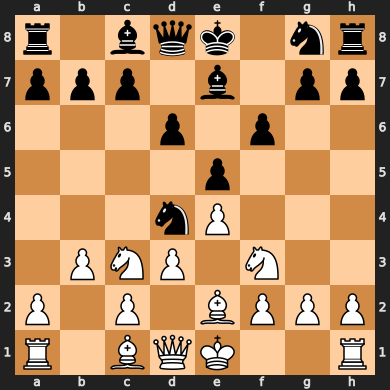

151
(1222, AbsHRBefore                                                         18
AbsHRAfter                                                          18
MoveS                                                              Bb2
MovePGN                                                       ['c1b2']
Time                                                               106
DeltaPos                                                          1.06
Game                                                        Game0814-1
Board                r1bqk1nr/ppp1b1pp/3p1p2/4p3/3nP3/1PNP1N2/PBP1B...
Evaluation                                                        0.19
AbsHRBefore_altro                                                   18
AbsHRAfter_altro                                                    11
Player                                                               w
Name: 1222, dtype: object)


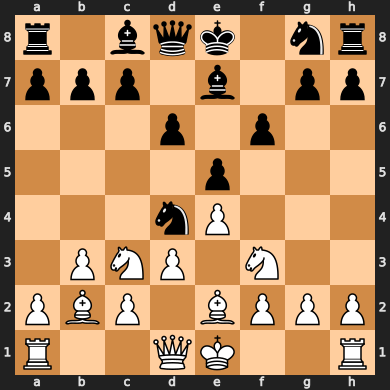

152
(1232, AbsHRBefore                                                          8
AbsHRAfter                                                           8
MoveS                                                              Nd5
MovePGN                                                       ['c3d5']
Time                                                               241
DeltaPos                                                          0.36
Game                                                        Game0814-1
Board                r2q1rk1/ppp1b1pp/3p1p1n/3Np3/4P3/1P1P1Q1P/PBP2...
Evaluation                                                        0.61
AbsHRBefore_altro                                                    9
AbsHRAfter_altro                                                     6
Player                                                               w
Name: 1232, dtype: object)


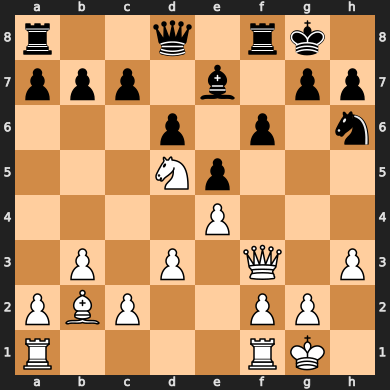

153
(1233, AbsHRBefore                                                          8
AbsHRAfter                                                           9
MoveS                                                               f5
MovePGN                                                       ['f6f5']
Time                                                               278
DeltaPos                                                         -1.05
Game                                                        Game0814-1
Board                r2q1rk1/ppp1b1pp/3p3n/3Npp2/4P3/1P1P1Q1P/PBP2P...
Evaluation                                                        1.66
AbsHRBefore_altro                                                    8
AbsHRAfter_altro                                                     5
Player                                                               b
Name: 1233, dtype: object)


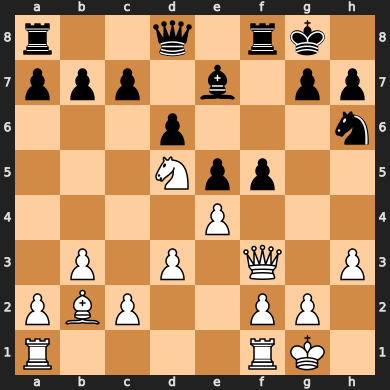

154
(1234, AbsHRBefore                                                          8
AbsHRAfter                                                           8
MoveS                                                               d4
MovePGN                                                       ['d3d4']
Time                                                               297
DeltaPos                                                          0.67
Game                                                        Game0814-1
Board                r2q1rk1/ppp1b1pp/3p3n/3Npp2/3PP3/1P3Q1P/PBP2PP...
Evaluation                                                        0.99
AbsHRBefore_altro                                                    8
AbsHRAfter_altro                                                     9
Player                                                               w
Name: 1234, dtype: object)


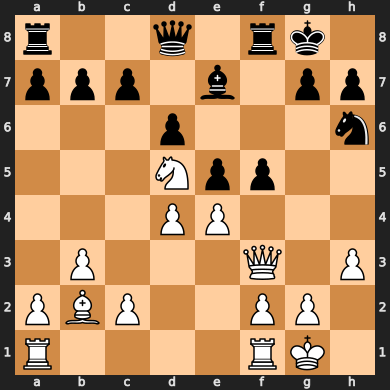

155
(1235, AbsHRBefore                                                          4
AbsHRAfter                                                           6
MoveS                                                             fxe4
MovePGN                                                       ['f5e4']
Time                                                               328
DeltaPos                                                         -1.99
Game                                                        Game0814-1
Board                r2q1rk1/ppp1b1pp/3p3n/3Np3/3Pp3/1P3Q1P/PBP2PP1...
Evaluation                                                        2.98
AbsHRBefore_altro                                                    9
AbsHRAfter_altro                                                     6
Player                                                               b
Name: 1235, dtype: object)


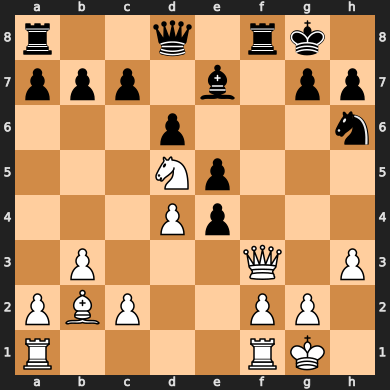

156
(1236, AbsHRBefore                                                          8
AbsHRAfter                                                           8
MoveS                                                             Qxe4
MovePGN                                                       ['f3e4']
Time                                                               342
DeltaPos                                                             0
Game                                                        Game0814-1
Board                r2q1rk1/ppp1b1pp/3p3n/3Np3/3PQ3/1P5P/PBP2PP1/R...
Evaluation                                                        2.98
AbsHRBefore_altro                                                    8
AbsHRAfter_altro                                                     5
Player                                                               w
Name: 1236, dtype: object)


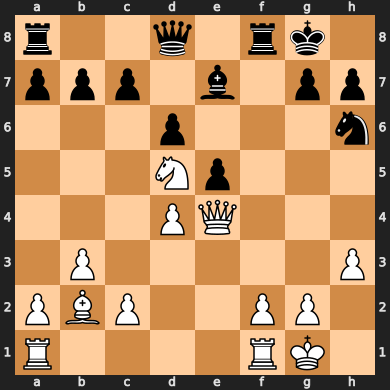

157
(1237, AbsHRBefore                                                          2
AbsHRAfter                                                           3
MoveS                                                               c6
MovePGN                                                       ['c7c6']
Time                                                               368
DeltaPos                                                          0.26
Game                                                        Game0814-1
Board                r2q1rk1/pp2b1pp/2pp3n/3Np3/3PQ3/1P5P/PBP2PP1/R...
Evaluation                                                        2.72
AbsHRBefore_altro                                                    9
AbsHRAfter_altro                                                    14
Player                                                               b
Name: 1237, dtype: object)


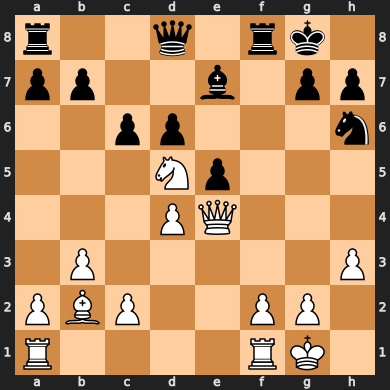

158
(1241, AbsHRBefore                                                          1
AbsHRAfter                                                           1
MoveS                                                              Nf7
MovePGN                                                       ['h6f7']
Time                                                               437
DeltaPos                                                         -0.87
Game                                                        Game0814-1
Board                r4rk1/pp2qnpp/2pp4/4P3/4Q3/1P5P/PBP2PP1/R4RK1 ...
Evaluation                                                        3.87
AbsHRBefore_altro                                                    7
AbsHRAfter_altro                                                     7
Player                                                               b
Name: 1241, dtype: object)


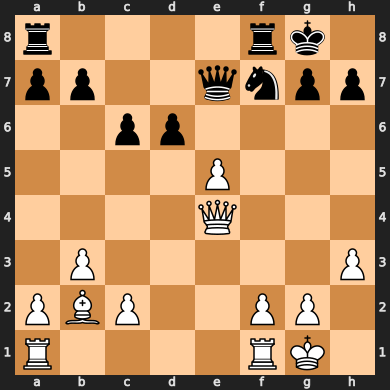

159
(1242, AbsHRBefore                                                         16
AbsHRAfter                                                          16
MoveS                                                              Qg4
MovePGN                                                       ['e4g4']
Time                                                               454
DeltaPos                                                          2.52
Game                                                        Game0814-1
Board                r4rk1/pp2qnpp/2pp4/4P3/6Q1/1P5P/PBP2PP1/R4RK1 ...
Evaluation                                                        1.35
AbsHRBefore_altro                                                   16
AbsHRAfter_altro                                                     8
Player                                                               w
Name: 1242, dtype: object)


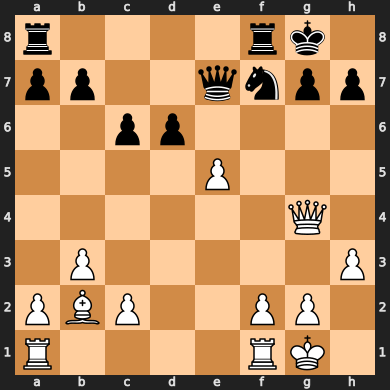

160
(1243, AbsHRBefore                                                         18
AbsHRAfter                                                          18
MoveS                                                             dxe5
MovePGN                                                       ['d6e5']
Time                                                               488
DeltaPos                                                         -0.42
Game                                                        Game0814-1
Board                r4rk1/pp2qnpp/2p5/4p3/6Q1/1P5P/PBP2PP1/R4RK1 w...
Evaluation                                                        1.77
AbsHRBefore_altro                                                   18
AbsHRAfter_altro                                                    11
Player                                                               b
Name: 1243, dtype: object)


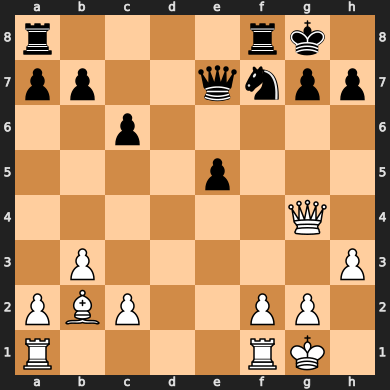

161
(1244, AbsHRBefore                                                         10
AbsHRAfter                                                          10
MoveS                                                             Rfe1
MovePGN                                                       ['f1e1']
Time                                                               510
DeltaPos                                                           0.3
Game                                                        Game0814-1
Board                r4rk1/pp2qnpp/2p5/4p3/6Q1/1P5P/PBP2PP1/R3R1K1 ...
Evaluation                                                        1.47
AbsHRBefore_altro                                                   10
AbsHRAfter_altro                                                     6
Player                                                               w
Name: 1244, dtype: object)


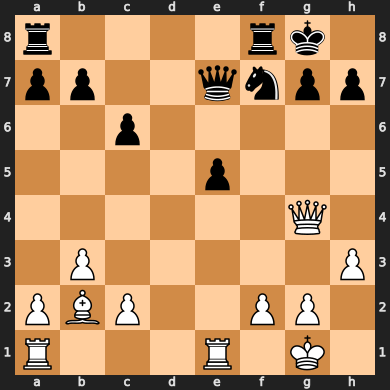

162
(1245, AbsHRBefore                                                          5
AbsHRAfter                                                           4
MoveS                                                              Nh6
MovePGN                                                       ['f7h6']
Time                                                               561
DeltaPos                                                         -1.68
Game                                                        Game0814-1
Board                r4rk1/pp2q1pp/2p4n/4p3/6Q1/1P5P/PBP2PP1/R3R1K1...
Evaluation                                                        3.15
AbsHRBefore_altro                                                   26
AbsHRAfter_altro                                                    27
Player                                                               b
Name: 1245, dtype: object)


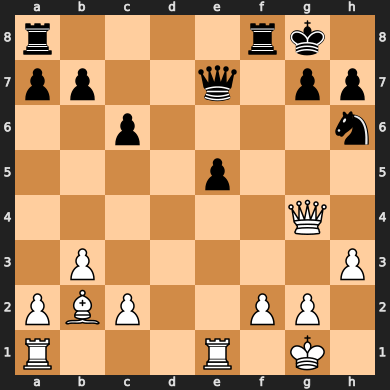

163
(1246, AbsHRBefore                                                          9
AbsHRAfter                                                           7
MoveS                                                              Qg3
MovePGN                                                       ['g4g3']
Time                                                               585
DeltaPos                                                          0.18
Game                                                        Game0814-1
Board                r4rk1/pp2q1pp/2p4n/4p3/8/1P4QP/PBP2PP1/R3R1K1 ...
Evaluation                                                        2.97
AbsHRBefore_altro                                                    9
AbsHRAfter_altro                                                     6
Player                                                               w
Name: 1246, dtype: object)


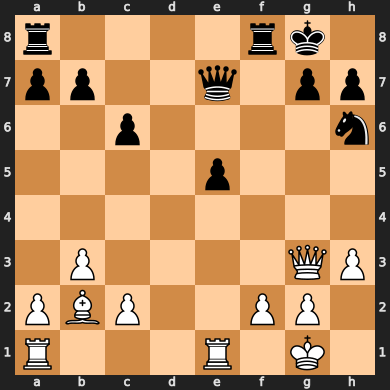

164
(1247, AbsHRBefore                                                         11
AbsHRAfter                                                          10
MoveS                                                              Nf5
MovePGN                                                       ['h6f5']
Time                                                               607
DeltaPos                                                          -0.2
Game                                                        Game0814-1
Board                r4rk1/pp2q1pp/2p5/4pn2/8/1P4QP/PBP2PP1/R3R1K1 ...
Evaluation                                                        3.17
AbsHRBefore_altro                                                   13
AbsHRAfter_altro                                                    14
Player                                                               b
Name: 1247, dtype: object)


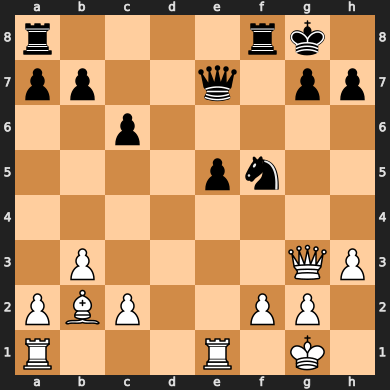

165
(1248, AbsHRBefore                                                         14
AbsHRAfter                                                          12
MoveS                                                             Rxe5
MovePGN                                                       ['e1e5']
Time                                                               638
DeltaPos                                                          0.38
Game                                                        Game0814-1
Board                r4rk1/pp2q1pp/2p5/4Rn2/8/1P4QP/PBP2PP1/R5K1 b ...
Evaluation                                                        3.55
AbsHRBefore_altro                                                   14
AbsHRAfter_altro                                                    11
Player                                                               w
Name: 1248, dtype: object)


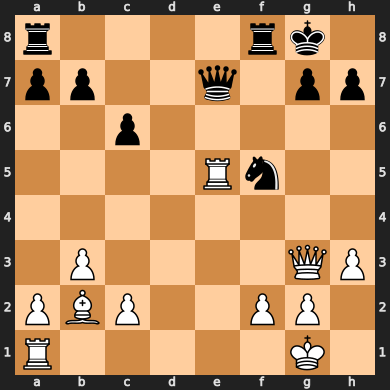

166
(1249, AbsHRBefore                                                          5
AbsHRAfter                                                           2
MoveS                                                              Qh4
MovePGN                                                       ['e7h4']
Time                                                               656
DeltaPos                                                         -4.18
Game                                                        Game0814-1
Board                r4rk1/pp4pp/2p5/4Rn2/7q/1P4QP/PBP2PP1/R5K1 w -...
Evaluation                                                        7.73
AbsHRBefore_altro                                                    8
AbsHRAfter_altro                                                     9
Player                                                               b
Name: 1249, dtype: object)


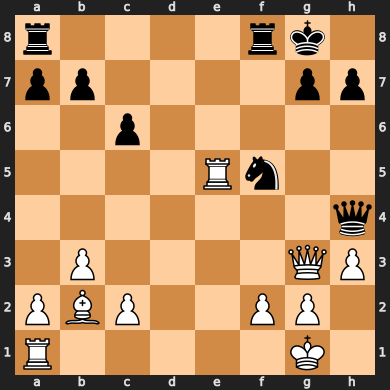

167
(1250, AbsHRBefore                                                         32
AbsHRAfter                                                          32
MoveS                                                              Qg4
MovePGN                                                       ['g3g4']
Time                                                               751
DeltaPos                                                          3.71
Game                                                        Game0814-1
Board                r4rk1/pp4pp/2p5/4Rn2/6Qq/1P5P/PBP2PP1/R5K1 b -...
Evaluation                                                        4.02
AbsHRBefore_altro                                                   32
AbsHRAfter_altro                                                    23
Player                                                               w
Name: 1250, dtype: object)


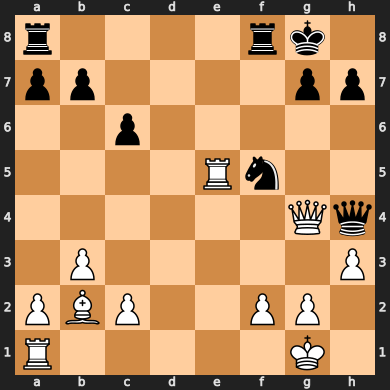

168
(1253, AbsHRBefore                                                         11
AbsHRAfter                                                          10
MoveS                                                              Nh4
MovePGN                                                       ['f5h4']
Time                                                               844
DeltaPos                                                         -1.67
Game                                                        Game0814-1
Board                r4rk1/pp4pp/2p5/4R3/6Pn/1P6/PBP2PP1/R5K1 w - -...
Evaluation                                                        5.96
AbsHRBefore_altro                                                   22
AbsHRAfter_altro                                                    23
Player                                                               b
Name: 1253, dtype: object)


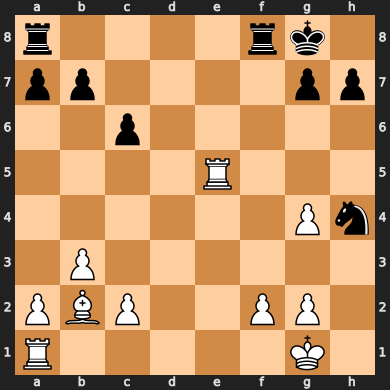

169
(1254, AbsHRBefore                                                         28
AbsHRAfter                                                          29
MoveS                                                              Re7
MovePGN                                                       ['e5e7']
Time                                                               859
DeltaPos                                                          0.06
Game                                                        Game0814-1
Board                r4rk1/pp2R1pp/2p5/8/6Pn/1P6/PBP2PP1/R5K1 b - -...
Evaluation                                                        6.02
AbsHRBefore_altro                                                   28
AbsHRAfter_altro                                                    18
Player                                                               w
Name: 1254, dtype: object)


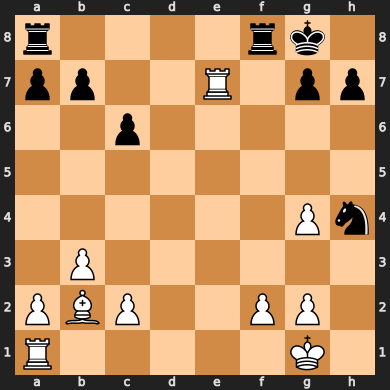

170
(1255, AbsHRBefore                                                         20
AbsHRAfter                                                          20
MoveS                                                              Rf7
MovePGN                                                       ['f8f7']
Time                                                               895
DeltaPos                                                          0.15
Game                                                        Game0814-1
Board                r5k1/pp2Rrpp/2p5/8/6Pn/1P6/PBP2PP1/R5K1 w - - ...
Evaluation                                                        5.87
AbsHRBefore_altro                                                   20
AbsHRAfter_altro                                                    22
Player                                                               b
Name: 1255, dtype: object)


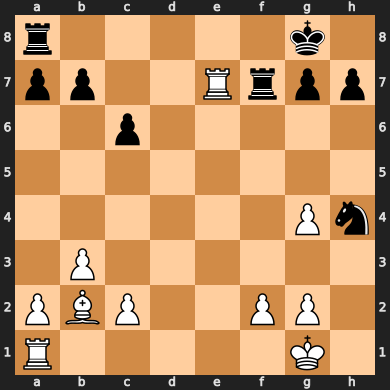

171
(1256, AbsHRBefore                                                         16
AbsHRAfter                                                          16
MoveS                                                             Rae1
MovePGN                                                       ['a1e1']
Time                                                               908
DeltaPos                                                          2.35
Game                                                        Game0814-1
Board                r5k1/pp2Rrpp/2p5/8/6Pn/1P6/PBP2PP1/4R1K1 b - -...
Evaluation                                                        3.52
AbsHRBefore_altro                                                   16
AbsHRAfter_altro                                                    13
Player                                                               w
Name: 1256, dtype: object)


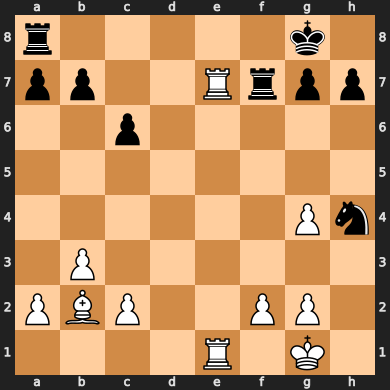

172
(1286, AbsHRBefore                                                         10
AbsHRAfter                                                          10
MoveS                                                             Nfd7
MovePGN                                                       ['f6d7']
Time                                                                93
DeltaPos                                                         -3.04
Game                                                        Game0816-2
Board                rnbqk2r/pppn1ppp/8/4P3/1b1pP3/2NP4/PPP1N1PP/R1...
Evaluation                                                        1.38
AbsHRBefore_altro                                                   10
AbsHRAfter_altro                                                     5
Player                                                               b
Name: 1286, dtype: object)


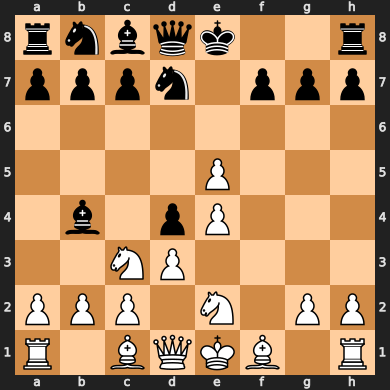

173
(1295, AbsHRBefore                                                          8
AbsHRAfter                                                           8
MoveS                                                            Nxc7+
MovePGN                                                       ['b5c7']
Time                                                               303
DeltaPos                                                           0.5
Game                                                        Game0816-2
Board                rnb1k2r/ppN2ppp/8/4n3/4P3/3P4/PqPQ2PP/R3KB1R b...
Evaluation                                                       -6.87
AbsHRBefore_altro                                                    8
AbsHRAfter_altro                                                     6
Player                                                               w
Name: 1295, dtype: object)


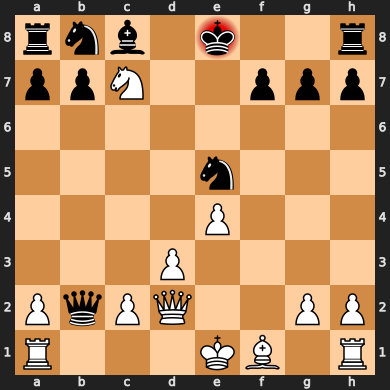

174
(1296, AbsHRBefore                                                          9
AbsHRAfter                                                           9
MoveS                                                              Kd8
MovePGN                                                       ['e8d8']
Time                                                               315
DeltaPos                                                          0.59
Game                                                        Game0816-2
Board                rnbk3r/ppN2ppp/8/4n3/4P3/3P4/PqPQ2PP/R3KB1R w ...
Evaluation                                                       -7.46
AbsHRBefore_altro                                                    9
AbsHRAfter_altro                                                    10
Player                                                               b
Name: 1296, dtype: object)


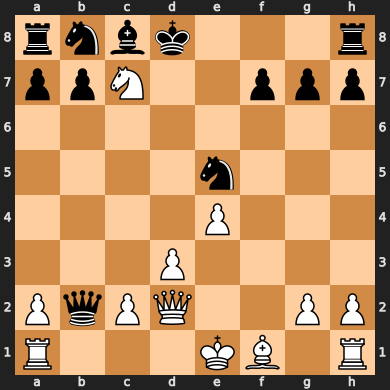

175
(1328, AbsHRBefore                                                          4
AbsHRAfter                                                           4
MoveS                                                               a6
MovePGN                                                       ['a7a6']
Time                                                               118
DeltaPos                                                         -0.12
Game                                                        Game0816-5
Board                r2qkb1r/1p1b1ppp/p2p1n2/1B2p3/Q3P3/2N5/PPP2PPP...
Evaluation                                                         0.7
AbsHRBefore_altro                                                    4
AbsHRAfter_altro                                                    10
Player                                                               b
Name: 1328, dtype: object)


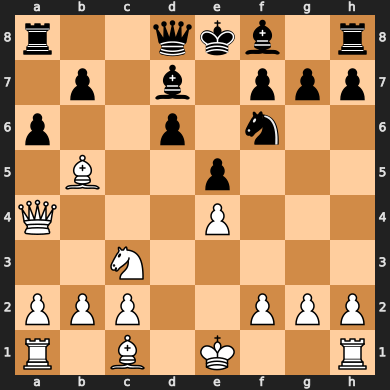

176
(1329, AbsHRBefore                                                          8
AbsHRAfter                                                           8
MoveS                                                            Bxd7+
MovePGN                                                       ['b5d7']
Time                                                               134
DeltaPos                                                          0.04
Game                                                        Game0816-5
Board                r2qkb1r/1p1B1ppp/p2p1n2/4p3/Q3P3/2N5/PPP2PPP/R...
Evaluation                                                        0.66
AbsHRBefore_altro                                                    8
AbsHRAfter_altro                                                     5
Player                                                               w
Name: 1329, dtype: object)


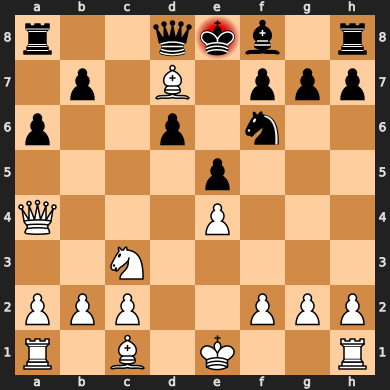

177
(1335, AbsHRBefore                                                          4
AbsHRAfter                                                           3
MoveS                                                               c3
MovePGN                                                       ['c2c3']
Time                                                               181
DeltaPos                                                          0.24
Game                                                        Game0816-5
Board                2r1kb1r/1p1n1ppp/p2p4/3Np3/4P3/2P5/PP3PPP/R1B1...
Evaluation                                                        0.61
AbsHRBefore_altro                                                    9
AbsHRAfter_altro                                                     9
Player                                                               w
Name: 1335, dtype: object)


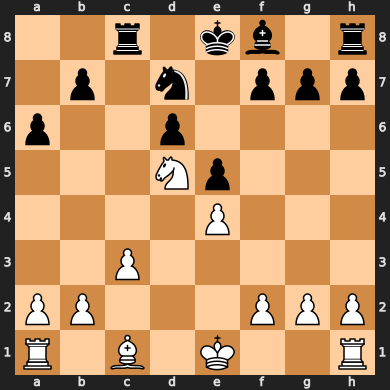

178
(1339, AbsHRBefore                                                         14
AbsHRAfter                                                          14
MoveS                                                               f3
MovePGN                                                       ['f2f3']
Time                                                               245
DeltaPos                                                          0.03
Game                                                        Game0816-5
Board                2r1k2r/1p1n1pbp/p2p2p1/3Np3/4P3/2P2P2/PP4PP/R1...
Evaluation                                                        0.69
AbsHRBefore_altro                                                   27
AbsHRAfter_altro                                                    30
Player                                                               w
Name: 1339, dtype: object)


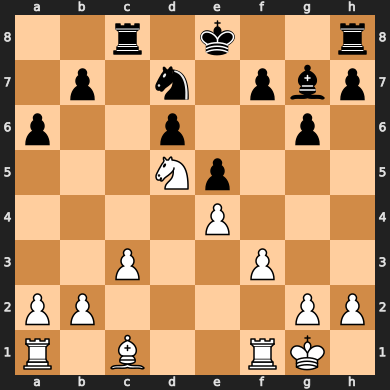

179
(1340, AbsHRBefore                                                          4
AbsHRAfter                                                           6
MoveS                                                              Nf6
MovePGN                                                       ['d7f6']
Time                                                               281
DeltaPos                                                         -0.19
Game                                                        Game0816-5
Board                2r1k2r/1p3pbp/p2p1np1/3Np3/4P3/2P2P2/PP4PP/R1B...
Evaluation                                                        0.88
AbsHRBefore_altro                                                   15
AbsHRAfter_altro                                                    13
Player                                                               b
Name: 1340, dtype: object)


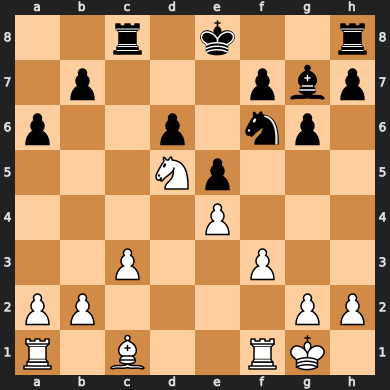

180
(1341, AbsHRBefore                                                         10
AbsHRAfter                                                           8
MoveS                                                              Nb6
MovePGN                                                       ['d5b6']
Time                                                               301
DeltaPos                                                          0.18
Game                                                        Game0816-5
Board                2r1k2r/1p3pbp/pN1p1np1/4p3/4P3/2P2P2/PP4PP/R1B...
Evaluation                                                        1.06
AbsHRBefore_altro                                                   10
AbsHRAfter_altro                                                     7
Player                                                               w
Name: 1341, dtype: object)


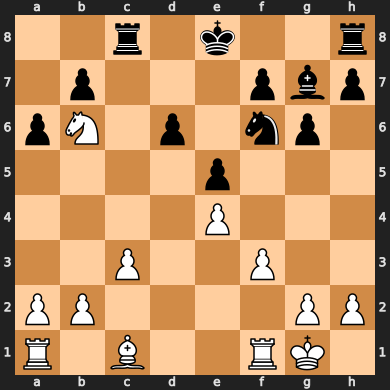

181
(1342, AbsHRBefore                                                          6
AbsHRAfter                                                           7
MoveS                                                              Rc6
MovePGN                                                       ['c8c6']
Time                                                               313
DeltaPos                                                          0.31
Game                                                        Game0816-5
Board                4k2r/1p3pbp/pNrp1np1/4p3/4P3/2P2P2/PP4PP/R1B2R...
Evaluation                                                        0.75
AbsHRBefore_altro                                                    7
AbsHRAfter_altro                                                     8
Player                                                               b
Name: 1342, dtype: object)


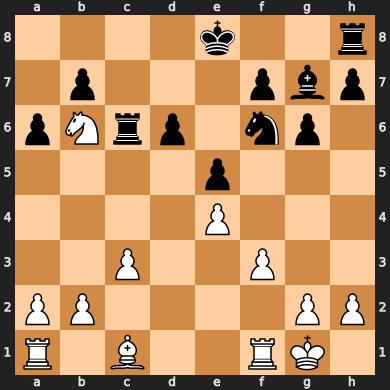

182
(1343, AbsHRBefore                                                          8
AbsHRAfter                                                           8
MoveS                                                              Be3
MovePGN                                                       ['c1e3']
Time                                                               338
DeltaPos                                                          0.26
Game                                                        Game0816-5
Board                4k2r/1p3pbp/pNrp1np1/4p3/4P3/2P1BP2/PP4PP/R4RK...
Evaluation                                                        1.01
AbsHRBefore_altro                                                    8
AbsHRAfter_altro                                                     6
Player                                                               w
Name: 1343, dtype: object)


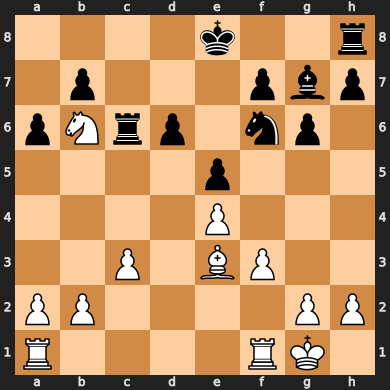

183
(1344, AbsHRBefore                                                          1
AbsHRAfter                                                           1
MoveS                                                              O-O
MovePGN                                                       ['e8g8']
Time                                                               353
DeltaPos                                                         -0.73
Game                                                        Game0816-5
Board                5rk1/1p3pbp/pNrp1np1/4p3/4P3/2P1BP2/PP4PP/R4RK...
Evaluation                                                        1.74
AbsHRBefore_altro                                                    7
AbsHRAfter_altro                                                     8
Player                                                               b
Name: 1344, dtype: object)


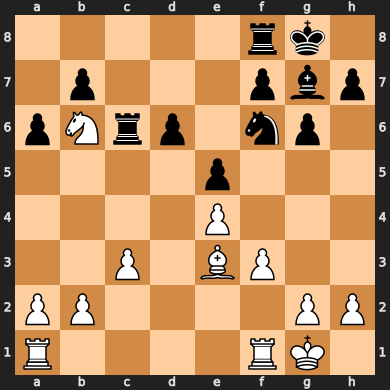

184
(1347, AbsHRBefore                                                         12
AbsHRAfter                                                          12
MoveS                                                               b3
MovePGN                                                       ['b2b3']
Time                                                               424
DeltaPos                                                          0.97
Game                                                        Game0816-5
Board                3r2k1/1p3pbp/pNrp1np1/4p3/4P3/1PP1BP2/P5PP/2R2...
Evaluation                                                        0.38
AbsHRBefore_altro                                                   15
AbsHRAfter_altro                                                    17
Player                                                               w
Name: 1347, dtype: object)


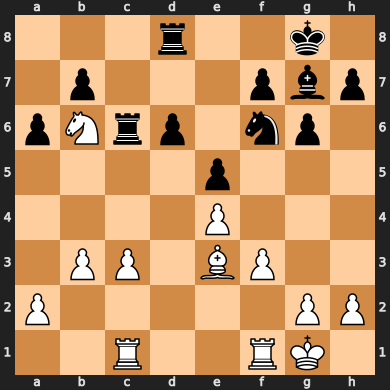

185
(1348, AbsHRBefore                                                          5
AbsHRAfter                                                           5
MoveS                                                               d5
MovePGN                                                       ['d6d5']
Time                                                               451
DeltaPos                                                         -3.29
Game                                                        Game0816-5
Board                3r2k1/1p3pbp/pNr2np1/3pp3/4P3/1PP1BP2/P5PP/2R2...
Evaluation                                                        3.67
AbsHRBefore_altro                                                    8
AbsHRAfter_altro                                                    11
Player                                                               b
Name: 1348, dtype: object)


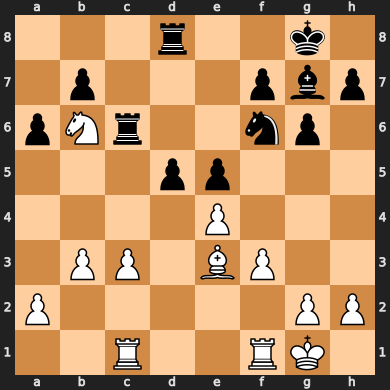

186
(1349, AbsHRBefore                                                         10
AbsHRAfter                                                          10
MoveS                                                             Nxd5
MovePGN                                                       ['b6d5']
Time                                                               462
DeltaPos                                                          3.43
Game                                                        Game0816-5
Board                3r2k1/1p3pbp/p1r2np1/3Np3/4P3/1PP1BP2/P5PP/2R2...
Evaluation                                                        0.24
AbsHRBefore_altro                                                   10
AbsHRAfter_altro                                                    11
Player                                                               w
Name: 1349, dtype: object)


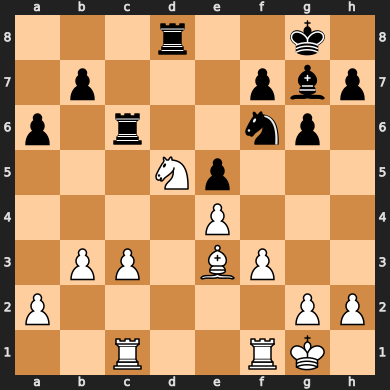

187
(1354, AbsHRBefore                                                         30
AbsHRAfter                                                          28
MoveS                                                              Rd7
MovePGN                                                       ['d5d7']
Time                                                               529
DeltaPos                                                          0.13
Game                                                        Game0816-5
Board                6k1/1p1r1pbp/p1r3p1/4p3/2P5/1P2BP2/P5PP/2R2RK1...
Evaluation                                                        0.37
AbsHRBefore_altro                                                   30
AbsHRAfter_altro                                                    10
Player                                                               b
Name: 1354, dtype: object)


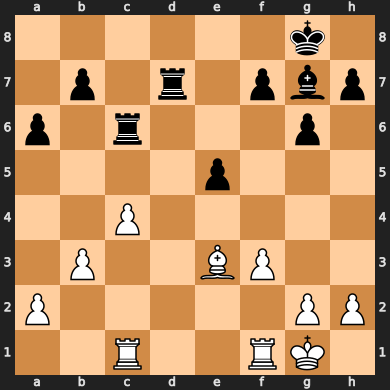

188
(1355, AbsHRBefore                                                          6
AbsHRAfter                                                           2
MoveS                                                             Rcd1
MovePGN                                                       ['c1d1']
Time                                                               558
DeltaPos                                                          0.29
Game                                                        Game0816-5
Board                6k1/1p1r1pbp/p1r3p1/4p3/2P5/1P2BP2/P5PP/3R1RK1...
Evaluation                                                        0.08
AbsHRBefore_altro                                                   13
AbsHRAfter_altro                                                    16
Player                                                               w
Name: 1355, dtype: object)


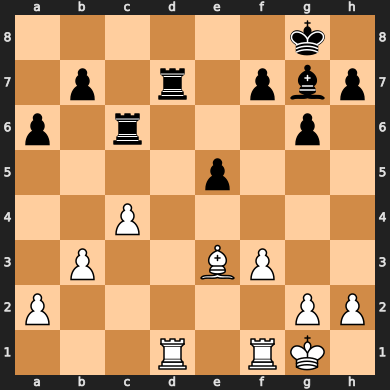

189
(1356, AbsHRBefore                                                         24
AbsHRAfter                                                          24
MoveS                                                              Re7
MovePGN                                                       ['d7e7']
Time                                                               585
DeltaPos                                                        -19.92
Game                                                        Game0816-5
Board                6k1/1p2rpbp/p1r3p1/4p3/2P5/1P2BP2/P5PP/3R1RK1 ...
Evaluation                                                          20
AbsHRBefore_altro                                                   24
AbsHRAfter_altro                                                    10
Player                                                               b
Name: 1356, dtype: object)


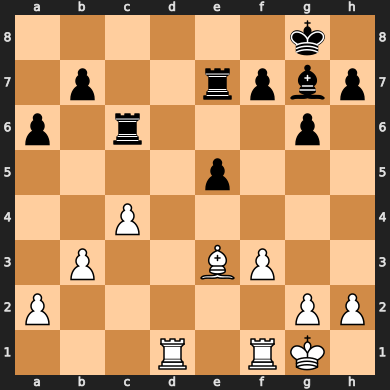

190
(1357, AbsHRBefore                                                         14
AbsHRAfter                                                          14
MoveS                                                             Rfe1
MovePGN                                                       ['f1e1']
Time                                                               619
DeltaPos                                                         19.46
Game                                                        Game0816-5
Board                6k1/1p2rpbp/p1r3p1/4p3/2P5/1P2BP2/P5PP/3RR1K1 ...
Evaluation                                                        0.54
AbsHRBefore_altro                                                   20
AbsHRAfter_altro                                                    20
Player                                                               w
Name: 1357, dtype: object)


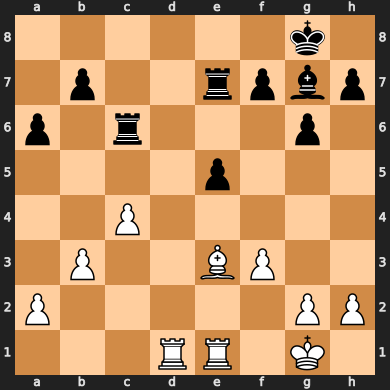

191
(1358, AbsHRBefore                                                         14
AbsHRAfter                                                          14
MoveS                                                               e4
MovePGN                                                       ['e5e4']
Time                                                               654
DeltaPos                                                        -19.46
Game                                                        Game0816-5
Board                6k1/1p2rpbp/p1r3p1/8/2P1p3/1P2BP2/P5PP/3RR1K1 ...
Evaluation                                                          20
AbsHRBefore_altro                                                   14
AbsHRAfter_altro                                                    15
Player                                                               b
Name: 1358, dtype: object)


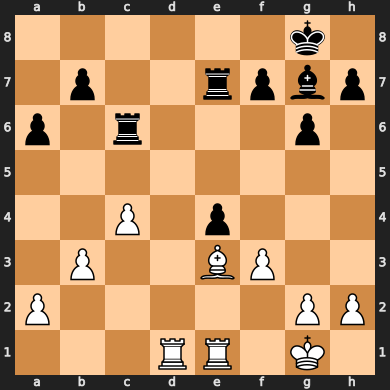

192
(1359, AbsHRBefore                                                          2
AbsHRAfter                                                           2
MoveS                                                              Bg5
MovePGN                                                       ['e3g5']
Time                                                               670
DeltaPos                                                         19.14
Game                                                        Game0816-5
Board                6k1/1p2rpbp/p1r3p1/6B1/2P1p3/1P3P2/P5PP/3RR1K1...
Evaluation                                                        0.86
AbsHRBefore_altro                                                    6
AbsHRAfter_altro                                                     5
Player                                                               w
Name: 1359, dtype: object)


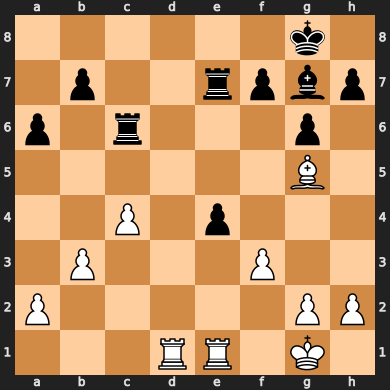

193
(1360, AbsHRBefore                                                         18
AbsHRAfter                                                          19
MoveS                                                               f6
MovePGN                                                       ['f7f6']
Time                                                               723
DeltaPos                                                         -0.46
Game                                                        Game0816-5
Board                6k1/1p2r1bp/p1r2pp1/6B1/2P1p3/1P3P2/P5PP/3RR1K...
Evaluation                                                        1.32
AbsHRBefore_altro                                                   18
AbsHRAfter_altro                                                     5
Player                                                               b
Name: 1360, dtype: object)


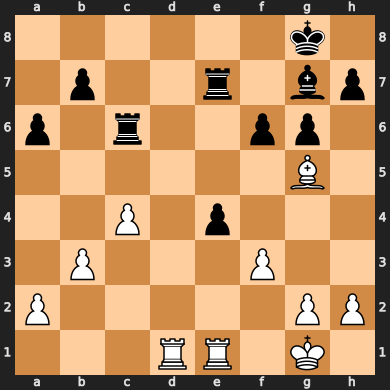

194
(1361, AbsHRBefore                                                          8
AbsHRAfter                                                          10
MoveS                                                              Bh4
MovePGN                                                       ['g5h4']
Time                                                               741
DeltaPos                                                          0.88
Game                                                        Game0816-5
Board                6k1/1p2r1bp/p1r2pp1/8/2P1p2B/1P3P2/P5PP/3RR1K1...
Evaluation                                                        0.44
AbsHRBefore_altro                                                    8
AbsHRAfter_altro                                                    13
Player                                                               w
Name: 1361, dtype: object)


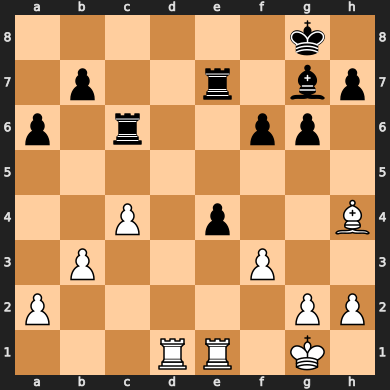

195
(1362, AbsHRBefore                                                         20
AbsHRAfter                                                          21
MoveS                                                               g5
MovePGN                                                       ['g6g5']
Time                                                               754
DeltaPos                                                         -0.55
Game                                                        Game0816-5
Board                6k1/1p2r1bp/p1r2p2/6p1/2P1p2B/1P3P2/P5PP/3RR1K...
Evaluation                                                        0.99
AbsHRBefore_altro                                                   20
AbsHRAfter_altro                                                     7
Player                                                               b
Name: 1362, dtype: object)


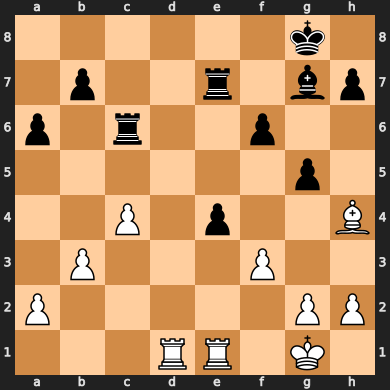

196
(1366, AbsHRBefore                                                         29
AbsHRAfter                                                          28
MoveS                                                               h6
MovePGN                                                       ['h7h6']
Time                                                               802
DeltaPos                                                         -0.71
Game                                                        Game0816-5
Board                6k1/1p2r1b1/p1r4p/5pp1/2P1p2P/1P3PB1/P5P1/3RR1...
Evaluation                                                        0.63
AbsHRBefore_altro                                                   29
AbsHRAfter_altro                                                     7
Player                                                               b
Name: 1366, dtype: object)


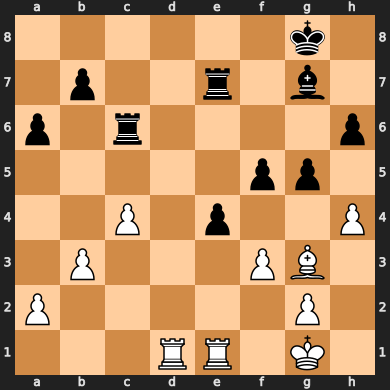

197
(1367, AbsHRBefore                                                          6
AbsHRAfter                                                           7
MoveS                                                              Re3
MovePGN                                                       ['e1e3']
Time                                                               821
DeltaPos                                                          4.03
Game                                                        Game0816-5
Board                6k1/1p2r1b1/p1r4p/5pp1/2P1p2P/1P2RPB1/P5P1/3R2...
Evaluation                                                        -3.4
AbsHRBefore_altro                                                   17
AbsHRAfter_altro                                                    22
Player                                                               w
Name: 1367, dtype: object)


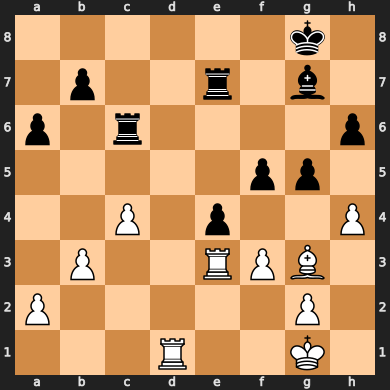

198
(1368, AbsHRBefore                                                         38
AbsHRAfter                                                          41
MoveS                                                               f4
MovePGN                                                       ['f5f4']
Time                                                               865
DeltaPos                                                          0.67
Game                                                        Game0816-5
Board                6k1/1p2r1b1/p1r4p/6p1/2P1pp1P/1P2RPB1/P5P1/3R2...
Evaluation                                                       -4.07
AbsHRBefore_altro                                                   38
AbsHRAfter_altro                                                     6
Player                                                               b
Name: 1368, dtype: object)


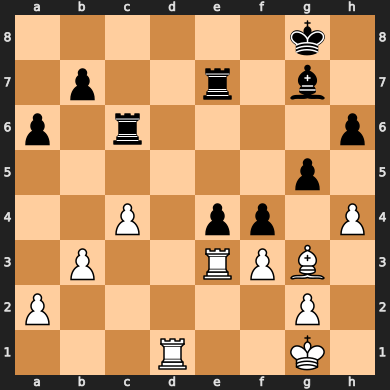

199
(1375, AbsHRBefore                                                          5
AbsHRAfter                                                           5
MoveS                                                              Re1
MovePGN                                                       ['d1e1']
Time                                                               952
DeltaPos                                                          0.55
Game                                                        Game0816-5
Board                6k1/1p4b1/p1r5/6Pp/2P1P3/1P4p1/P5P1/4R1K1 b - ...
Evaluation                                                       -6.59
AbsHRBefore_altro                                                   19
AbsHRAfter_altro                                                    21
Player                                                               w
Name: 1375, dtype: object)


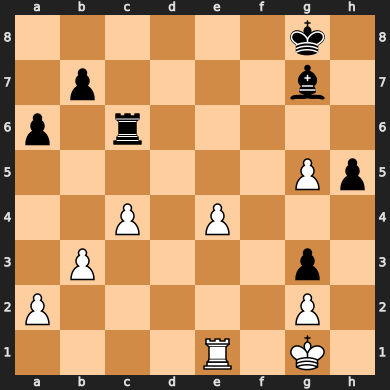

200
(1376, AbsHRBefore                                                         48
AbsHRAfter                                                          49
MoveS                                                              Rg6
MovePGN                                                       ['c6g6']
Time                                                               968
DeltaPos                                                         -0.21
Game                                                        Game0816-5
Board                6k1/1p4b1/p5r1/6Pp/2P1P3/1P4p1/P5P1/4R1K1 w - ...
Evaluation                                                       -6.38
AbsHRBefore_altro                                                   48
AbsHRAfter_altro                                                     6
Player                                                               b
Name: 1376, dtype: object)


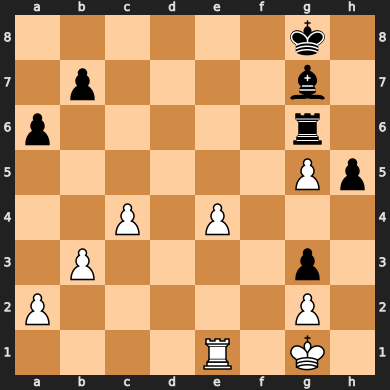

201
(1380, AbsHRBefore                                                         48
AbsHRAfter                                                          48
MoveS                                                              Re5
MovePGN                                                       ['g5e5']
Time                                                              1008
DeltaPos                                                         -0.08
Game                                                        Game0816-5
Board                6k1/1p4b1/p3P3/4r2p/2P5/1P4p1/P5P1/4R1K1 w - -...
Evaluation                                                       -7.68
AbsHRBefore_altro                                                   48
AbsHRAfter_altro                                                    15
Player                                                               b
Name: 1380, dtype: object)


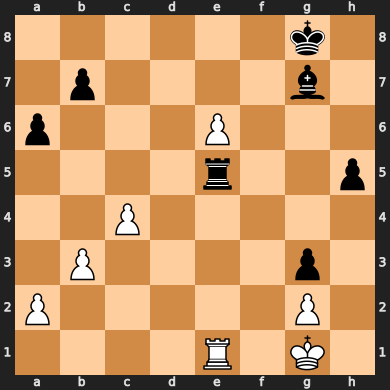

202
(1475, AbsHRBefore                                                         10
AbsHRAfter                                                          10
MoveS                                                             Nxd4
MovePGN                                                       ['e2d4']
Time                                                               154
DeltaPos                                                          0.36
Game                                                        Game0816-4
Board                rn2kbnr/pp1q1pp1/4p2p/1Q1pP3/3N3P/2N5/PPP2PP1/...
Evaluation                                                       -0.67
AbsHRBefore_altro                                                   10
AbsHRAfter_altro                                                     8
Player                                                               w
Name: 1475, dtype: object)


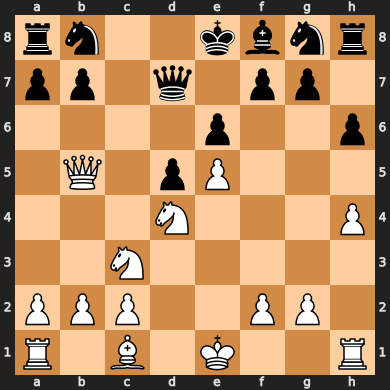

203
(1476, AbsHRBefore                                                          6
AbsHRAfter                                                           4
MoveS                                                               a6
MovePGN                                                       ['a7a6']
Time                                                               186
DeltaPos                                                         -0.27
Game                                                        Game0816-4
Board                rn2kbnr/1p1q1pp1/p3p2p/1Q1pP3/3N3P/2N5/PPP2PP1...
Evaluation                                                        -0.4
AbsHRBefore_altro                                                    9
AbsHRAfter_altro                                                    11
Player                                                               b
Name: 1476, dtype: object)


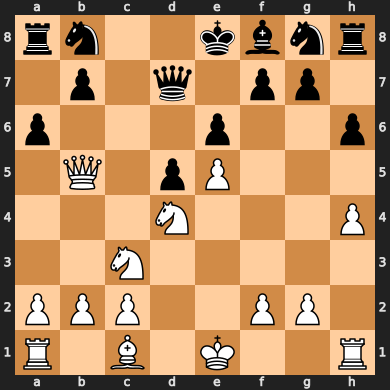

204
(1486, AbsHRBefore                                                          2
AbsHRAfter                                                           4
MoveS                                                              Bb6
MovePGN                                                       ['c5b6']
Time                                                               269
DeltaPos                                                         -0.27
Game                                                        Game0816-4
Board                r3k1nr/1p1n1pp1/pb2p2p/3p4/5B1P/PNN5/1PP2PP1/R...
Evaluation                                                       -2.69
AbsHRBefore_altro                                                    6
AbsHRAfter_altro                                                     5
Player                                                               b
Name: 1486, dtype: object)


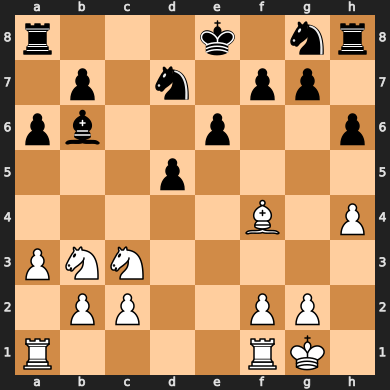

205
(1487, AbsHRBefore                                                          6
AbsHRAfter                                                           6
MoveS                                                              Na4
MovePGN                                                       ['c3a4']
Time                                                               282
DeltaPos                                                          0.29
Game                                                        Game0816-4
Board                r3k1nr/1p1n1pp1/pb2p2p/3p4/N4B1P/PN6/1PP2PP1/R...
Evaluation                                                       -2.98
AbsHRBefore_altro                                                    6
AbsHRAfter_altro                                                     8
Player                                                               w
Name: 1487, dtype: object)


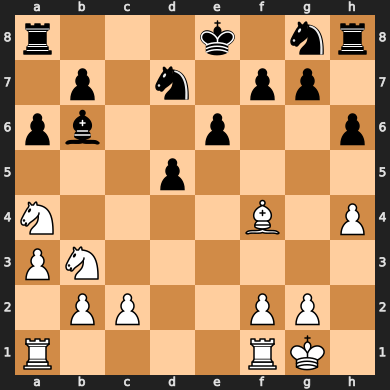

206
(1497, AbsHRBefore                                                         18
AbsHRAfter                                                          18
MoveS                                                               c3
MovePGN                                                       ['c2c3']
Time                                                               374
DeltaPos                                                           1.4
Game                                                        Game0816-4
Board                r5nr/3k1pp1/pp2pb1p/3p4/1P1N1B2/P1P5/5PP1/R4RK...
Evaluation                                                       -7.06
AbsHRBefore_altro                                                   18
AbsHRAfter_altro                                                    14
Player                                                               w
Name: 1497, dtype: object)


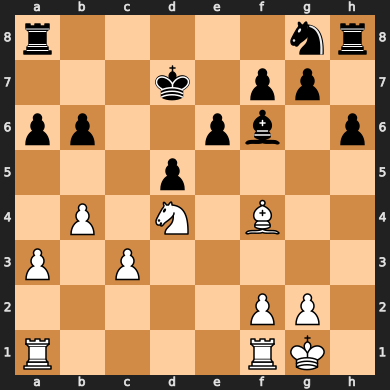

207
(1498, AbsHRBefore                                                          5
AbsHRAfter                                                           4
MoveS                                                               e5
MovePGN                                                       ['e6e5']
Time                                                               385
DeltaPos                                                         -0.06
Game                                                        Game0816-4
Board                r5nr/3k1pp1/pp3b1p/3pp3/1P1N1B2/P1P5/5PP1/R4RK...
Evaluation                                                          -7
AbsHRBefore_altro                                                   17
AbsHRAfter_altro                                                    17
Player                                                               b
Name: 1498, dtype: object)


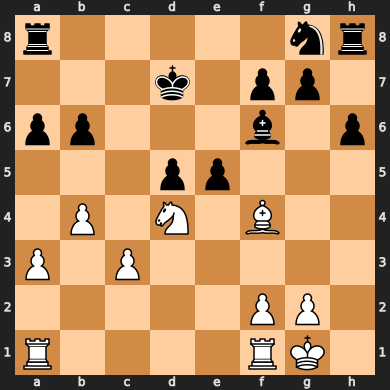

208
(1529, AbsHRBefore                                                          3
AbsHRAfter                                                           3
MoveS                                                             Nxe5
MovePGN                                                       ['f3e5']
Time                                                               102
DeltaPos                                                          0.01
Game                                                        Game0816-3
Board                r1bqk1nr/3p1ppp/p1p5/2b1N3/4P3/8/PPP2PPP/RNBQK...
Evaluation                                                         0.6
AbsHRBefore_altro                                                   11
AbsHRAfter_altro                                                    10
Player                                                               w
Name: 1529, dtype: object)


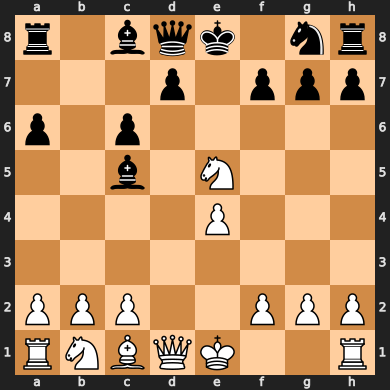

209
(1530, AbsHRBefore                                                         32
AbsHRAfter                                                          34
MoveS                                                            Bxf2+
MovePGN                                                       ['c5f2']
Time                                                               136
DeltaPos                                                         -5.23
Game                                                        Game0816-3
Board                r1bqk1nr/3p1ppp/p1p5/4N3/4P3/8/PPP2bPP/RNBQK2R...
Evaluation                                                        5.83
AbsHRBefore_altro                                                   32
AbsHRAfter_altro                                                     4
Player                                                               b
Name: 1530, dtype: object)


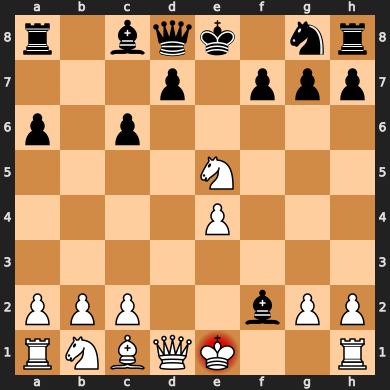

210
(1536, AbsHRBefore                                                          2
AbsHRAfter                                                           4
MoveS                                                             Ng4+
MovePGN                                                       ['h6g4']
Time                                                               232
DeltaPos                                                         -0.49
Game                                                        Game0816-3
Board                r1b1k2r/3p1ppp/p1p2q2/6B1/4P1n1/5N2/PPP2KPP/RN...
Evaluation                                                        6.18
AbsHRBefore_altro                                                   15
AbsHRAfter_altro                                                     9
Player                                                               b
Name: 1536, dtype: object)


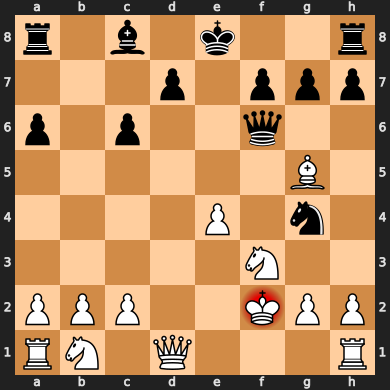

211
(1537, AbsHRBefore                                                         12
AbsHRAfter                                                          13
MoveS                                                              Kg3
MovePGN                                                       ['f2g3']
Time                                                               253
DeltaPos                                                          1.65
Game                                                        Game0816-3
Board                r1b1k2r/3p1ppp/p1p2q2/6B1/4P1n1/5NK1/PPP3PP/RN...
Evaluation                                                        4.53
AbsHRBefore_altro                                                   12
AbsHRAfter_altro                                                     8
Player                                                               w
Name: 1537, dtype: object)


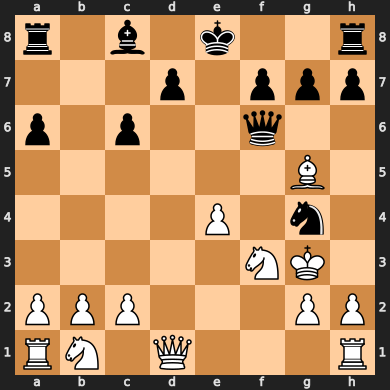

212
(1538, AbsHRBefore                                                          4
AbsHRAfter                                                           5
MoveS                                                              Qe6
MovePGN                                                       ['f6e6']
Time                                                               272
DeltaPos                                                         -1.73
Game                                                        Game0816-3
Board                r1b1k2r/3p1ppp/p1p1q3/6B1/4P1n1/5NK1/PPP3PP/RN...
Evaluation                                                        6.26
AbsHRBefore_altro                                                   13
AbsHRAfter_altro                                                    10
Player                                                               b
Name: 1538, dtype: object)


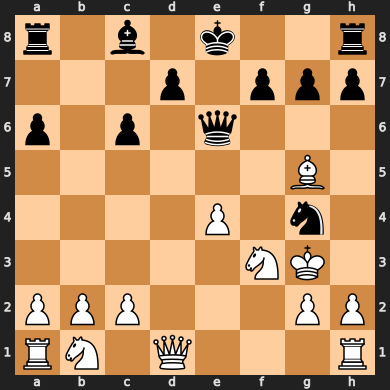

213
(1539, AbsHRBefore                                                          2
AbsHRAfter                                                           2
MoveS                                                              Nc3
MovePGN                                                       ['b1c3']
Time                                                               292
DeltaPos                                                          0.34
Game                                                        Game0816-3
Board                r1b1k2r/3p1ppp/p1p1q3/6B1/4P1n1/2N2NK1/PPP3PP/...
Evaluation                                                         6.6
AbsHRBefore_altro                                                    6
AbsHRAfter_altro                                                     8
Player                                                               w
Name: 1539, dtype: object)


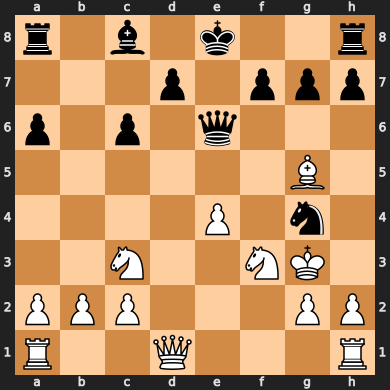

214
(1542, AbsHRBefore                                                         52
AbsHRAfter                                                          52
MoveS                                                             Qd6+
MovePGN                                                       ['e6d6']
Time                                                               337
DeltaPos                                                         -4.13
Game                                                        Game0816-3
Board                r1b1k2r/5ppp/p1pq4/3p2B1/4P1n1/2N2NK1/PPP3PP/R...
Evaluation                                                       10.97
AbsHRBefore_altro                                                   52
AbsHRAfter_altro                                                     7
Player                                                               b
Name: 1542, dtype: object)


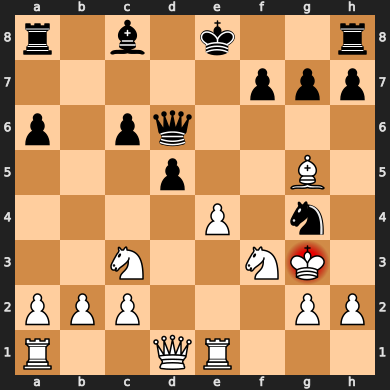

215
(1543, AbsHRBefore                                                          1
AbsHRAfter                                                           1
MoveS                                                              Bf4
MovePGN                                                       ['g5f4']
Time                                                               353
DeltaPos                                                          0.05
Game                                                        Game0816-3
Board                r1b1k2r/5ppp/p1pq4/3p4/4PBn1/2N2NK1/PPP3PP/R2Q...
Evaluation                                                       11.02
AbsHRBefore_altro                                                   22
AbsHRAfter_altro                                                    18
Player                                                               w
Name: 1543, dtype: object)


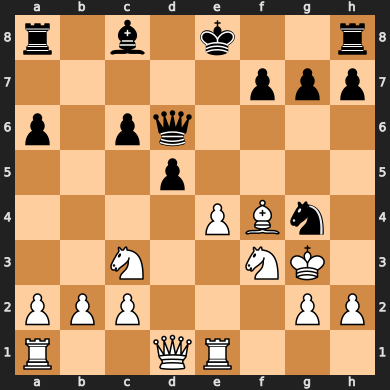

216
(1546, AbsHRBefore                                                         10
AbsHRAfter                                                          11
MoveS                                                              Kf8
MovePGN                                                       ['e8f8']
Time                                                               401
DeltaPos                                                         -1.94
Game                                                        Game0816-3
Board                r1b2k1r/5ppp/p1p3q1/3P4/5Bn1/2N2NK1/PPP3PP/R2Q...
Evaluation                                                       11.04
AbsHRBefore_altro                                                   13
AbsHRAfter_altro                                                    12
Player                                                               b
Name: 1546, dtype: object)


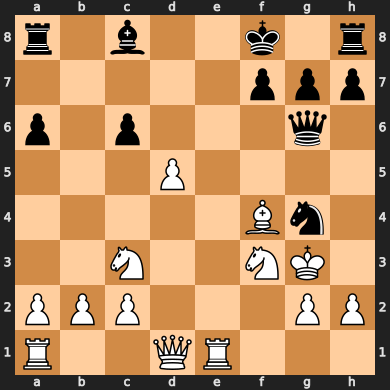

217
(1547, AbsHRBefore                                                         10
AbsHRAfter                                                          10
MoveS                                                             dxc6
MovePGN                                                       ['d5c6']
Time                                                               454
DeltaPos                                                           6.7
Game                                                        Game0816-3
Board                r1b2k1r/5ppp/p1P3q1/8/5Bn1/2N2NK1/PPP3PP/R2QR3...
Evaluation                                                        4.34
AbsHRBefore_altro                                                   10
AbsHRAfter_altro                                                     7
Player                                                               w
Name: 1547, dtype: object)


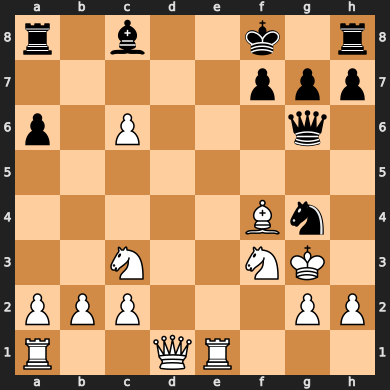

218
(1548, AbsHRBefore                                                         20
AbsHRAfter                                                          31
MoveS                                                             Ne3+
MovePGN                                                       ['g4e3']
Time                                                               469
DeltaPos                                                         -1.24
Game                                                        Game0816-3
Board                r1b2k1r/5ppp/p1P3q1/8/5B2/2N1nNK1/PPP3PP/R2QR3...
Evaluation                                                        5.58
AbsHRBefore_altro                                                   20
AbsHRAfter_altro                                                     9
Player                                                               b
Name: 1548, dtype: object)


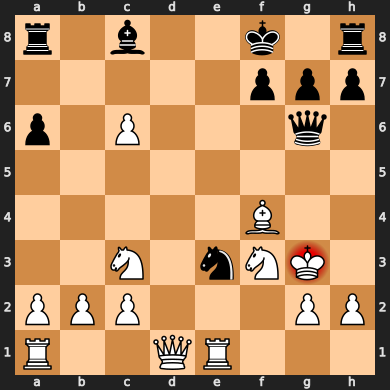

219
(1552, AbsHRBefore                                                         10
AbsHRAfter                                                          11
MoveS                                                              Be6
MovePGN                                                       ['c8e6']
Time                                                               563
DeltaPos                                                         -0.68
Game                                                        Game0816-3
Board                r4k1r/5ppp/p1P1b1q1/8/5B2/2N2N2/PPP2KPP/3RR3 w...
Evaluation                                                        5.99
AbsHRBefore_altro                                                   10
AbsHRAfter_altro                                                    11
Player                                                               b
Name: 1552, dtype: object)


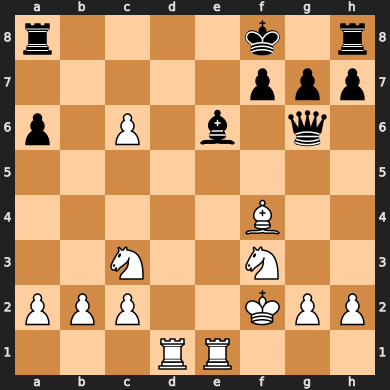

220
(1553, AbsHRBefore                                                         34
AbsHRAfter                                                          34
MoveS                                                               c7
MovePGN                                                       ['c6c7']
Time                                                               595
DeltaPos                                                          0.11
Game                                                        Game0816-3
Board                r4k1r/2P2ppp/p3b1q1/8/5B2/2N2N2/PPP2KPP/3RR3 b...
Evaluation                                                         6.1
AbsHRBefore_altro                                                   34
AbsHRAfter_altro                                                    19
Player                                                               w
Name: 1553, dtype: object)


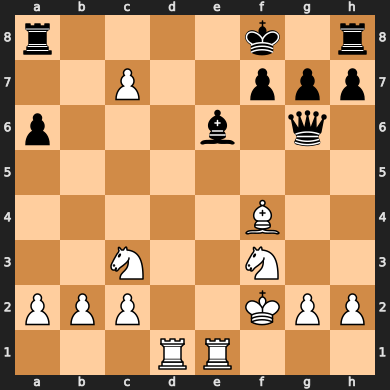

221
(1554, AbsHRBefore                                                         12
AbsHRAfter                                                          14
MoveS                                                              Qf6
MovePGN                                                       ['g6f6']
Time                                                               631
DeltaPos                                                          -4.8
Game                                                        Game0816-3
Board                r4k1r/2P2ppp/p3bq2/8/5B2/2N2N2/PPP2KPP/3RR3 w ...
Evaluation                                                        10.9
AbsHRBefore_altro                                                   23
AbsHRAfter_altro                                                    36
Player                                                               b
Name: 1554, dtype: object)


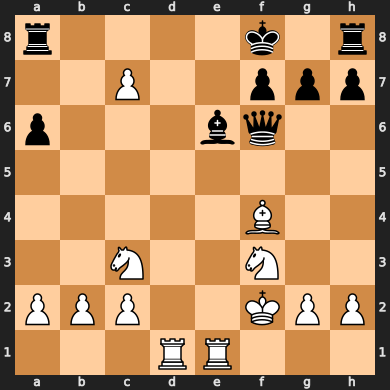

222
(1555, AbsHRBefore                                                         10
AbsHRAfter                                                          17
MoveS                                                              Bg5
MovePGN                                                       ['f4g5']
Time                                                               686
DeltaPos                                                          0.55
Game                                                        Game0816-3
Board                r4k1r/2P2ppp/p3bq2/6B1/8/2N2N2/PPP2KPP/3RR3 b ...
Evaluation                                                       11.45
AbsHRBefore_altro                                                   14
AbsHRAfter_altro                                                    14
Player                                                               w
Name: 1555, dtype: object)


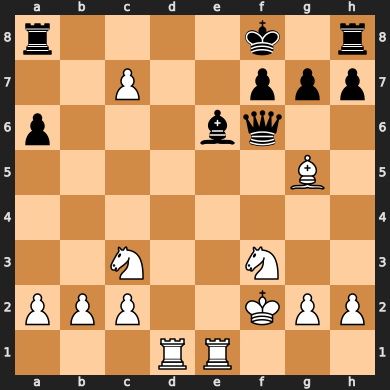

223
(1588, AbsHRBefore                                                         19
AbsHRAfter                                                          18
MoveS                                                              Nf3
MovePGN                                                       ['d4f3']
Time                                                                84
DeltaPos                                                          0.11
Game                                                        Game0817-1
Board                rnbqk2r/pp2ppbp/3p1np1/8/4P3/2NB1N2/PPP2PPP/R1...
Evaluation                                                       -0.11
AbsHRBefore_altro                                                   19
AbsHRAfter_altro                                                    13
Player                                                               w
Name: 1588, dtype: object)


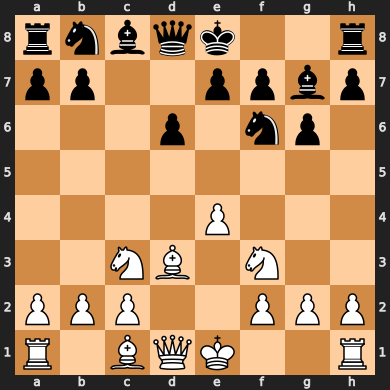

224
(1589, AbsHRBefore                                                         10
AbsHRAfter                                                          10
MoveS                                                              Bg4
MovePGN                                                       ['c8g4']
Time                                                               103
DeltaPos                                                         -0.04
Game                                                        Game0817-1
Board                rn1qk2r/pp2ppbp/3p1np1/8/4P1b1/2NB1N2/PPP2PPP/...
Evaluation                                                       -0.07
AbsHRBefore_altro                                                   11
AbsHRAfter_altro                                                    16
Player                                                               b
Name: 1589, dtype: object)


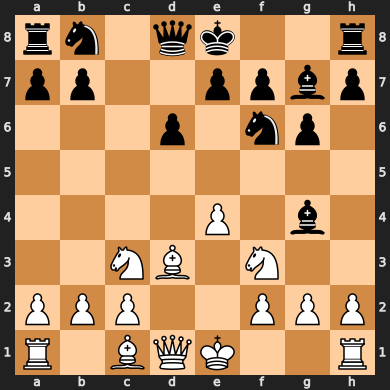

225
(1590, AbsHRBefore                                                         12
AbsHRAfter                                                          12
MoveS                                                               h3
MovePGN                                                       ['h2h3']
Time                                                               116
DeltaPos                                                          0.11
Game                                                        Game0817-1
Board                rn1qk2r/pp2ppbp/3p1np1/8/4P1b1/2NB1N1P/PPP2PP1...
Evaluation                                                        0.04
AbsHRBefore_altro                                                   12
AbsHRAfter_altro                                                     9
Player                                                               w
Name: 1590, dtype: object)


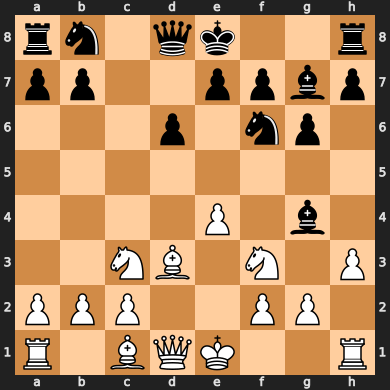

226
(1605, AbsHRBefore                                                         26
AbsHRAfter                                                          24
MoveS                                                              Qb6
MovePGN                                                       ['d8b6']
Time                                                               234
DeltaPos                                                         -0.13
Game                                                        Game0817-1
Board                r4rk1/4ppbp/pq1p1np1/1p6/4P3/1PNQ3P/1PP2PP1/R1...
Evaluation                                                       -0.27
AbsHRBefore_altro                                                   26
AbsHRAfter_altro                                                     8
Player                                                               b
Name: 1605, dtype: object)


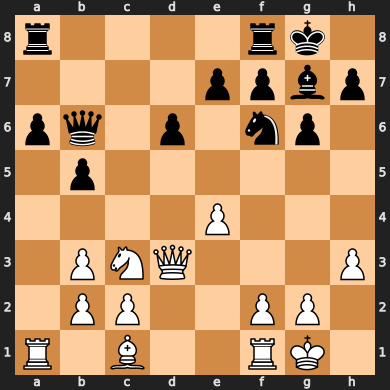

227
(1606, AbsHRBefore                                                         16
AbsHRAfter                                                          17
MoveS                                                              Be3
MovePGN                                                       ['c1e3']
Time                                                               245
DeltaPos                                                          0.18
Game                                                        Game0817-1
Board                r4rk1/4ppbp/pq1p1np1/1p6/4P3/1PNQB2P/1PP2PP1/R...
Evaluation                                                       -0.45
AbsHRBefore_altro                                                   16
AbsHRAfter_altro                                                    12
Player                                                               w
Name: 1606, dtype: object)


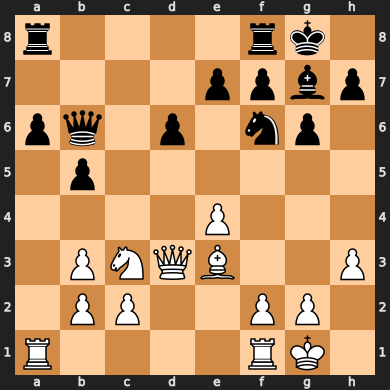

228
(1607, AbsHRBefore                                                         14
AbsHRAfter                                                          14
MoveS                                                              Qc6
MovePGN                                                       ['b6c6']
Time                                                               257
DeltaPos                                                         -0.63
Game                                                        Game0817-1
Board                r4rk1/4ppbp/p1qp1np1/1p6/4P3/1PNQB2P/1PP2PP1/R...
Evaluation                                                        0.18
AbsHRBefore_altro                                                   16
AbsHRAfter_altro                                                    14
Player                                                               b
Name: 1607, dtype: object)


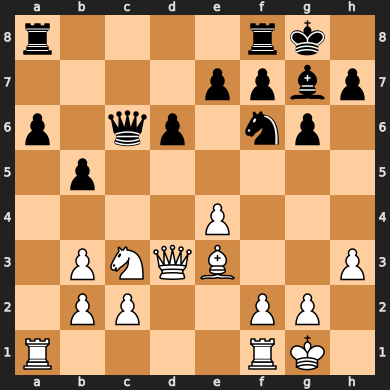

229
(1613, AbsHRBefore                                                          2
AbsHRAfter                                                           3
MoveS                                                               b4
MovePGN                                                       ['b5b4']
Time                                                               365
DeltaPos                                                         -0.53
Game                                                        Game0817-1
Board                r4rk1/3qppbp/p2p2p1/3P4/1p6/1PPQB2P/1P3PP1/R4R...
Evaluation                                                        0.77
AbsHRBefore_altro                                                   11
AbsHRAfter_altro                                                     8
Player                                                               b
Name: 1613, dtype: object)


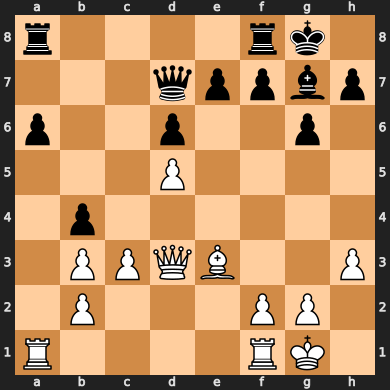

230
(1620, AbsHRBefore                                                          3
AbsHRAfter                                                           2
MoveS                                                              Qc2
MovePGN                                                       ['d2c2']
Time                                                               475
DeltaPos                                                          2.07
Game                                                        Game0817-1
Board                1rr3k1/3qppbp/p2p2p1/3P4/8/1PP1B2P/2Q2PP1/2R2R...
Evaluation                                                       -2.57
AbsHRBefore_altro                                                   11
AbsHRAfter_altro                                                    10
Player                                                               w
Name: 1620, dtype: object)


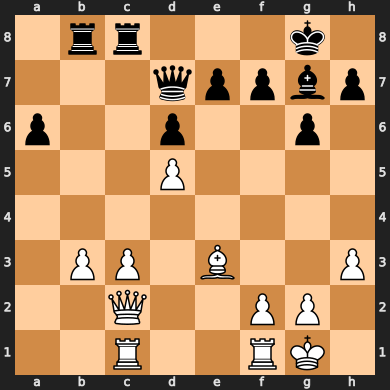

231
(1621, AbsHRBefore                                                         31
AbsHRAfter                                                          30
MoveS                                                              Qb5
MovePGN                                                       ['d7b5']
Time                                                               509
DeltaPos                                                         -1.07
Game                                                        Game0817-1
Board                1rr3k1/4ppbp/p2p2p1/1q1P4/8/1PP1B2P/2Q2PP1/2R2...
Evaluation                                                        -1.5
AbsHRBefore_altro                                                   31
AbsHRAfter_altro                                                     4
Player                                                               b
Name: 1621, dtype: object)


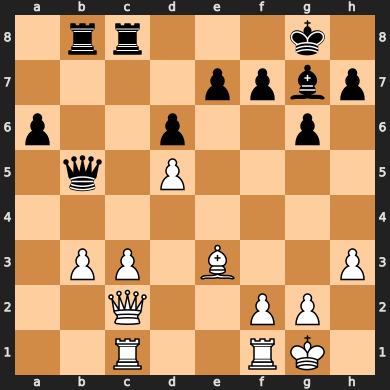

232
(1624, AbsHRBefore                                                          1
AbsHRAfter                                                           1
MoveS                                                              Bd2
MovePGN                                                       ['e3d2']
Time                                                               595
DeltaPos                                                          1.78
Game                                                        Game0817-1
Board                1rr3k1/4ppbp/p2p2p1/3q4/1P6/2P4P/2QB1PP1/2R2RK...
Evaluation                                                       -3.19
AbsHRBefore_altro                                                   10
AbsHRAfter_altro                                                    13
Player                                                               w
Name: 1624, dtype: object)


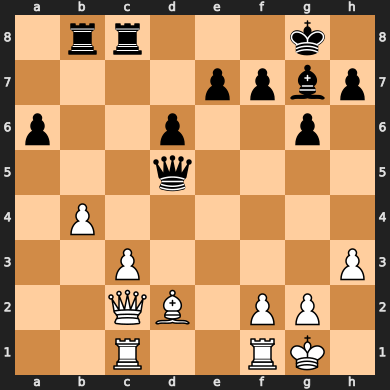

233
(1625, AbsHRBefore                                                         41
AbsHRAfter                                                          40
MoveS                                                               a5
MovePGN                                                       ['a6a5']
Time                                                               624
DeltaPos                                                         -1.91
Game                                                        Game0817-1
Board                1rr3k1/4ppbp/3p2p1/p2q4/1P6/2P4P/2QB1PP1/2R2RK...
Evaluation                                                       -1.28
AbsHRBefore_altro                                                   41
AbsHRAfter_altro                                                     7
Player                                                               b
Name: 1625, dtype: object)


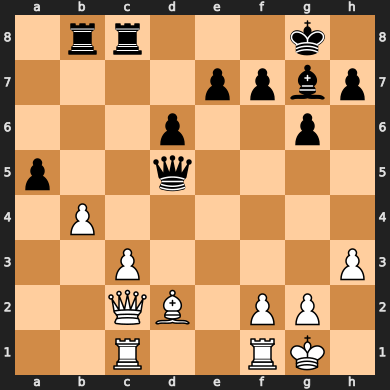

234
(1628, AbsHRBefore                                                         14
AbsHRAfter                                                          12
MoveS                                                               c4
MovePGN                                                       ['c3c4']
Time                                                               650
DeltaPos                                                          0.07
Game                                                        Game0817-1
Board                1rr3k1/4ppbp/3p2p1/q7/2P5/7P/2QB1PP1/2R2RK1 b ...
Evaluation                                                       -2.34
AbsHRBefore_altro                                                   15
AbsHRAfter_altro                                                    13
Player                                                               w
Name: 1628, dtype: object)


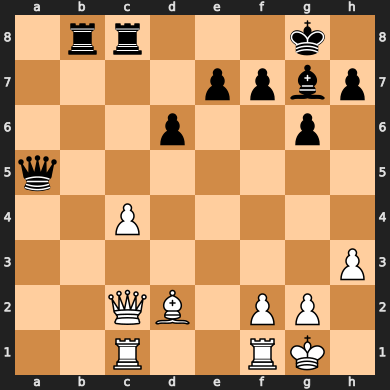

235
(1629, AbsHRBefore                                                          2
AbsHRAfter                                                           3
MoveS                                                              Qc5
MovePGN                                                       ['a5c5']
Time                                                               673
DeltaPos                                                         -0.31
Game                                                        Game0817-1
Board                1rr3k1/4ppbp/3p2p1/2q5/2P5/7P/2QB1PP1/2R2RK1 w...
Evaluation                                                       -2.03
AbsHRBefore_altro                                                    9
AbsHRAfter_altro                                                    14
Player                                                               b
Name: 1629, dtype: object)


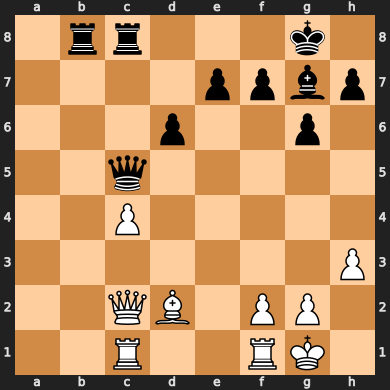

236
(1630, AbsHRBefore                                                         15
AbsHRAfter                                                          14
MoveS                                                             Rfe1
MovePGN                                                       ['f1e1']
Time                                                               691
DeltaPos                                                           1.9
Game                                                        Game0817-1
Board                1rr3k1/4ppbp/3p2p1/2q5/2P5/7P/2QB1PP1/2R1R1K1 ...
Evaluation                                                       -3.93
AbsHRBefore_altro                                                   15
AbsHRAfter_altro                                                    10
Player                                                               w
Name: 1630, dtype: object)


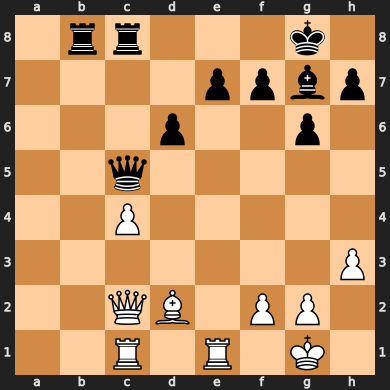

237
(1631, AbsHRBefore                                                          2
AbsHRAfter                                                           4
MoveS                                                               e6
MovePGN                                                       ['e7e6']
Time                                                               709
DeltaPos                                                         -2.28
Game                                                        Game0817-1
Board                1rr3k1/5pbp/3pp1p1/2q5/2P5/7P/2QB1PP1/2R1R1K1 ...
Evaluation                                                       -1.65
AbsHRBefore_altro                                                    8
AbsHRAfter_altro                                                     8
Player                                                               b
Name: 1631, dtype: object)


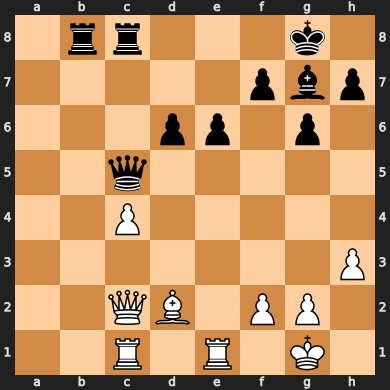

238
(1632, AbsHRBefore                                                          0
AbsHRAfter                                                           1
MoveS                                                              Bf4
MovePGN                                                       ['d2f4']
Time                                                               722
DeltaPos                                                          3.47
Game                                                        Game0817-1
Board                1rr3k1/5pbp/3pp1p1/2q5/2P2B2/7P/2Q2PP1/2R1R1K1...
Evaluation                                                       -5.12
AbsHRBefore_altro                                                    2
AbsHRAfter_altro                                                     2
Player                                                               w
Name: 1632, dtype: object)


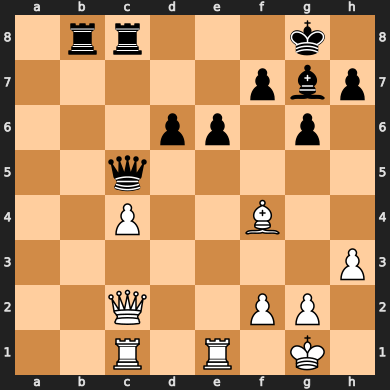

239
(1633, AbsHRBefore                                                          4
AbsHRAfter                                                           5
MoveS                                                              Rb4
MovePGN                                                       ['b8b4']
Time                                                               742
DeltaPos                                                         -3.17
Game                                                        Game0817-1
Board                2r3k1/5pbp/3pp1p1/2q5/1rP2B2/7P/2Q2PP1/2R1R1K1...
Evaluation                                                       -1.95
AbsHRBefore_altro                                                    4
AbsHRAfter_altro                                                     4
Player                                                               b
Name: 1633, dtype: object)


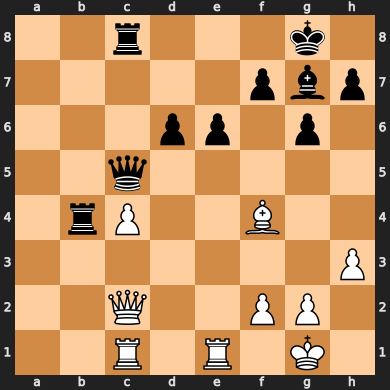

240
(1634, AbsHRBefore                                                          2
AbsHRAfter                                                           3
MoveS                                                              Re2
MovePGN                                                       ['e1e2']
Time                                                               797
DeltaPos                                                          3.09
Game                                                        Game0817-1
Board                2r3k1/5pbp/3pp1p1/2q5/1rP2B2/7P/2Q1RPP1/2R3K1 ...
Evaluation                                                       -5.04
AbsHRBefore_altro                                                   12
AbsHRAfter_altro                                                     5
Player                                                               w
Name: 1634, dtype: object)


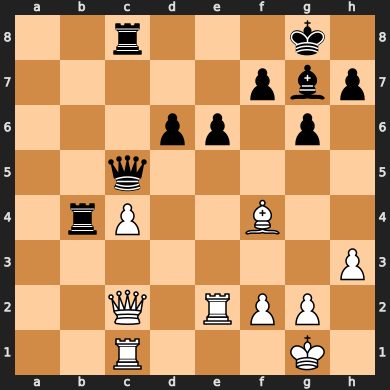

241
(1644, AbsHRBefore                                                    7
AbsHRAfter                                                     4
MoveS                                                        Ba3
MovePGN                                                 ['d6a3']
Time                                                         882
DeltaPos                                                    0.02
Game                                                  Game0817-1
Board                6k1/5pbp/2r1p1p1/8/8/B6P/4RPPK/8 b - - 4 35
Evaluation                                                  -0.2
AbsHRBefore_altro                                              7
AbsHRAfter_altro                                              13
Player                                                         w
Name: 1644, dtype: object)


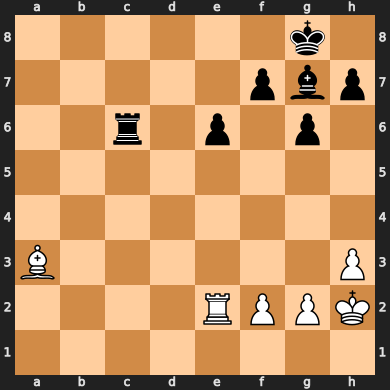

242
(1645, AbsHRBefore                                                     28
AbsHRAfter                                                      28
MoveS                                                          Bd4
MovePGN                                                   ['g7d4']
Time                                                           898
DeltaPos                                                      0.05
Game                                                    Game0817-1
Board                6k1/5p1p/2r1p1p1/8/3b4/B6P/4RPPK/8 w - - 5 36
Evaluation                                                   -0.25
AbsHRBefore_altro                                               28
AbsHRAfter_altro                                                 3
Player                                                           b
Name: 1645, dtype: object)


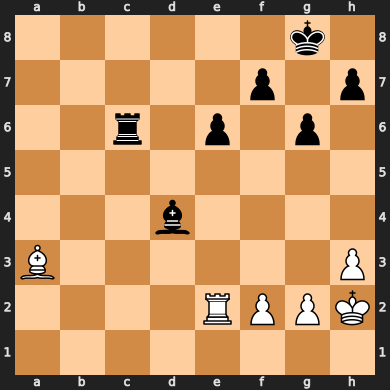

243
(1648, AbsHRBefore                                                       2
AbsHRAfter                                                        3
MoveS                                                           Bc1
MovePGN                                                    ['a3c1']
Time                                                            963
DeltaPos                                                       0.17
Game                                                     Game0817-1
Board                6k1/5p1p/r3p1p1/8/3b4/6PP/4RP1K/2B5 b - - 2 37
Evaluation                                                    -0.52
AbsHRBefore_altro                                                 3
AbsHRAfter_altro                                                  2
Player                                                            w
Name: 1648, dtype: object)


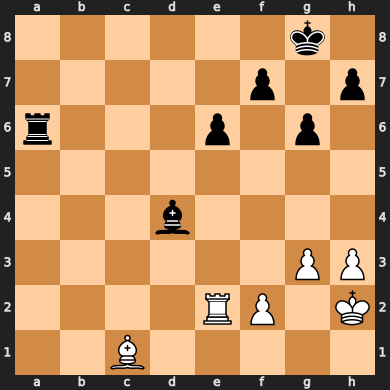

244
(1653, AbsHRBefore                                                   18
AbsHRAfter                                                    19
MoveS                                                        Bd6
MovePGN                                                 ['c5d6']
Time                                                        1032
DeltaPos                                                   -5.39
Game                                                  Game0817-1
Board                8/5pkp/r2bp1p1/4R3/8/5PPP/7K/2B5 w - - 3 40
Evaluation                                                 -0.48
AbsHRBefore_altro                                             18
AbsHRAfter_altro                                              10
Player                                                         b
Name: 1653, dtype: object)


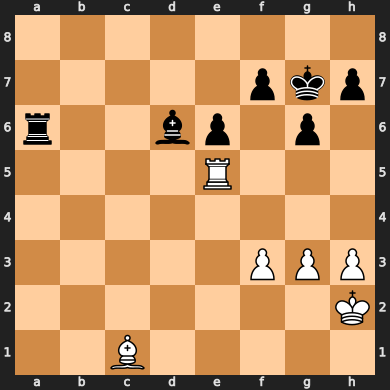

245
(1661, AbsHRBefore                                                   19
AbsHRAfter                                                    18
MoveS                                                         f6
MovePGN                                                 ['f7f6']
Time                                                        1123
DeltaPos                                                    -0.1
Game                                                  Game0817-1
Board                8/4k1Bp/2rbppp1/8/8/5PPP/4R1K1/8 w - - 0 44
Evaluation                                                 -0.67
AbsHRBefore_altro                                             19
AbsHRAfter_altro                                              24
Player                                                         b
Name: 1661, dtype: object)


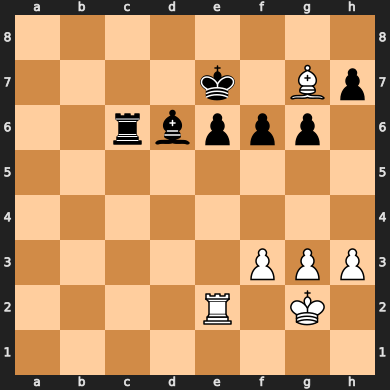

246
(1662, AbsHRBefore                                                     28
AbsHRAfter                                                      32
MoveS                                                           g4
MovePGN                                                   ['g3g4']
Time                                                          1143
DeltaPos                                                      2.78
Game                                                    Game0817-1
Board                8/4k1Bp/2rbppp1/8/6P1/5P1P/4R1K1/8 b - - 0 44
Evaluation                                                   -3.45
AbsHRBefore_altro                                               28
AbsHRAfter_altro                                                17
Player                                                           w
Name: 1662, dtype: object)


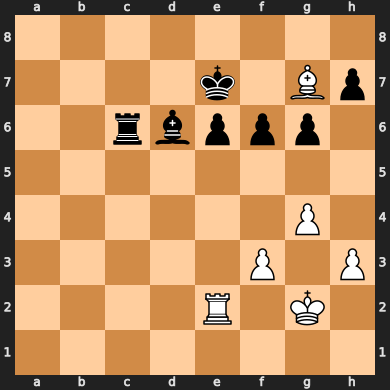

247
(1703, AbsHRBefore                                                          6
AbsHRAfter                                                           7
MoveS                                                              Qh4
MovePGN                                                       ['d4h4']
Time                                                               194
DeltaPos                                                         -0.08
Game                                                        Game0529-1
Board                r3kb1r/pp3ppp/4pn2/3p4/P6q/1PP5/3B1PPP/R2QR1K1...
Evaluation                                                       -7.56
AbsHRBefore_altro                                                    6
AbsHRAfter_altro                                                     5
Player                                                               b
Name: 1703, dtype: object)


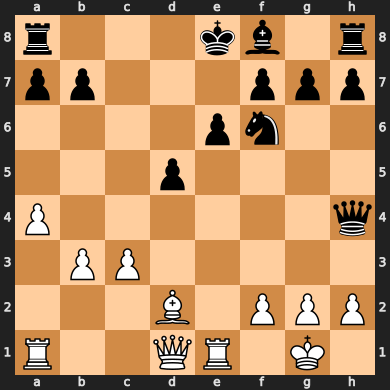

248
(1704, AbsHRBefore                                                          4
AbsHRAfter                                                           4
MoveS                                                              Qe2
MovePGN                                                       ['d1e2']
Time                                                               234
DeltaPos                                                          0.44
Game                                                        Game0529-1
Board                r3kb1r/pp3ppp/4pn2/3p4/P6q/1PP5/3BQPPP/R3R1K1 ...
Evaluation                                                          -8
AbsHRBefore_altro                                                    7
AbsHRAfter_altro                                                    10
Player                                                               w
Name: 1704, dtype: object)


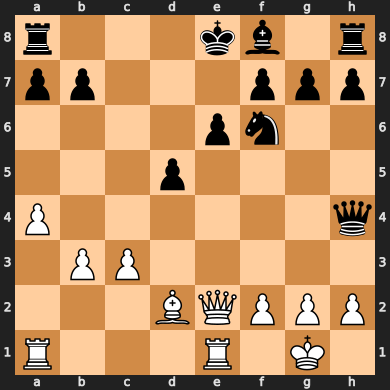

249
(1708, AbsHRBefore                                                         24
AbsHRAfter                                                          27
MoveS                                                             Qb5+
MovePGN                                                       ['e2b5']
Time                                                               292
DeltaPos                                                          0.75
Game                                                        Game0529-1
Board                r3k2r/pp3ppp/3bp3/1Q1p4/P3n2q/1PP4P/3B1PP1/R3R...
Evaluation                                                        -6.1
AbsHRBefore_altro                                                   24
AbsHRAfter_altro                                                    14
Player                                                               w
Name: 1708, dtype: object)


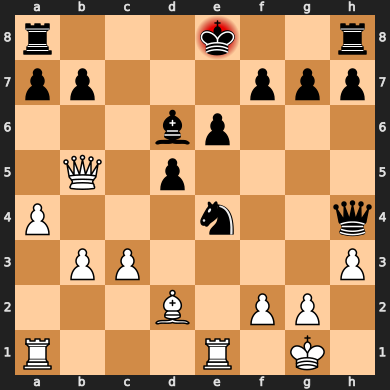

250
(1709, AbsHRBefore                                                          4
AbsHRAfter                                                           6
MoveS                                                              Ke7
MovePGN                                                       ['e8e7']
Time                                                               315
DeltaPos                                                         -2.31
Game                                                        Game0529-1
Board                r6r/pp2kppp/3bp3/1Q1p4/P3n2q/1PP4P/3B1PP1/R3R1...
Evaluation                                                       -3.79
AbsHRBefore_altro                                                   25
AbsHRAfter_altro                                                    24
Player                                                               b
Name: 1709, dtype: object)


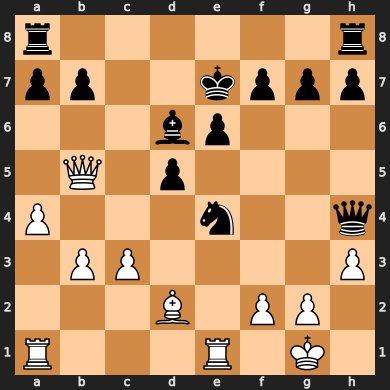

251
(1712, AbsHRBefore                                                         31
AbsHRAfter                                                          30
MoveS                                                              Be3
MovePGN                                                       ['d2e3']
Time                                                               359
DeltaPos                                                          0.53
Game                                                        Game0529-1
Board                r6r/pQ3ppp/3bpk2/3p4/P3n2q/1PP1B2P/5PP1/R3R1K1...
Evaluation                                                       -5.19
AbsHRBefore_altro                                                   31
AbsHRAfter_altro                                                    19
Player                                                               w
Name: 1712, dtype: object)


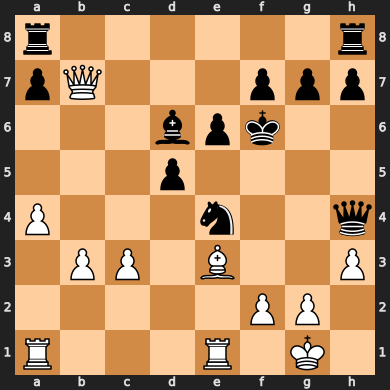

252
(1713, AbsHRBefore                                                          4
AbsHRAfter                                                           4
MoveS                                                              Qh5
MovePGN                                                       ['h4h5']
Time                                                               410
DeltaPos                                                         -3.87
Game                                                        Game0529-1
Board                r6r/pQ3ppp/3bpk2/3p3q/P3n3/1PP1B2P/5PP1/R3R1K1...
Evaluation                                                       -1.32
AbsHRBefore_altro                                                   35
AbsHRAfter_altro                                                    34
Player                                                               b
Name: 1713, dtype: object)


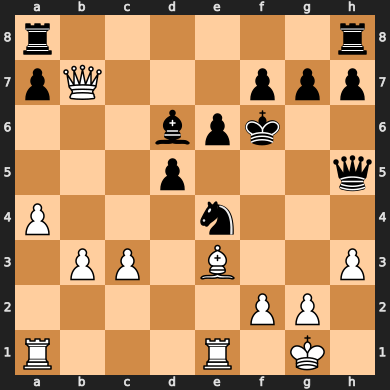

253
(1716, AbsHRBefore                                                         28
AbsHRAfter                                                          30
MoveS                                                               g3
MovePGN                                                       ['g2g3']
Time                                                               570
DeltaPos                                                          0.72
Game                                                        Game0529-1
Board                r6r/pQ3ppp/3bpk2/3pq3/P1P1n3/1P2B1PP/5P2/R3R1K...
Evaluation                                                       -4.58
AbsHRBefore_altro                                                   28
AbsHRAfter_altro                                                    17
Player                                                               w
Name: 1716, dtype: object)


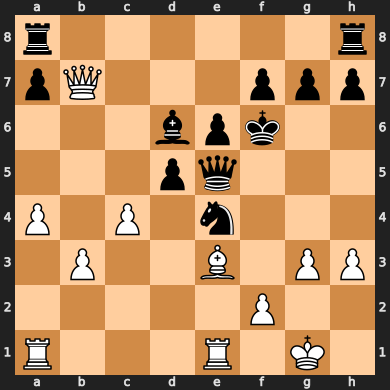

254
(1717, AbsHRBefore                                                          8
AbsHRAfter                                                           8
MoveS                                                              Nc5
MovePGN                                                       ['e4c5']
Time                                                               683
DeltaPos                                                        -11.09
Game                                                        Game0529-1
Board                r6r/pQ3ppp/3bpk2/2npq3/P1P5/1P2B1PP/5P2/R3R1K1...
Evaluation                                                        6.51
AbsHRBefore_altro                                                   31
AbsHRAfter_altro                                                    32
Player                                                               b
Name: 1717, dtype: object)


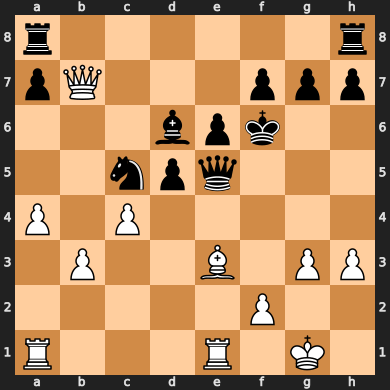

255
(1718, AbsHRBefore                                                         37
AbsHRAfter                                                          34
MoveS                                                             Bxc5
MovePGN                                                       ['e3c5']
Time                                                               747
DeltaPos                                                          0.14
Game                                                        Game0529-1
Board                r6r/pQ3ppp/3bpk2/2Bpq3/P1P5/1P4PP/5P2/R3R1K1 b...
Evaluation                                                        6.37
AbsHRBefore_altro                                                   37
AbsHRAfter_altro                                                    22
Player                                                               w
Name: 1718, dtype: object)


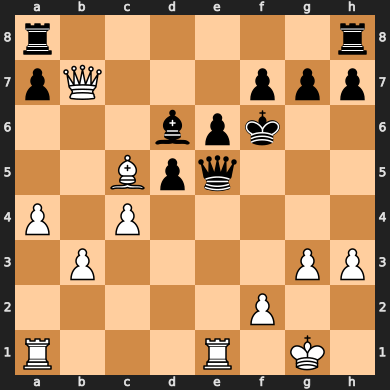

256
(1722, AbsHRBefore                                                         26
AbsHRAfter                                                          24
MoveS                                                              Rd1
MovePGN                                                       ['a1d1']
Time                                                               832
DeltaPos                                                          1.17
Game                                                        Game0529-1
Board                r6r/pQ3ppp/4pk2/2bp4/P1P5/1P4PP/5P2/3R2K1 b - ...
Evaluation                                                        5.87
AbsHRBefore_altro                                                   26
AbsHRAfter_altro                                                    16
Player                                                               w
Name: 1722, dtype: object)


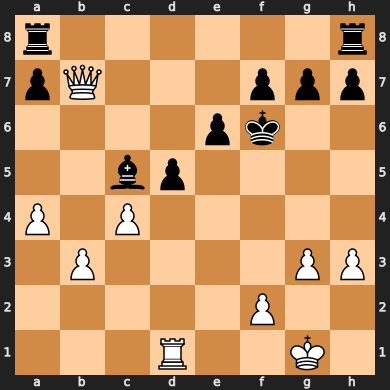

257
(1723, AbsHRBefore                                                         15
AbsHRAfter                                                          15
MoveS                                                             Rab8
MovePGN                                                       ['a8b8']
Time                                                               844
DeltaPos                                                         -0.39
Game                                                        Game0529-1
Board                1r5r/pQ3ppp/4pk2/2bp4/P1P5/1P4PP/5P2/3R2K1 w -...
Evaluation                                                        6.26
AbsHRBefore_altro                                                   21
AbsHRAfter_altro                                                    20
Player                                                               b
Name: 1723, dtype: object)


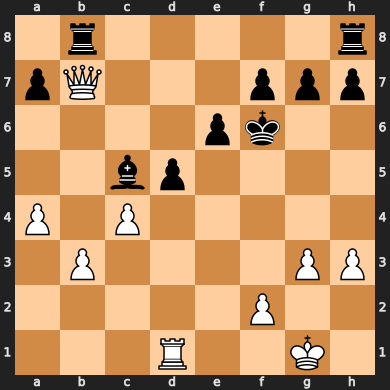

258
(1724, AbsHRBefore                                                         14
AbsHRAfter                                                          15
MoveS                                                              Qa6
MovePGN                                                       ['b7a6']
Time                                                               872
DeltaPos                                                          3.21
Game                                                        Game0529-1
Board                1r5r/p4ppp/Q3pk2/2bp4/P1P5/1P4PP/5P2/3R2K1 b -...
Evaluation                                                        3.05
AbsHRBefore_altro                                                   15
AbsHRAfter_altro                                                    13
Player                                                               w
Name: 1724, dtype: object)


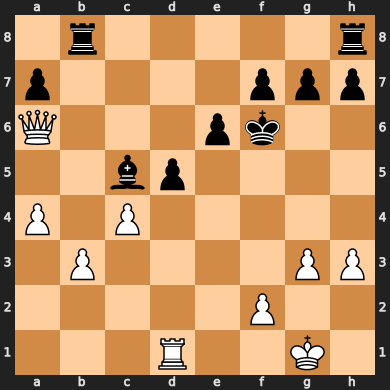

259
(1725, AbsHRBefore                                                         14
AbsHRAfter                                                          12
MoveS                                                             Rxb3
MovePGN                                                       ['b8b3']
Time                                                               892
DeltaPos                                                         -1.35
Game                                                        Game0529-1
Board                7r/p4ppp/Q3pk2/2bp4/P1P5/1r4PP/5P2/3R2K1 w - -...
Evaluation                                                         4.4
AbsHRBefore_altro                                                   14
AbsHRAfter_altro                                                    13
Player                                                               b
Name: 1725, dtype: object)


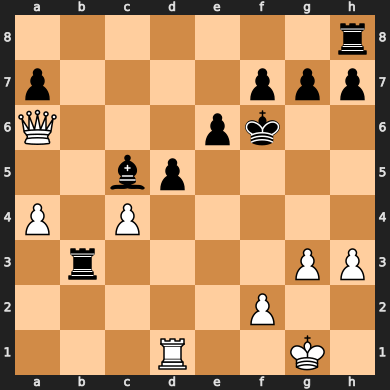

260
(1731, AbsHRBefore                                                         25
AbsHRAfter                                                          24
MoveS                                                              Ke7
MovePGN                                                       ['f6e7']
Time                                                               949
DeltaPos                                                         -0.16
Game                                                        Game0529-1
Board                4r3/p3kppp/1r2p3/2bP4/P7/5QPP/5P2/3R2K1 w - - ...
Evaluation                                                        6.18
AbsHRBefore_altro                                                   25
AbsHRAfter_altro                                                    27
Player                                                               b
Name: 1731, dtype: object)


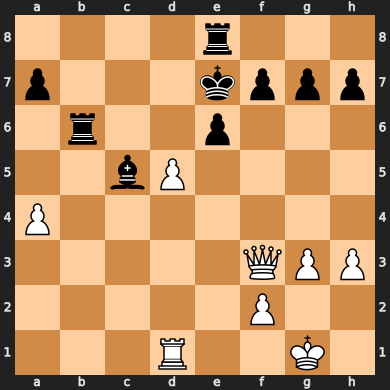

261
(1732, AbsHRBefore                                                         35
AbsHRAfter                                                          32
MoveS                                                              Rc1
MovePGN                                                       ['d1c1']
Time                                                               961
DeltaPos                                                          0.95
Game                                                        Game0529-1
Board                4r3/p3kppp/1r2p3/2bP4/P7/5QPP/5P2/2R3K1 b - - ...
Evaluation                                                        5.23
AbsHRBefore_altro                                                   35
AbsHRAfter_altro                                                    23
Player                                                               w
Name: 1732, dtype: object)


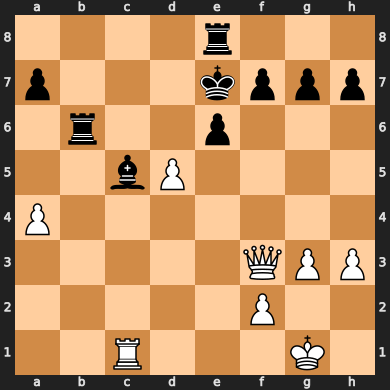

262
(1778, AbsHRBefore                                                         14
AbsHRAfter                                                          15
MoveS                                                               c4
MovePGN                                                       ['c2c4']
Time                                                               205
DeltaPos                                                          2.04
Game                                                        Game0813-1
Board                r1b2rk1/1pb2ppp/p1n1q3/4p3/2P5/3P1N2/PP3PPP/R1...
Evaluation                                                       -8.46
AbsHRBefore_altro                                                   14
AbsHRAfter_altro                                                    13
Player                                                               w
Name: 1778, dtype: object)


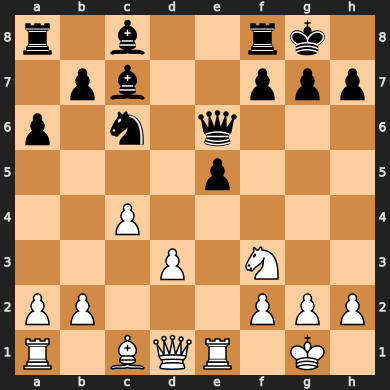

263
(1798, AbsHRBefore                                                          4
AbsHRAfter                                                           5
MoveS                                                              Qd1
MovePGN                                                       ['e2d1']
Time                                                               464
DeltaPos                                                          1.01
Game                                                        Game0813-1
Board                3rr1k1/1p1q2pp/p4p2/n7/2P5/3P4/PP3PPP/3QR1K1 b...
Evaluation                                                      -11.24
AbsHRBefore_altro                                                    4
AbsHRAfter_altro                                                     4
Player                                                               w
Name: 1798, dtype: object)


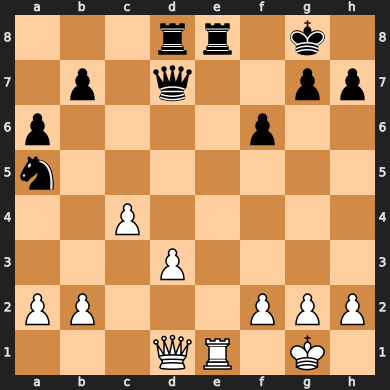

In [417]:
perdenti_prima = []
perdenti_dopo = []
vincenti_prima = []
vincenti_dopo = []
lista_c = []
c = 0

for row in ndff.iterrows():
    
    if abs(row[1][4]) > 3.0:
        
        lista_c.append(row[1])
        print(c)
        c += 1
        print(row)
        display(chess.Board(row[1]["Board"]))
        if (row[1][10] == 'b' and '-' in str(row[1][7])) or (row[1][10] == 'w' and '-'  not in str(row[1][7])):
            vincenti_prima.append(row[1][0]) 
            vincenti_dopo.append(row[1][1])
            perdenti_prima.append(row[1][8])
            perdenti_dopo.append(row[1][9])
            
        else:
            perdenti_prima.append(row[1][0]) 
            perdenti_dopo.append(row[1][1])
            vincenti_prima.append(row[1][8])
            vincenti_dopo.append(row[1][9])

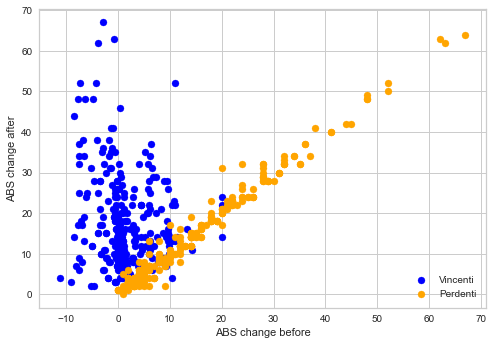

In [418]:
# Here we displayed the scatter plot of the "winners" vs the "losers" relative to each move, with their heart reate before and after the move
plt.scatter(vincenti_prima, vincenti_dopo, color = "blue")
plt.scatter(perdenti_prima, perdenti_dopo, color = 'orange')
plt.ylabel("ABS change after")
plt.xlabel("ABS change before")
plt.legend(["Vincenti","Perdenti"])
plt.show()


This suggests that a good move or more in general a move that brings you an advantage might, on average, cause an decrease in the heartrate.

In [407]:
# Let's load the big dataset too
df2 = pd.read_csv("partite.csv")
df2 = df2.pivot_table(values='Value',
                                index='Time',
                                columns=['Game', 'Player', 'Statistics'])


old = pd.read_csv("mosse.csv")
df2

Game       Game0529-1                                        Game0529-2       \
Player              b                        w                        b        
Statistics Evaluation   HR TimeUsed Evaluation   HR TimeUsed Evaluation   HR   
Time                                                                           
0               -0.57 -2.0      0.0       0.57  4.0      0.0      -0.57 -3.0   
1               -0.57 -1.0      0.0       0.57  3.0      0.0      -0.57 -3.0   
2               -0.57 -2.0      0.0       0.57  2.0      0.0      -0.57 -2.0   
3               -0.45 -1.0      3.0       0.45  1.0      3.0      -0.43 -2.0   
4               -0.45  0.0      3.0       0.45  0.0      3.0      -0.33 -1.0   
...               ...  ...      ...        ...  ...      ...        ...  ...   
1185              NaN  NaN      NaN        NaN  NaN      NaN        NaN  NaN   
1186              NaN  NaN      NaN        NaN  NaN      NaN        NaN  NaN   
1187              NaN  NaN      NaN        NaN  NaN      NaN        NaN  NaN   
1188              NaN  NaN      NaN        NaN  NaN      NaN        NaN  NaN   
1189              NaN  NaN      NaN        NaN  NaN      NaN        NaN  NaN   

Game                            ... Game0817-3                           \
Player                       w  ...          b          w                 
Statistics TimeUsed Evaluation  ...   TimeUsed Evaluation   HR TimeUsed   
Time                            ...                                       
0               0.0       0.57  ...        0.0       1.25  0.0      0.0   
1               0.0       0.57  ...        0.0       1.25 -1.0      0.0   
2               0.0       0.57  ...        0.0       1.25 -1.0      0.0   
3               3.0       0.43  ...        0.0       1.25 -1.0      0.0   
4               3.0       0.33  ...        0.0       1.25 -1.0      0.0   
...             ...        ...  ...        ...        ...  ...      ...   
1185            NaN        NaN  ...        NaN        NaN  NaN      NaN   
1186            NaN        NaN  ...        NaN        NaN  NaN      NaN   
1187            NaN        NaN  ...        NaN        NaN  NaN      NaN   
1188            NaN        NaN  ...        NaN        NaN  NaN      NaN   
1189            NaN        NaN  ...        NaN        NaN  NaN      NaN   

Game       Game0817-4                                         
Player              b                        w                
Statistics Evaluation   HR TimeUsed Evaluation   HR TimeUsed  
Time                                                          
0               -0.40  1.0      0.0       0.40  4.0      0.0  
1               -0.45  0.0      1.0       0.45  3.0      1.0  
2               -0.31 -1.0      1.0       0.31  1.0      1.0  
3               -0.31 -1.0      1.0       0.31  1.0      1.0  
4               -0.25  1.0      3.0       0.25  0.0      3.0  
...               ...  ...      ...        ...  ...      ...  
1185              NaN  NaN      NaN        NaN  NaN      NaN  
1186              NaN  NaN      NaN        NaN  NaN      NaN  
1187              NaN  NaN      NaN        NaN  NaN      NaN  
1188              NaN  NaN      NaN        NaN  NaN      NaN  
1189              NaN  NaN      NaN        NaN  NaN      NaN  

[1190 rows x 132 columns]

In [408]:
def get_next_move(i):
    return old.iloc[i+1]

def get_prev_move(i):
    return old.iloc[i-1]

Now we start to really analyse some of the boards you saw above

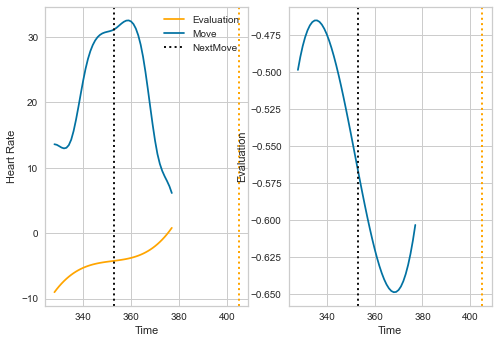

Rd2


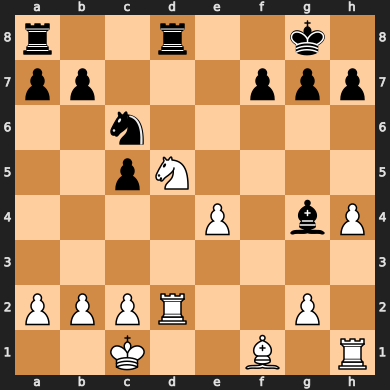

AssertionError: push() expects move to be pseudo-legal, but got g1f3 in r2r2k1/pp3ppp/2n5/2pN4/4P1bP/8/PPPR2P1/2K2B1R

In [414]:
from scipy.interpolate import UnivariateSpline


ind = 6 # select one of the boards above
nm = get_next_move(lista_c[ind].name) #load also the next move 

partita = lista_c[ind]["Game"]



hrw = df2[partita]["w"]["HR"].iloc[lista_c[ind]["Time"]-25:lista_c[ind]["Time"]+25]
hrb = df2[partita]["b"]["HR"].iloc[lista_c[ind]["Time"]-25:lista_c[ind]["Time"]+25]
pos = df2[partita]["w"]["Evaluation"].iloc[lista_c[ind]["Time"]-25:lista_c[ind]["Time"]+25].astype(float)

t = hrw.index

splw = UnivariateSpline(t, hrw)

splb = UnivariateSpline(t, hrb)

splpos = UnivariateSpline(t, pos)

f, (ax1, ax2) = plt.subplots(1, 2)




ax1.plot(t, splw(t),color='orange' )
# ax1.plot(t,eb0, color='orange')
ax1.plot(t, splb(t),color='b')

ax1.axvline(lista_c[ind]["Time"], color='k', linestyle='dotted', linewidth=2)
ax1.axvline(nm["Time"], color='orange', linestyle='dotted', linewidth=2)
ax1.legend(['Bianco', 'Nero', 'Move', 'NextMove'])
ax1.set_xlabel("Time")
ax1.set_ylabel("Heart Rate")

ax2.plot(t,splpos(t))
ax2.axvline(lista_c[ind]["Time"], color='k', linestyle='dotted', linewidth=2)
ax2.axvline(nm["Time"], color='orange', linestyle='dotted', linewidth=2)
ax2.set_xlabel("Time")
ax2.set_ylabel("Evaluation")
ax1.legend(['Evaluation', 'Move', 'NextMove'])
plt.show()
print(lista_c[ind]["MoveS"])
board =chess.Board(lista_c[ind]["Board"])
display(board)
Ng4 = chess.Move.from_uci("g1f3")
board.push(Ng4)
display(board)


Nc5 Game0529-1


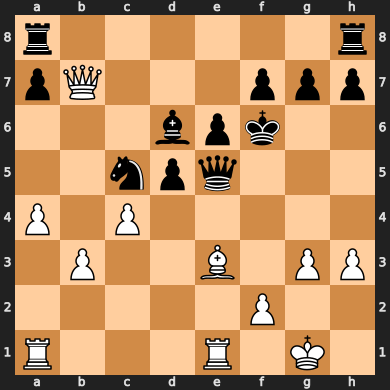

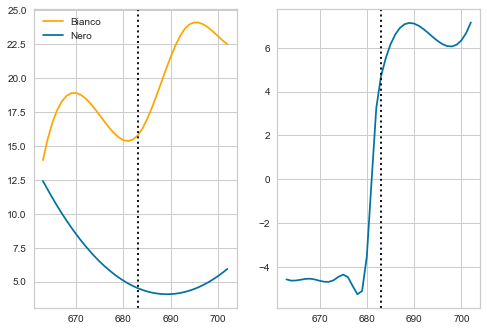

In [326]:

ind = 7
partita = lista_c[ind]["Game"]



hrw = df2[partita]["w"]["HR"].iloc[lista_c[ind]["Time"]-20:lista_c[ind]["Time"]+20]
hrb = df2[partita]["b"]["HR"].iloc[lista_c[ind]["Time"]-20:lista_c[ind]["Time"]+20]
pos = df2[partita]["w"]["Evaluation"].iloc[lista_c[ind]["Time"]-20:lista_c[ind]["Time"]+20].astype(float)

t = hrw.index

splw = UnivariateSpline(t, hrw)

splb = UnivariateSpline(t, hrb)

splpos = UnivariateSpline(t, pos)

f, (ax1, ax2) = plt.subplots(1, 2)




ax1.plot(t, splw(t),color='orange' )
# ax1.plot(t,eb0, color='orange')
ax1.plot(t, splb(t),color='b')

ax1.legend(['Bianco', 'Nero'])
ax1.axvline(lista_c[ind]["Time"], color='k', linestyle='dotted', linewidth=2)

ax2.plot(t,splpos(t))
ax2.axvline(lista_c[ind]["Time"], color='k', linestyle='dotted', linewidth=2)

print(lista_c[ind]["MoveS"],lista_c[ind]["Game"])
display(chess.Board(lista_c[ind]["Board"]))


Analisi qualitativa

AbsHRBefore                                                         29
AbsHRAfter                                                          28
MoveS                                                              Ba5
Time                                                               537
DeltaPos                                                         -6.05
Game                                                        Game0816-1
Board                3rr3/pk3ppp/2R5/b3P3/4N3/4P3/PP4PP/2R3K1 w - -...
Evaluation                                                        7.25
AbsHRBefore_altro                                                   29
AbsHRAfter_altro                                                     5
Player                                                               b
Name: 188, dtype: object


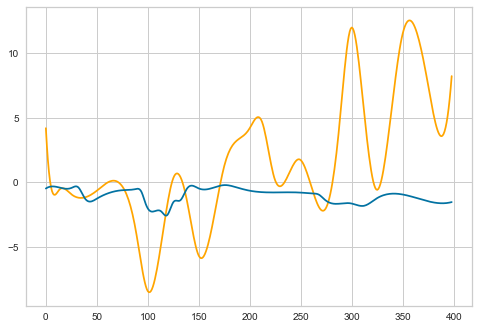

In [244]:
print(lista_c[0])
partita = lista_c[0]["Game"]



hb0 = df2[partita]['b']['HR']
t = df2.index
spl = UnivariateSpline(t, hb0)

eb0 = df2[partita]['b']['Evaluation'] 
sple = UnivariateSpline(t, eb0)
sple.set_smoothing_factor(10)
# plt.plot(t,hb0)
plt.plot(t, spl(t),color='orange', label= "HeartRate")
# plt.plot(t,eb0, color='orange')
plt.plot(t, sple(t),color='b', label= "Evaluation")

In [247]:
df2["Game0816-1"]['w']['HR']

Time
0     -1.0
1     -1.0
2      0.0
3      0.0
4      0.0
      ... 
394   -2.0
395   -1.0
396    0.0
397    0.0
398    0.0
Name: HR, Length: 399, dtype: float64

In [ ]:
# # The most played move:
# for row in df.iterrows():
#     if row[1]["TPR"] == 240:
#         display(chess.Board(row[1]["Board"]))
    

In [ ]:
# #Adesso che abbiamo i dettagli delle mosse ci ripeschiamo dal dataset madre il battito al tempo della mossa
# realwage = pd.read_csv("prova.csv")

# realwage = realwage.pivot_table(values='Value',
#                                 index='Time',
#                                 columns=['Game', 'Player', 'Statistics'])

## ora dobbiamo aggiungere a ogni mossa



In [ ]:

# Display 6 columns for viewing purposes
# pd.set_option('display.max_columns', 6)

# Reduce decimal points to 2
# pd.options.display.float_format = '{:,.2f}'.format

# realwage = pd.read_csv("prova.csv")
# realwage = realwage.pivot_table(values='Value',
#                                 index='Time',
#                                 columns=['Game', 'Player', 'Statistics'])
# realwage